# Static Analysis Tool

In [ ]:
pip install radon pylint bandit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.3 MB/s eta 0:00:00


OLD

In [ ]:
# @title
import os
import csv
import sys
from io import StringIO
from pathlib import Path

# Import analysis libraries
try:
    from radon.complexity import cc_visit
    from radon.metrics import mi_visit, h_visit
    from radon.raw import analyze
except ImportError:
    print("Error: Radon not installed. Install with: pip install radon")
    sys.exit(1)

try:
    from pylint.lint import Run
    from pylint.reporters.text import TextReporter
except ImportError:
    print("Error: Pylint not installed. Install with: pip install pylint")
    sys.exit(1)

try:
    from bandit.core import manager as bandit_manager
    from bandit.core import config as bandit_config
except ImportError:
    print("Error: Bandit not installed. Install with: pip install bandit")
    sys.exit(1)


class PythonCodeAnalyzer:
    """Main class for analyzing Python code with multiple static analysis tools"""

    def __init__(self, directory_path, output_csv="analysis_results.csv"):
        """
        Initialize the analyzer

        Args:
            directory_path (str): Path to directory containing Python files
            output_csv (str): Name of output CSV file
        """
        self.directory_path = directory_path
        self.output_csv = output_csv
        self.results = []

    def find_python_files(self):
        """
        Traverse directory and find all Python files

        Returns:
            list: List of paths to Python files
        """
        python_files = []
        try:
            for root, dirs, files in os.walk(self.directory_path):
                for file in files:
                    if file.endswith('.py'):
                        python_files.append(os.path.join(root, file))
            print(f"Found {len(python_files)} Python files to analyze")
        except Exception as e:
            print(f"Error traversing directory: {e}")
        return python_files

    def analyze_with_radon(self, filepath):
        """
        Analyze code complexity using Radon

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Dictionary containing Radon analysis results
        """
        radon_results = {
            'avg_complexity': 'N/A',
            'max_complexity': 'N/A',
            'maintainability_index': 'N/A',
            'loc': 'N/A',
            'lloc': 'N/A',
            'sloc': 'N/A',
            'comments': 'N/A'
        }

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                code = f.read()

            # Cyclomatic complexity analysis
            complexity = cc_visit(code)
            if complexity:
                complexities = [block.complexity for block in complexity]
                radon_results['avg_complexity'] = round(sum(complexities) / len(complexities), 2)
                radon_results['max_complexity'] = max(complexities)
            else:
                radon_results['avg_complexity'] = 0
                radon_results['max_complexity'] = 0

            # Maintainability index
            mi = mi_visit(code, multi=True)
            if mi:
                radon_results['maintainability_index'] = round(mi, 2)

            # Raw metrics (lines of code)
            raw = analyze(code)
            radon_results['loc'] = raw.loc
            radon_results['lloc'] = raw.lloc
            radon_results['sloc'] = raw.sloc
            radon_results['comments'] = raw.comments

        except Exception as e:
            print(f"Radon analysis failed for {filepath}: {e}")

        return radon_results

    def analyze_with_pylint(self, filepath):
        """
        Analyze code style and errors using Pylint

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Dictionary containing Pylint analysis results
        """
        pylint_results = {
            'score': 'N/A',
            'errors': 0,
            'warnings': 0,
            'conventions': 0,
            'refactors': 0,
            'messages': ''
        }

        try:
            # Capture Pylint output
            pylint_output = StringIO()
            reporter = TextReporter(pylint_output)

            # Run Pylint with minimal output
            results = Run(
                [filepath, '--score=yes', '--reports=no'],
                reporter=reporter,
                exit=False
            )

            # Extract statistics
            pylint_results['score'] = round(results.linter.stats.global_note, 2)

            # Get message counts by type
            stats = results.linter.stats
            pylint_results['errors'] = stats.error
            pylint_results['warnings'] = stats.warning
            pylint_results['conventions'] = stats.convention
            pylint_results['refactors'] = stats.refactor

            # Get top 3 messages
            output_text = pylint_output.getvalue()
            lines = [line.strip() for line in output_text.split('\n') if line.strip() and not line.startswith('---')]
            pylint_results['messages'] = ' | '.join(lines[:3]) if lines else 'No issues'


        except Exception as e:
            print(f"Pylint analysis failed for {filepath}: {e}")

        return pylint_results

    def analyze_with_bandit(self, filepath):
        """
        Analyze security vulnerabilities using Bandit

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Dictionary containing Bandit analysis results
        """
        bandit_results = {
            'high_severity': 0,
            'medium_severity': 0,
            'low_severity': 0,
            'total_issues': 0,
            'findings': ''
        }

        try:
            # Configure Bandit
            b_conf = bandit_config.BanditConfig()
            b_mgr = bandit_manager.BanditManager(b_conf, 'file')

            # Discover and run Bandit on the file
            b_mgr.discover_files([filepath])
            b_mgr.run_tests()

            # Collect results
            issues = b_mgr.get_issue_list()

            # Count by severity
            for issue in issues:
                bandit_results['total_issues'] += 1
                if issue.severity == 'HIGH':
                    bandit_results['high_severity'] += 1
                elif issue.severity == 'MEDIUM':
                    bandit_results['medium_severity'] += 1
                elif issue.severity == 'LOW':
                    bandit_results['low_severity'] += 1

            # Get top 3 findings
            findings = [f"{issue.severity}:{issue.test_id}:{issue.text}"
                       for issue in issues[:3]]
            bandit_results['findings'] = ' | '.join(findings) if findings else 'No issues'

        except Exception as e:
            print(f"Bandit analysis failed for {filepath}: {e}")

        return bandit_results

    def analyze_file(self, filepath):
        """
        Run all analyses on a single file

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Combined results from all analysis tools
        """
        print(f"Analyzing: {filepath}")

        result = {
            'filepath': filepath,
            'filename': os.path.basename(filepath)
        }

        # Run Radon analysis
        radon_data = self.analyze_with_radon(filepath)
        result.update({f'radon_{k}': v for k, v in radon_data.items()})

        # Run Pylint analysis
        pylint_data = self.analyze_with_pylint(filepath)
        result.update({f'pylint_{k}': v for k, v in pylint_data.items()})

        # Run Bandit analysis
        bandit_data = self.analyze_with_bandit(filepath)
        result.update({f'bandit_{k}': v for k, v in bandit_data.items()})

        return result

    def analyze_directory(self):
        """
        Analyze all Python files in the directory
        """
        print(f"Starting analysis of directory: {self.directory_path}")
        print("=" * 60)

        python_files = self.find_python_files()

        if not python_files:
            print("No Python files found!")
            return

        for filepath in python_files:
            try:
                result = self.analyze_file(filepath)
                self.results.append(result)
            except Exception as e:
                print(f"Failed to analyze {filepath}: {e}")
                # Add error entry to results
                self.results.append({
                    'filepath': filepath,
                    'filename': os.path.basename(filepath),
                    'error': str(e)
                })

        print("=" * 60)
        print(f"Analysis complete! Analyzed {len(self.results)} files")

    def write_to_csv(self):
        """
        Write analysis results to CSV file
        """
        if not self.results:
            print("No results to write!")
            return

        try:
            # Define CSV headers
            headers = [
                'filename', 'filepath',
                'radon_avg_complexity', 'radon_max_complexity', 'radon_maintainability_index',
                'radon_loc', 'radon_lloc', 'radon_sloc', 'radon_comments',
                'pylint_score', 'pylint_errors', 'pylint_warnings',
                'pylint_conventions', 'pylint_refactors', 'pylint_messages',
                'bandit_high_severity', 'bandit_medium_severity', 'bandit_low_severity',
                'bandit_total_issues', 'bandit_findings'
            ]

            with open(self.output_csv, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=headers, extrasaction='ignore')
                writer.writeheader()
                writer.writerows(self.results)

            print(f"\nResults written to: {self.output_csv}")

        except Exception as e:
            print(f"Error writing CSV file: {e}")

    def print_summary(self):
        """
        Print summary statistics of the analysis
        """
        if not self.results:
            return

        print("\n" + "=" * 60)
        print("ANALYSIS SUMMARY")
        print("=" * 60)

        # Calculate averages
        total_files = len(self.results)
        avg_complexity = sum(r.get('radon_avg_complexity', 0) for r in self.results
                           if isinstance(r.get('radon_avg_complexity'), (int, float))) / total_files
        avg_pylint = sum(r.get('pylint_score', 0) for r in self.results
                        if isinstance(r.get('pylint_score'), (int, float))) / total_files
        total_security = sum(r.get('bandit_total_issues', 0) for r in self.results
                           if isinstance(r.get('bandit_total_issues'), int))

        print(f"Total files analyzed: {total_files}")
        print(f"Average complexity: {avg_complexity:.2f}")
        print(f"Average Pylint score: {avg_pylint:.2f}/10")
        f"Total security issues: {total_security}"
        print("=" * 60)


def main():
    """
    Main function to run the analysis
    """
    # Prompt user for directory path and output filename
    directory = input("Enter directory path to analyze (or press Enter for current directory): ").strip()
    if not directory:
        directory = "."

    # Validate directory
    if not os.path.isdir(directory):
        print(f"Error: '{directory}' is not a valid directory")
        return # Use return instead of sys.exit(1)

    output_file = input("Enter output CSV filename (or press Enter for 'analysis_results.csv'): ").strip()
    if not output_file:
        output_file = "analysis_results.csv"

    # Create analyzer and run analysis
    analyzer = PythonCodeAnalyzer(directory, output_file)
    analyzer.analyze_directory()
    analyzer.write_to_csv()
    analyzer.print_summary()

# The main function will now be called directly when the cell is executed
main()

NEW

In [ ]:
"""
Python Static Analysis Tool - Google Colab Version
Analyzes Python files using Radon, Pylint, and Bandit
Optimized for Google Colab environment with file upload/download features
"""

import os
import csv
import sys
import zipfile
import tempfile
from io import StringIO
from pathlib import Path

# Google Colab specific imports
try:
    from google.colab import files
    import IPython.display as display
    COLAB_ENV = True
    print("✓ Running in Google Colab environment")
except ImportError:
    COLAB_ENV = False
    print("✓ Running in standard Python environment")

# Import analysis libraries
def install_dependencies():
    """Install required packages if not already installed"""
    try:
        import radon
        import pylint
        import bandit
        print("✓ All dependencies already installed")
    except ImportError:
        print("Installing dependencies...")
        os.system('pip install -q radon pylint bandit')
        print("✓ Dependencies installed successfully")

install_dependencies()

from radon.complexity import cc_visit
from radon.metrics import mi_visit, h_visit
from radon.raw import analyze
from pylint.lint import Run
from pylint.reporters.text import TextReporter
from bandit.core import manager as bandit_manager
from bandit.core import config as bandit_config


class PythonCodeAnalyzer:
    """Main class for analyzing Python code with multiple static analysis tools"""

    def __init__(self, directory_path, output_csv="analysis_results.csv"):
        """
        Initialize the analyzer

        Args:
            directory_path (str): Path to directory containing Python files
            output_csv (str): Name of output CSV file
        """
        self.directory_path = directory_path
        self.output_csv = output_csv
        self.results = []

    def find_python_files(self):
        """
        Traverse directory and find all Python files

        Returns:
            list: List of paths to Python files
        """
        python_files = []
        try:
            for root, dirs, files in os.walk(self.directory_path):
                for file in files:
                    if file.endswith('.py'):
                        python_files.append(os.path.join(root, file))
            print(f"✓ Found {len(python_files)} Python files to analyze")
        except Exception as e:
            print(f"✗ Error traversing directory: {e}")
        return python_files

    def analyze_with_radon(self, filepath):
        """
        Analyze code complexity using Radon

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Dictionary containing Radon analysis results
        """
        radon_results = {
            'avg_complexity': 'N/A',
            'max_complexity': 'N/A',
            'maintainability_index': 'N/A',
            'loc': 'N/A',
            'lloc': 'N/A',
            'sloc': 'N/A',
            'comments': 'N/A',
            'halstead_volume': 'N/A',
            'halstead_difficulty': 'N/A',
            'halstead_effort': 'N/A',
            'halstead_time': 'N/A',
            'halstead_bugs': 'N/A',
            'halstead_length': 'N/A',
            'halstead_vocabulary': 'N/A'
        }

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                code = f.read()

            # Cyclomatic complexity analysis
            complexity = cc_visit(code)
            if complexity:
                complexities = [block.complexity for block in complexity]
                radon_results['avg_complexity'] = round(sum(complexities) / len(complexities), 2)
                radon_results['max_complexity'] = max(complexities)
            else:
                radon_results['avg_complexity'] = 0
                radon_results['max_complexity'] = 0

            # Maintainability index
            mi = mi_visit(code, multi=True)
            if mi:
                radon_results['maintainability_index'] = round(mi, 2)

            # Halstead complexity metrics
            halstead = h_visit(code)
            if halstead:
                radon_results['halstead_volume'] = round(halstead.total.volume, 2) if halstead.total.volume else 'N/A'
                radon_results['halstead_difficulty'] = round(halstead.total.difficulty, 2) if halstead.total.difficulty else 'N/A'
                radon_results['halstead_effort'] = round(halstead.total.effort, 2) if halstead.total.effort else 'N/A'
                radon_results['halstead_time'] = round(halstead.total.time, 2) if halstead.total.time else 'N/A'
                radon_results['halstead_bugs'] = round(halstead.total.bugs, 4) if halstead.total.bugs else 'N/A'
                radon_results['halstead_length'] = halstead.total.length if halstead.total.length else 'N/A'
                radon_results['halstead_vocabulary'] = halstead.total.vocabulary if halstead.total.vocabulary else 'N/A'

            # Raw metrics (lines of code)
            raw = analyze(code)
            radon_results['loc'] = raw.loc
            radon_results['lloc'] = raw.lloc
            radon_results['sloc'] = raw.sloc
            radon_results['comments'] = raw.comments

        except Exception as e:
            print(f"  ⚠ Radon analysis failed for {os.path.basename(filepath)}: {e}")

        return radon_results

    def analyze_with_pylint(self, filepath):
        """
        Analyze code style and errors using Pylint

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Dictionary containing Pylint analysis results
        """
        pylint_results = {
            'score': 'N/A',
            'errors': 0,
            'warnings': 0,
            'conventions': 0,
            'refactors': 0,
            'messages': ''
        }

        try:
            # Capture Pylint output
            pylint_output = StringIO()
            reporter = TextReporter(pylint_output)

            # Run Pylint with minimal output
            results = Run(
                [filepath, '--score=yes', '--reports=no'],
                reporter=reporter,
                exit=False
            )

            # Extract statistics
            pylint_results['score'] = round(results.linter.stats.global_note, 2)

            # Get message counts by type
            stats = results.linter.stats
            pylint_results['errors'] = stats.error
            pylint_results['warnings'] = stats.warning
            pylint_results['conventions'] = stats.convention
            pylint_results['refactors'] = stats.refactor

            # Get top 3 messages
            output_text = pylint_output.getvalue()
            lines = [line.strip() for line in output_text.split('\n') if line.strip() and not line.startswith('---')]
            pylint_results['messages'] = ' | '.join(lines[:3]) if lines else 'No issues'

        except Exception as e:
            print(f"  ⚠ Pylint analysis failed for {os.path.basename(filepath)}: {e}")

        return pylint_results

    def analyze_with_bandit(self, filepath):
        """
        Analyze security vulnerabilities using Bandit

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Dictionary containing Bandit analysis results
        """
        bandit_results = {
            'high_severity': 0,
            'medium_severity': 0,
            'low_severity': 0,
            'total_issues': 0,
            'findings': ''
        }

        try:
            # Configure Bandit
            b_conf = bandit_config.BanditConfig()
            b_mgr = bandit_manager.BanditManager(b_conf, 'file')

            # Discover and run Bandit on the file
            b_mgr.discover_files([filepath])
            b_mgr.run_tests()

            # Collect results
            issues = b_mgr.get_issue_list()

            # Count by severity
            for issue in issues:
                bandit_results['total_issues'] += 1
                if issue.severity == 'HIGH':
                    bandit_results['high_severity'] += 1
                elif issue.severity == 'MEDIUM':
                    bandit_results['medium_severity'] += 1
                elif issue.severity == 'LOW':
                    bandit_results['low_severity'] += 1

            # Get top 3 findings
            findings = [f"{issue.severity}:{issue.test_id}:{issue.text}"
                       for issue in issues[:3]]
            bandit_results['findings'] = ' | '.join(findings) if findings else 'No issues'

        except Exception as e:
            print(f"  ⚠ Bandit analysis failed for {os.path.basename(filepath)}: {e}")

        return bandit_results

    def analyze_file(self, filepath):
        """
        Run all analyses on a single file

        Args:
            filepath (str): Path to Python file

        Returns:
            dict: Combined results from all analysis tools
        """
        print(f"  📄 Analyzing: {os.path.basename(filepath)}")

        result = {
            'filepath': filepath,
            'filename': os.path.basename(filepath)
        }

        # Run Radon analysis
        radon_data = self.analyze_with_radon(filepath)
        result.update({f'radon_{k}': v for k, v in radon_data.items()})

        # Run Pylint analysis
        pylint_data = self.analyze_with_pylint(filepath)
        result.update({f'pylint_{k}': v for k, v in pylint_data.items()})

        # Run Bandit analysis
        bandit_data = self.analyze_with_bandit(filepath)
        result.update({f'bandit_{k}': v for k, v in bandit_data.items()})

        return result

    def analyze_directory(self):
        """
        Analyze all Python files in the directory
        """
        print(f"\n{'='*70}")
        print(f"🔍 Starting analysis of directory: {self.directory_path}")
        print(f"{'='*70}\n")

        python_files = self.find_python_files()

        if not python_files:
            print("✗ No Python files found!")
            return

        for i, filepath in enumerate(python_files, 1):
            print(f"\n[{i}/{len(python_files)}]")
            try:
                result = self.analyze_file(filepath)
                self.results.append(result)
            except Exception as e:
                print(f"  ✗ Failed to analyze {os.path.basename(filepath)}: {e}")
                # Add error entry to results
                self.results.append({
                    'filepath': filepath,
                    'filename': os.path.basename(filepath),
                    'error': str(e)
                })

        print(f"\n{'='*70}")
        print(f"✓ Analysis complete! Analyzed {len(self.results)} files")
        print(f"{'='*70}")

    def write_to_csv(self):
        """
        Write analysis results to CSV file
        """
        if not self.results:
            print("✗ No results to write!")
            return

        try:
            # Define CSV headers
            headers = [
                'filename', 'filepath',
                'radon_avg_complexity', 'radon_max_complexity', 'radon_maintainability_index',
                'radon_loc', 'radon_lloc', 'radon_sloc', 'radon_comments',
                'radon_halstead_volume', 'radon_halstead_difficulty', 'radon_halstead_effort',
                'radon_halstead_time', 'radon_halstead_bugs', 'radon_halstead_length', 'radon_halstead_vocabulary',
                'pylint_score', 'pylint_errors', 'pylint_warnings',
                'pylint_conventions', 'pylint_refactors', 'pylint_messages',
                'bandit_high_severity', 'bandit_medium_severity', 'bandit_low_severity',
                'bandit_total_issues', 'bandit_findings'
            ]

            with open(self.output_csv, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=headers, extrasaction='ignore')
                writer.writeheader()
                writer.writerows(self.results)

            print(f"\n✓ Results written to: {self.output_csv}")

        except Exception as e:
            print(f"✗ Error writing CSV file: {e}")

    def print_summary(self):
        """
        Print summary statistics of the analysis
        """
        if not self.results:
            return

        print("\n" + "="*70)
        print("📊 ANALYSIS SUMMARY")
        print("="*70)

        # Calculate averages
        total_files = len(self.results)

        valid_complexity = [r.get('radon_avg_complexity', 0) for r in self.results
                           if isinstance(r.get('radon_avg_complexity'), (int, float))]
        avg_complexity = sum(valid_complexity) / len(valid_complexity) if valid_complexity else 0

        valid_pylint = [r.get('pylint_score', 0) for r in self.results
                        if isinstance(r.get('pylint_score'), (int, float))]
        avg_pylint = sum(valid_pylint) / len(valid_pylint) if valid_pylint else 0

        total_security = sum(r.get('bandit_total_issues', 0) for r in self.results
                           if isinstance(r.get('bandit_total_issues'), int))

        high_security = sum(r.get('bandit_high_severity', 0) for r in self.results
                          if isinstance(r.get('bandit_high_severity'), int))

        # Halstead metrics averages
        valid_halstead_volume = [r.get('radon_halstead_volume', 0) for r in self.results
                                if isinstance(r.get('radon_halstead_volume'), (int, float))]
        avg_halstead_volume = sum(valid_halstead_volume) / len(valid_halstead_volume) if valid_halstead_volume else 0

        valid_halstead_difficulty = [r.get('radon_halstead_difficulty', 0) for r in self.results
                                    if isinstance(r.get('radon_halstead_difficulty'), (int, float))]
        avg_halstead_difficulty = sum(valid_halstead_difficulty) / len(valid_halstead_difficulty) if valid_halstead_difficulty else 0

        print(f"📁 Total files analyzed: {total_files}")
        print(f"🔄 Average complexity: {avg_complexity:.2f}")
        print(f"📐 Average Halstead volume: {avg_halstead_volume:.2f}")
        print(f"📊 Average Halstead difficulty: {avg_halstead_difficulty:.2f}")
        print(f"✨ Average Pylint score: {avg_pylint:.2f}/10.0")
        print(f"🔒 Total security issues: {total_security}")
        print(f"   ⚠️  High severity: {high_security}")
        print("="*70 + "\n")


def mount_google_drive():
    """
    Mount Google Drive in Google Colab
    Returns True if successful, False otherwise
    """
    try:
        from google.colab import drive
        print("📁 Mounting Google Drive...")
        drive.mount('/content/drive', force_remount=False)
        print("✓ Google Drive mounted successfully at /content/drive/")
        print("   Your files are at: /content/drive/MyDrive/\n")
        return True
    except Exception as e:
        print(f"✗ Failed to mount Google Drive: {e}")
        return False


def get_drive_path():
    """
    Get directory path from Google Drive
    Returns the directory path or None
    """
    print("="*70)
    print("📂 GOOGLE DRIVE PATH INPUT")
    print("="*70)
    print("\nOptions:")
    print("  1. Enter full path (e.g., /content/drive/MyDrive/my_project)")
    print("  2. Enter relative path from MyDrive (e.g., my_project or Projects/my_project)")
    print("  3. Press Enter to browse from MyDrive root\n")

    user_input = input("Enter path or press Enter: ").strip()

    if not user_input:
        # Default to MyDrive
        base_path = "/content/drive/MyDrive"
        print(f"\n📂 Using MyDrive root: {base_path}")

        # Try to list directories to help user
        try:
            items = os.listdir(base_path)
            folders = [item for item in items if os.path.isdir(os.path.join(base_path, item))]
            if folders:
                print("\n📁 Available folders in MyDrive:")
                for i, folder in enumerate(folders[:10], 1):
                    print(f"   {i}. {folder}")
                if len(folders) > 10:
                    print(f"   ... and {len(folders) - 10} more")

                choice = input("\nEnter folder name or number (or press Enter to use MyDrive root): ").strip()
                if choice:
                    if choice.isdigit() and 1 <= int(choice) <= len(folders):
                        return os.path.join(base_path, folders[int(choice) - 1])
                    else:
                        return os.path.join(base_path, choice)
        except Exception as e:
            print(f"   (Could not list directories: {e})")

        return base_path

    # Handle user input
    if user_input.startswith('/content/drive/'):
        # Full path provided
        path = user_input
    elif user_input.startswith('/'):
        # Absolute path but not in drive
        path = user_input
    else:
        # Relative path from MyDrive
        path = os.path.join('/content/drive/MyDrive', user_input)

    # Validate path
    if os.path.isdir(path):
        print(f"✓ Valid path: {path}")
        return path
    else:
        print(f"✗ Invalid path: {path}")
        print("   Path does not exist or is not a directory")
        return None


def upload_files_colab():
    """
    Handle file upload in Google Colab
    Returns the directory path containing uploaded files
    """
    print("📤 Upload your Python files or a ZIP file containing Python files")
    print("   (You can select multiple files)\n")

    uploaded = files.upload()

    if not uploaded:
        print("✗ No files uploaded")
        return None

    # Create a temporary directory for analysis
    temp_dir = tempfile.mkdtemp()

    # Process uploaded files
    for filename, content in uploaded.items():
        filepath = os.path.join(temp_dir, filename)

        # Save the file
        with open(filepath, 'wb') as f:
            f.write(content)

        # If it's a ZIP file, extract it
        if filename.endswith('.zip'):
            print(f"📦 Extracting {filename}...")
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)
            os.remove(filepath)  # Remove the zip file after extraction

    print(f"✓ Files uploaded to: {temp_dir}\n")
    return temp_dir


def download_results_colab(csv_file):
    """
    Download results file in Google Colab
    """
    if os.path.exists(csv_file):
        print(f"\n⬇️  Downloading {csv_file}...")
        files.download(csv_file)
        print("✓ Download complete!")
    else:
        print(f"✗ File {csv_file} not found")


def run_analysis_colab():
    """
    Main function for Google Colab environment
    """
    print("="*70)
    print("🐍 PYTHON STATIC ANALYSIS TOOL - GOOGLE COLAB")
    print("="*70)
    print("Analyzes Python code using Radon, Pylint, and Bandit\n")

    # Ask user for input method
    print("How would you like to provide your Python files?\n")
    print("  1. Use Google Drive path (recommended)")
    print("  2. Upload files/folder\n")

    choice = input("Enter your choice (1 or 2): ").strip()

    directory = None

    if choice == '1':
        # Mount Google Drive
        if not mount_google_drive():
            print("\n⚠️  Drive mount failed. Falling back to file upload...")
            directory = upload_files_colab()
        else:
            directory = get_drive_path()

            if not directory:
                print("\n⚠️  Invalid path. Would you like to upload files instead? (y/n)")
                if input().strip().lower() == 'y':
                    directory = upload_files_colab()

    elif choice == '2':
        directory = upload_files_colab()

    else:
        print("✗ Invalid choice. Defaulting to Google Drive...")
        if mount_google_drive():
            directory = get_drive_path()
        if not directory:
            directory = upload_files_colab()

    if not directory:
        print("✗ No directory provided. Analysis cancelled.")
        return

    # Run analysis
    output_file = "analysis_results.csv"
    analyzer = PythonCodeAnalyzer(directory, output_file)
    analyzer.analyze_directory()
    analyzer.write_to_csv()
    analyzer.print_summary()

    # Download results
    if analyzer.results:
        download_results_colab(output_file)

    print("\n✅ Analysis complete!")


def run_analysis_standard(directory=None, output_file=None):
    """
    Main function for standard Python environment
    """
    print("="*70)
    print("🐍 PYTHON STATIC ANALYSIS TOOL")
    print("="*70)
    print("Analyzes Python code using Radon, Pylint, and Bandit\n")

    # Get directory path
    if not directory:
        if len(sys.argv) > 1:
            directory = sys.argv[1]
        else:
            directory = input("Enter directory path to analyze (or press Enter for current directory): ").strip()
            if not directory:
                directory = "."

    # Validate directory
    if not os.path.isdir(directory):
        print(f"✗ Error: '{directory}' is not a valid directory")
        sys.exit(1)

    # Get output filename
    if not output_file:
        output_file = input("Enter output CSV filename (or press Enter for 'analysis_results.csv'): ").strip()
        if not output_file:
            output_file = "analysis_results.csv"

    # Create analyzer and run analysis
    analyzer = PythonCodeAnalyzer(directory, output_file)
    analyzer.analyze_directory()
    analyzer.write_to_csv()
    analyzer.print_summary()

    print("✅ Analysis complete!")


# Main execution
if __name__ == "__main__":
    if COLAB_ENV:
        # Run in Colab mode with file upload
        run_analysis_colab()
    else:
        # Run in standard mode
        run_analysis_standard()


# Convenience functions for Colab users
def analyze(directory_path, output_csv="analysis_results.csv", mount_drive=False):
    """
    Convenience function to analyze a specific directory

    Usage in Colab:
        # Analyze from Google Drive (will mount automatically)
        analyze('/content/drive/MyDrive/my_project')

        # Or use relative path from MyDrive
        analyze('my_project', mount_drive=True)

        # Analyze from already mounted drive
        analyze('/content/drive/MyDrive/Projects/code')

    Args:
        directory_path (str): Path to directory containing Python files
        output_csv (str): Name of output CSV file
        mount_drive (bool): Whether to mount Google Drive first
    """
    # Handle Google Drive mounting if needed
    if COLAB_ENV and mount_drive:
        mount_google_drive()

    # Handle relative paths from MyDrive
    if COLAB_ENV and not directory_path.startswith('/'):
        directory_path = os.path.join('/content/drive/MyDrive', directory_path)

    # Validate directory
    if not os.path.isdir(directory_path):
        print(f"✗ Error: '{directory_path}' is not a valid directory")
        if COLAB_ENV:
            print("\n💡 Tip: Make sure Google Drive is mounted if using Drive paths")
            print("   You can mount it with: from google.colab import drive; drive.mount('/content/drive')")
        return

    analyzer = PythonCodeAnalyzer(directory_path, output_csv)
    analyzer.analyze_directory()
    analyzer.write_to_csv()
    analyzer.print_summary()

    if COLAB_ENV and analyzer.results:
        download_results_colab(output_csv)


def analyze_from_drive(relative_path=None, output_csv="analysis_results.csv"):
    """
    Convenience function to analyze from Google Drive with automatic mounting

    Usage in Colab:
        # Will prompt for path after mounting
        analyze_from_drive()

        # Or provide relative path from MyDrive
        analyze_from_drive('my_project')
        analyze_from_drive('Projects/python_code')

    Args:
        relative_path (str): Path relative to MyDrive root (optional)
        output_csv (str): Name of output CSV file
    """
    if not COLAB_ENV:
        print("✗ This function is only available in Google Colab")
        return

    # Mount Google Drive
    if not mount_google_drive():
        print("✗ Failed to mount Google Drive")
        return

    # Get directory path
    if relative_path:
        directory_path = os.path.join('/content/drive/MyDrive', relative_path)
        if not os.path.isdir(directory_path):
            print(f"✗ Directory not found: {directory_path}")
            return
    else:
        directory_path = get_drive_path()
        if not directory_path:
            return

    # Run analysis
    analyze(directory_path, output_csv)


def analyze_uploaded():
    """
    Convenience function to trigger file upload and analysis

    Usage in Colab:
        analyze_uploaded()
    """
    if COLAB_ENV:
        print("="*70)
        print("🐍 PYTHON STATIC ANALYSIS TOOL - FILE UPLOAD")
        print("="*70 + "\n")

        directory = upload_files_colab()
        if directory:
            analyzer = PythonCodeAnalyzer(directory, "analysis_results.csv")
            analyzer.analyze_directory()
            analyzer.write_to_csv()
            analyzer.print_summary()

            if analyzer.results:
                download_results_colab("analysis_results.csv")

            print("\n✅ Analysis complete!")
    else:
        print("This function is only available in Google Colab")

✓ Running in Google Colab environment
✓ All dependencies already installed
🐍 PYTHON STATIC ANALYSIS TOOL - GOOGLE COLAB
Analyzes Python code using Radon, Pylint, and Bandit

How would you like to provide your Python files?

  1. Use Google Drive path (recommended)
  2. Upload files/folder

Enter your choice (1 or 2): 1
📁 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully at /content/drive/
   Your files are at: /content/drive/MyDrive/

📂 GOOGLE DRIVE PATH INPUT

Options:
  1. Enter full path (e.g., /content/drive/MyDrive/my_project)
  2. Enter relative path from MyDrive (e.g., my_project or Projects/my_project)
  3. Press Enter to browse from MyDrive root

Enter path or press Enter: /content/drive/MyDrive/FYP/human
✓ Valid path: /content/drive/MyDrive/FYP/human

🔍 Starting analysis of directory: /content/drive/MyDrive/FYP/human

✓ Found 14 Python fi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download complete!

✅ Analysis complete!


#Visualization

In [ ]:
pip install pandas matplotlib seaborn

1.0

📤 Please upload your analysis CSV file


Saving analysis_results.csv to analysis_results (1).csv
✓ Loaded 10 files from analysis_results (1).csv
✓ Columns: filename, filepath, radon_avg_complexity, radon_max_complexity, radon_maintainability_index...

🎨 GENERATING VISUALIZATIONS

📊 1. Creating Overview Dashboard...


Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.


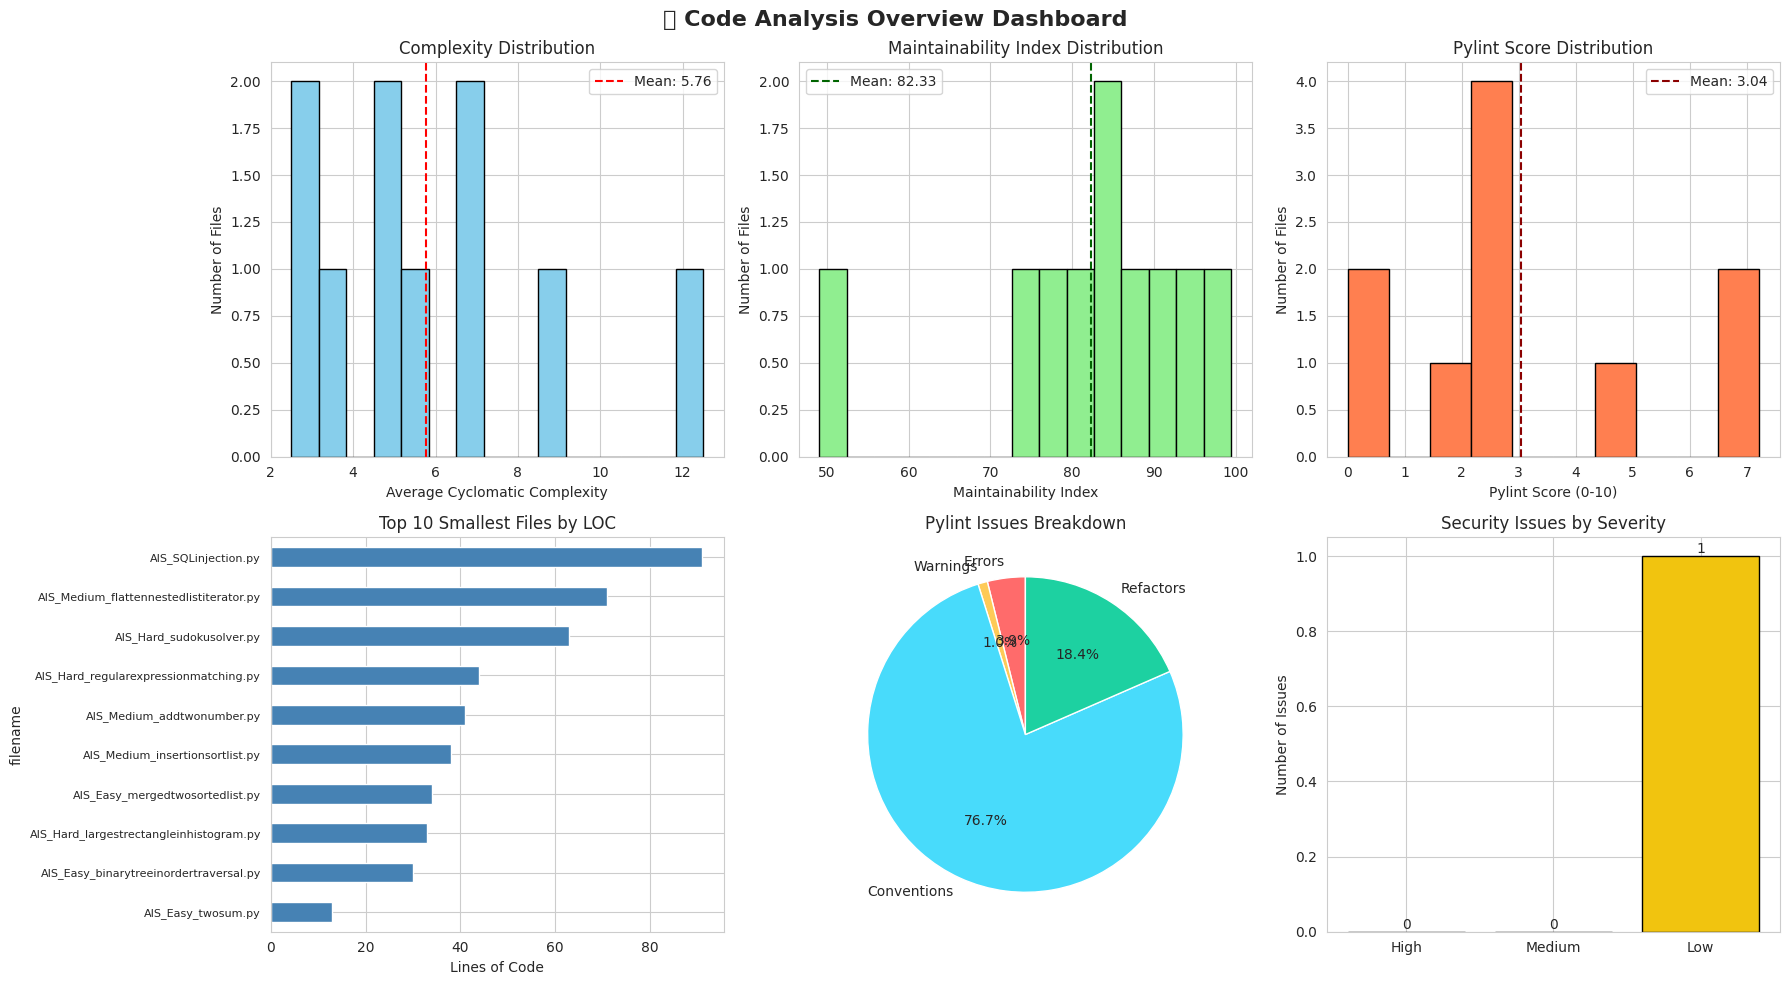

🔄 2. Creating Complexity Analysis...




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.


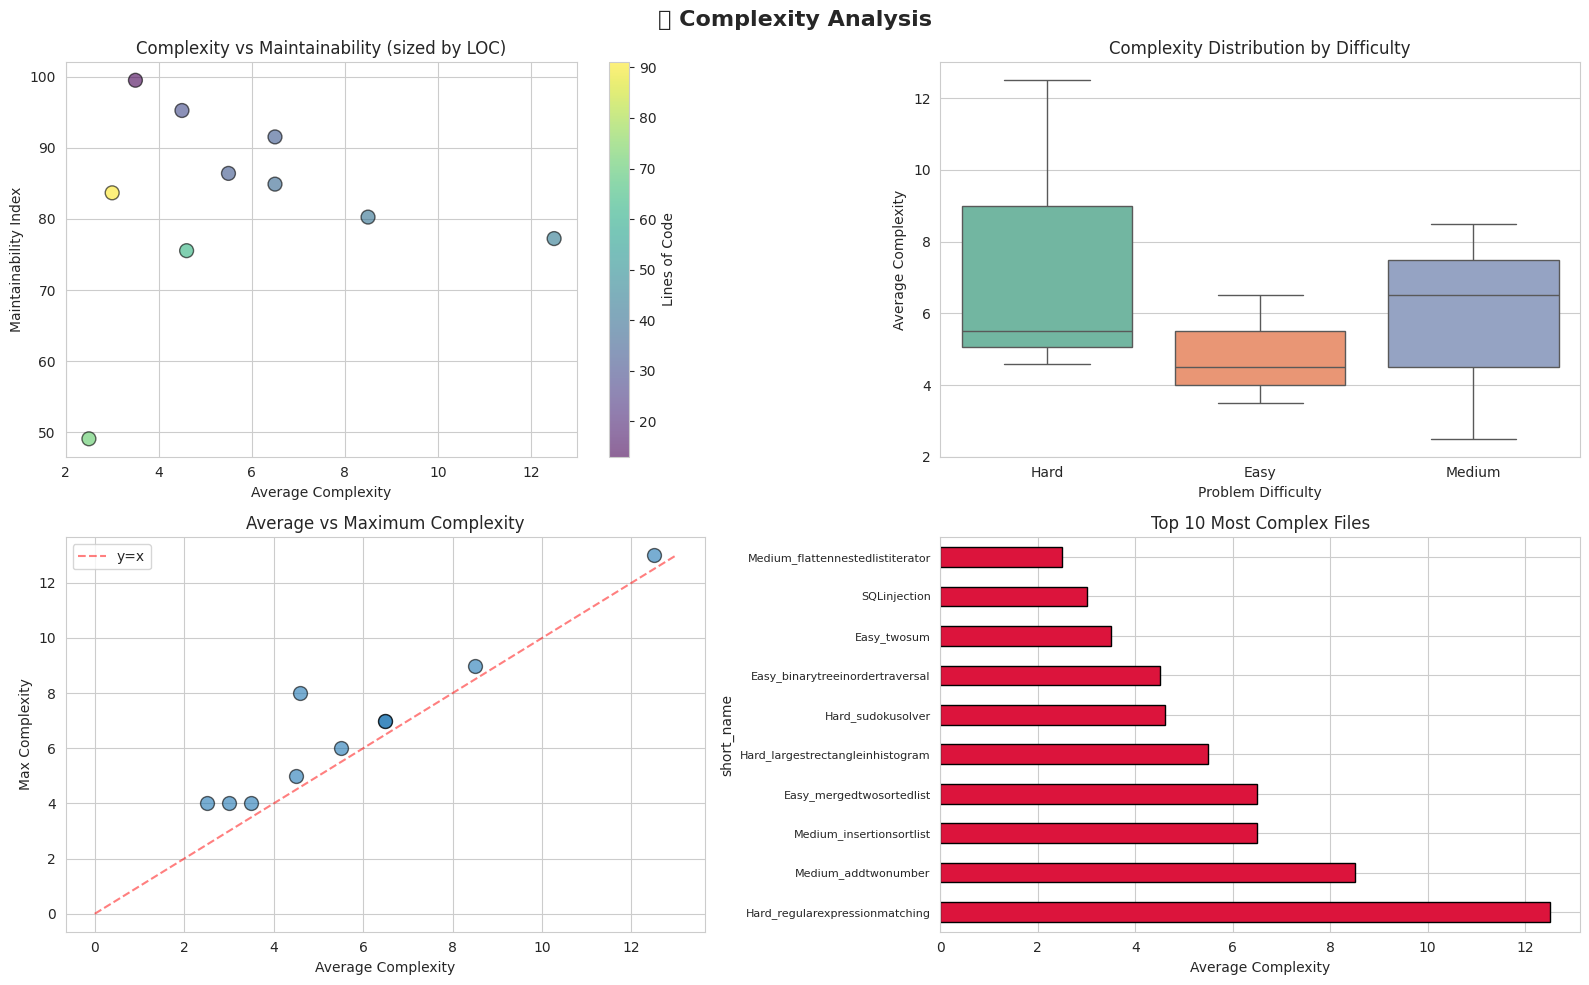

✨ 3. Creating Quality Metrics...


Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.


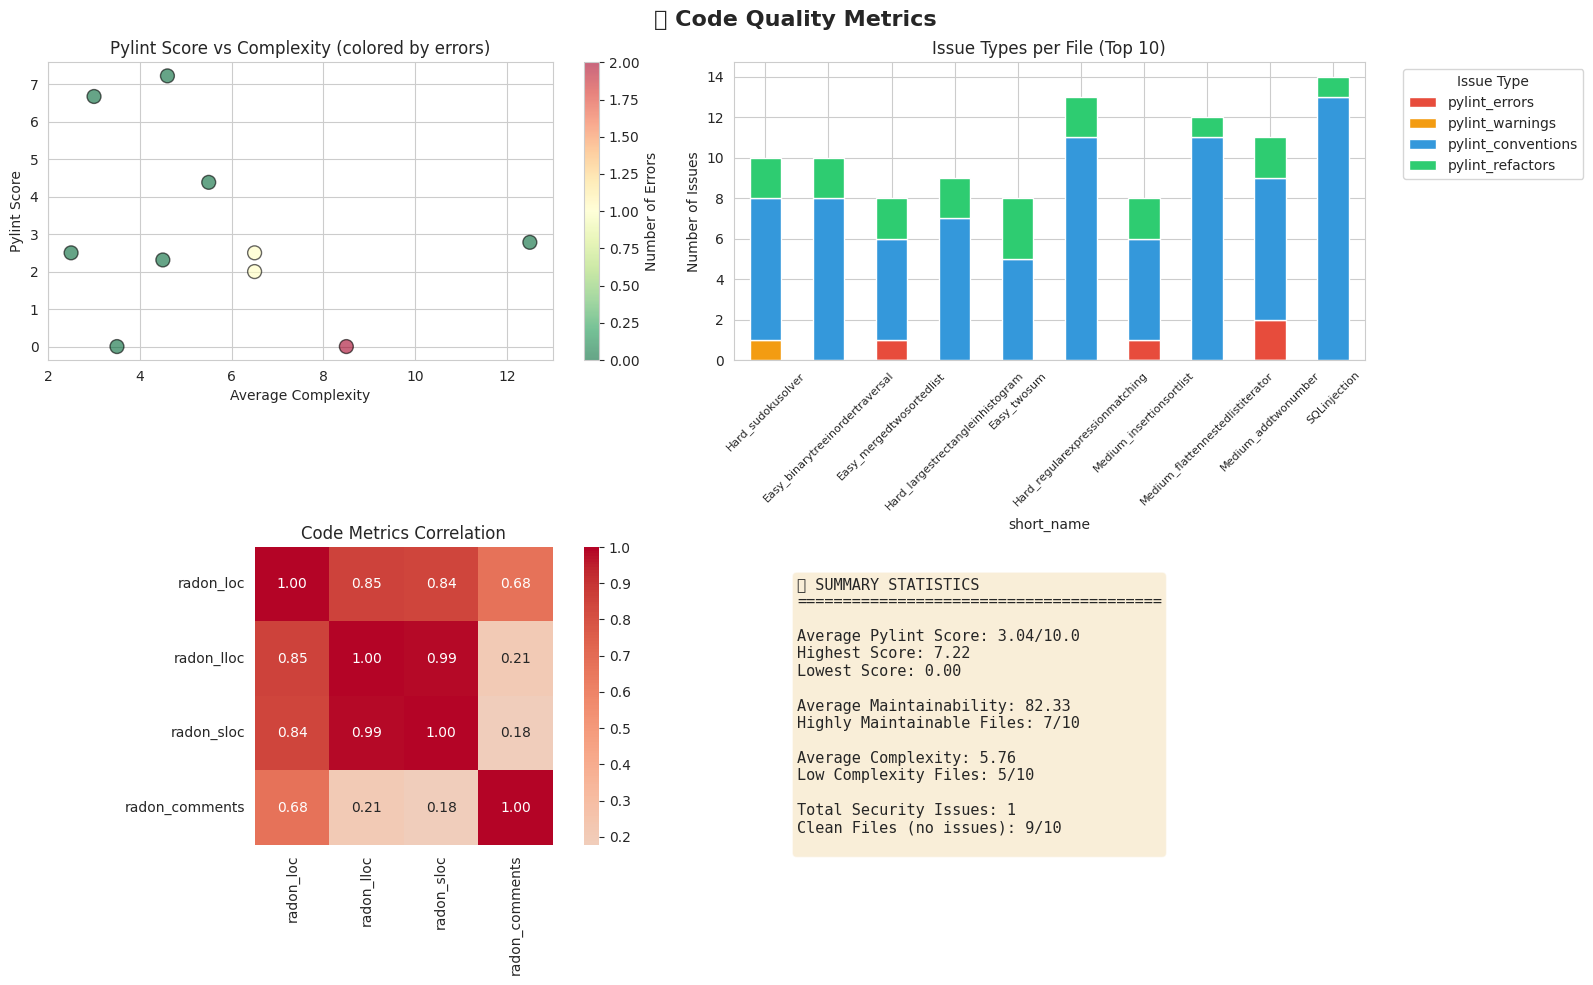

📁 4. Creating File Comparison...


Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.


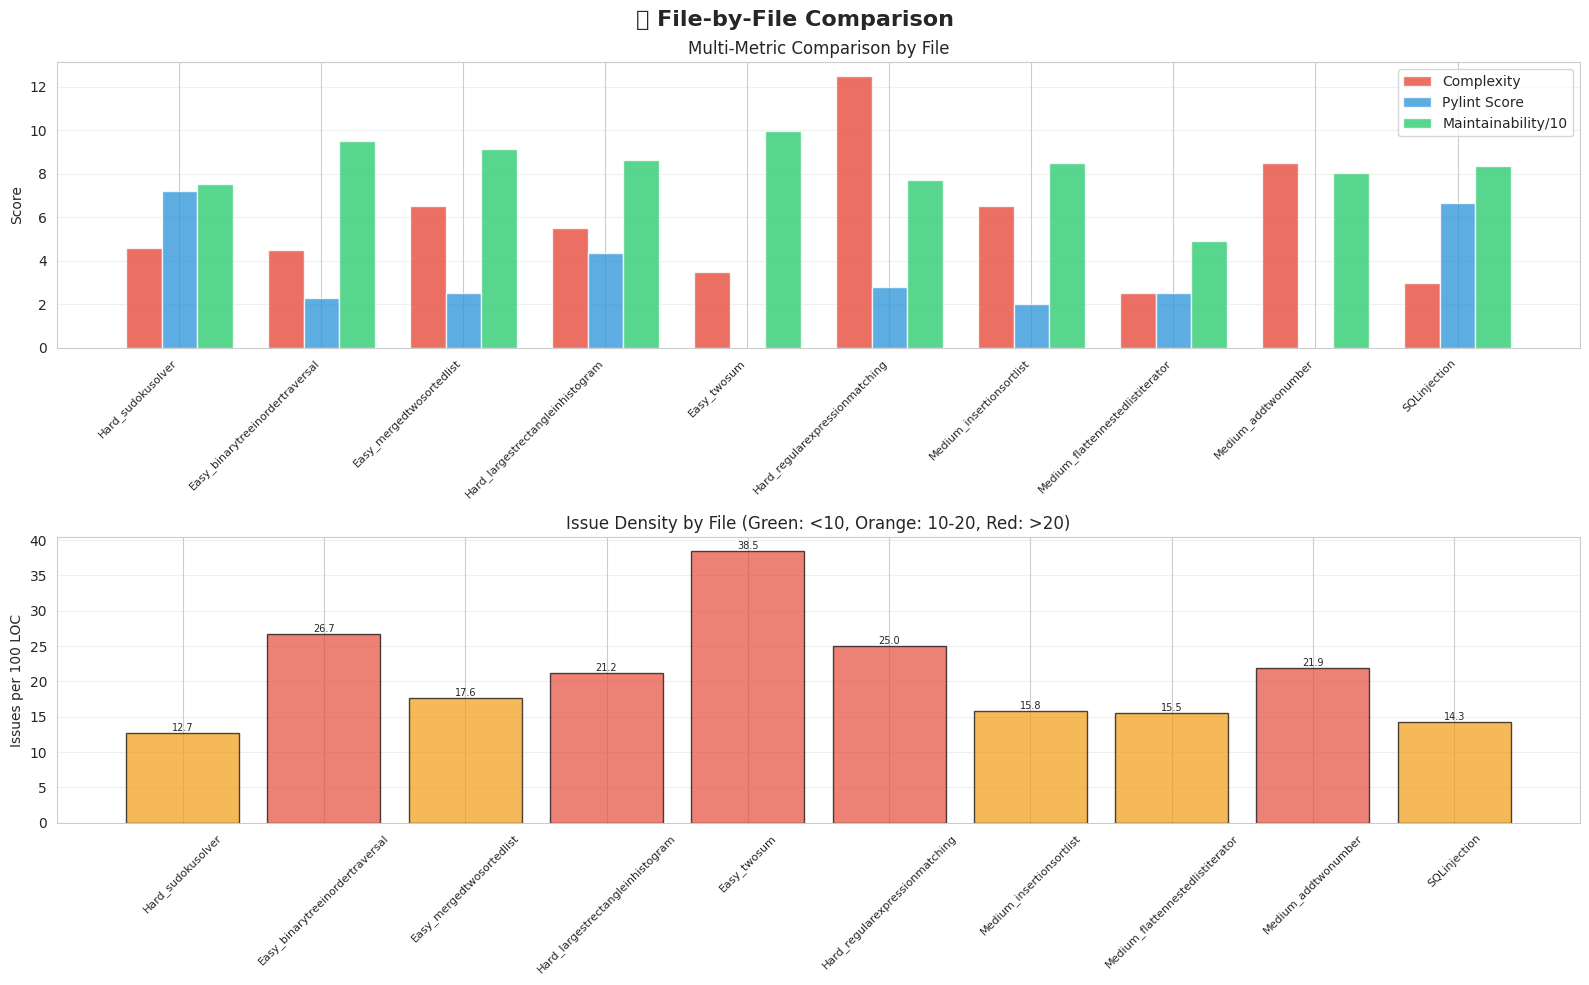

🔗 5. Creating Correlation Matrix...


Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.


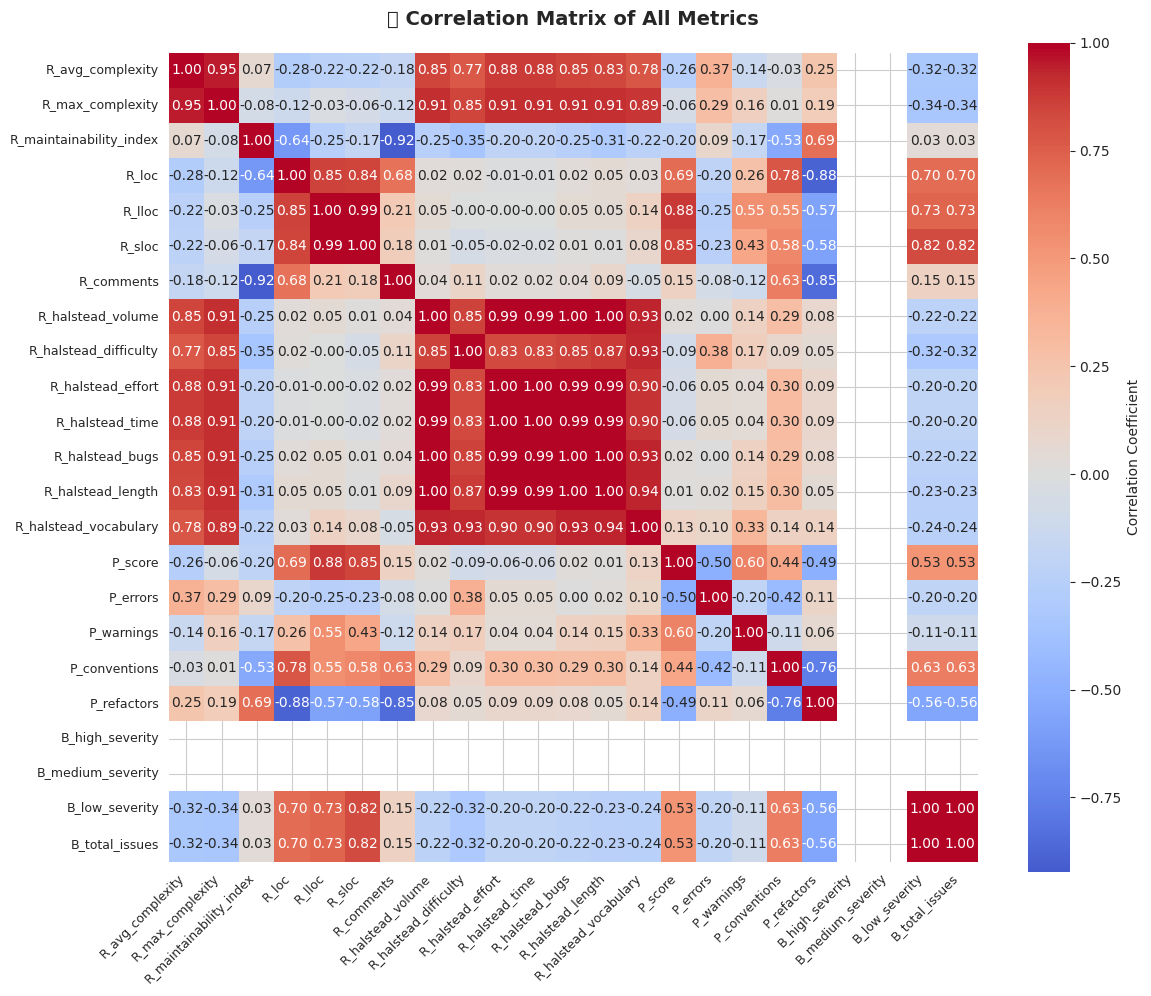


✅ All visualizations complete!

✓ Summary report exported to: analysis_summary.txt


In [ ]:
# @title
"""
Static Analysis Results Visualizer
Comprehensive visualization of Python code analysis results
Uses pandas, seaborn, and matplotlib
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Try to import Google Colab specific modules
try:
    from google.colab import files
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


class AnalysisVisualizer:
    """Visualize static analysis results from CSV"""

    def __init__(self, csv_file):
        """
        Initialize visualizer with CSV file

        Args:
            csv_file (str): Path to CSV file
        """
        self.csv_file = csv_file
        self.df = None
        self.load_data()

    def load_data(self):
        """Load and preprocess the CSV data"""
        try:
            self.df = pd.read_csv(self.csv_file)
            print(f"✓ Loaded {len(self.df)} files from {self.csv_file}")
            print(f"✓ Columns: {', '.join(self.df.columns[:5])}...")

            # Convert numeric columns
            numeric_cols = [
                'radon_avg_complexity', 'radon_max_complexity',
                'radon_maintainability_index', 'radon_loc', 'radon_lloc',
                'pylint_score', 'pylint_errors', 'pylint_warnings',
                'bandit_total_issues', 'bandit_high_severity'
            ]

            for col in numeric_cols:
                if col in self.df.columns:
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

            # Add difficulty category based on filename
            if 'filename' in self.df.columns:
                self.df['difficulty'] = self.df['filename'].str.extract(r'_(Easy|Medium|Hard)_')[0]
                self.df['difficulty'] = self.df['difficulty'].fillna('Unknown')

        except Exception as e:
            print(f"✗ Error loading CSV: {e}")
            raise

    def plot_overview_dashboard(self):
        """Create an overview dashboard with key metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('📊 Code Analysis Overview Dashboard', fontsize=16, fontweight='bold')

        # 1. Complexity Distribution
        ax = axes[0, 0]
        if 'radon_avg_complexity' in self.df.columns:
            self.df['radon_avg_complexity'].hist(bins=15, ax=ax, color='skyblue', edgecolor='black')
            ax.axvline(self.df['radon_avg_complexity'].mean(), color='red',
                      linestyle='--', label=f'Mean: {self.df["radon_avg_complexity"].mean():.2f}')
            ax.set_xlabel('Average Cyclomatic Complexity')
            ax.set_ylabel('Number of Files')
            ax.set_title('Complexity Distribution')
            ax.legend()

        # 2. Maintainability Index
        ax = axes[0, 1]
        if 'radon_maintainability_index' in self.df.columns:
            colors = self.df['radon_maintainability_index'].apply(
                lambda x: 'green' if x >= 80 else ('orange' if x >= 60 else 'red')
            )
            self.df['radon_maintainability_index'].hist(bins=15, ax=ax,
                                                         color='lightgreen', edgecolor='black')
            ax.axvline(self.df['radon_maintainability_index'].mean(), color='darkgreen',
                      linestyle='--', label=f'Mean: {self.df["radon_maintainability_index"].mean():.2f}')
            ax.set_xlabel('Maintainability Index')
            ax.set_ylabel('Number of Files')
            ax.set_title('Maintainability Index Distribution')
            ax.legend()

        # 3. Pylint Score Distribution
        ax = axes[0, 2]
        if 'pylint_score' in self.df.columns:
            self.df['pylint_score'].hist(bins=10, ax=ax, color='coral', edgecolor='black')
            ax.axvline(self.df['pylint_score'].mean(), color='darkred',
                      linestyle='--', label=f'Mean: {self.df["pylint_score"].mean():.2f}')
            ax.set_xlabel('Pylint Score (0-10)')
            ax.set_ylabel('Number of Files')
            ax.set_title('Pylint Score Distribution')
            ax.legend()

        # 4. Lines of Code
        ax = axes[1, 0]
        if 'radon_loc' in self.df.columns:
            self.df.nsmallest(10, 'radon_loc')[['filename', 'radon_loc']].set_index('filename')['radon_loc'].plot(
                kind='barh', ax=ax, color='steelblue'
            )
            ax.set_xlabel('Lines of Code')
            ax.set_title('Top 10 Smallest Files by LOC')
            ax.tick_params(axis='y', labelsize=8)

        # 5. Issue Types Breakdown
        ax = axes[1, 1]
        if all(col in self.df.columns for col in ['pylint_errors', 'pylint_warnings',
                                                    'pylint_conventions', 'pylint_refactors']):
            issue_sums = {
                'Errors': self.df['pylint_errors'].sum(),
                'Warnings': self.df['pylint_warnings'].sum(),
                'Conventions': self.df['pylint_conventions'].sum(),
                'Refactors': self.df['pylint_refactors'].sum()
            }
            colors_pie = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1']
            ax.pie(issue_sums.values(), labels=issue_sums.keys(), autopct='%1.1f%%',
                  colors=colors_pie, startangle=90)
            ax.set_title('Pylint Issues Breakdown')

        # 6. Security Issues
        ax = axes[1, 2]
        if all(col in self.df.columns for col in ['bandit_high_severity',
                                                    'bandit_medium_severity', 'bandit_low_severity']):
            security_data = {
                'High': self.df['bandit_high_severity'].sum(),
                'Medium': self.df['bandit_medium_severity'].sum(),
                'Low': self.df['bandit_low_severity'].sum()
            }
            bars = ax.bar(security_data.keys(), security_data.values(),
                         color=['#e74c3c', '#f39c12', '#f1c40f'], edgecolor='black')
            ax.set_ylabel('Number of Issues')
            ax.set_title('Security Issues by Severity')

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_complexity_analysis(self):
        """Detailed complexity analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('🔄 Complexity Analysis', fontsize=16, fontweight='bold')

        # 1. Complexity vs Maintainability
        ax = axes[0, 0]
        if all(col in self.df.columns for col in ['radon_avg_complexity', 'radon_maintainability_index']):
            scatter = ax.scatter(self.df['radon_avg_complexity'],
                               self.df['radon_maintainability_index'],
                               c=self.df['radon_loc'], cmap='viridis',
                               s=100, alpha=0.6, edgecolors='black')
            ax.set_xlabel('Average Complexity')
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Complexity vs Maintainability (sized by LOC)')
            plt.colorbar(scatter, ax=ax, label='Lines of Code')

        # 2. Complexity by Difficulty
        ax = axes[0, 1]
        if 'difficulty' in self.df.columns and 'radon_avg_complexity' in self.df.columns:
            df_filtered = self.df[self.df['difficulty'] != 'Unknown']
            if not df_filtered.empty:
                sns.boxplot(data=df_filtered, x='difficulty', y='radon_avg_complexity',
                           ax=ax, palette='Set2')
                ax.set_xlabel('Problem Difficulty')
                ax.set_ylabel('Average Complexity')
                ax.set_title('Complexity Distribution by Difficulty')

        # 3. Max vs Avg Complexity
        ax = axes[1, 0]
        if all(col in self.df.columns for col in ['radon_avg_complexity', 'radon_max_complexity']):
            ax.scatter(self.df['radon_avg_complexity'], self.df['radon_max_complexity'],
                      alpha=0.6, s=100, edgecolors='black')

            # Add diagonal reference line
            max_val = max(self.df['radon_max_complexity'].max(), self.df['radon_avg_complexity'].max())
            ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')

            ax.set_xlabel('Average Complexity')
            ax.set_ylabel('Max Complexity')
            ax.set_title('Average vs Maximum Complexity')
            ax.legend()

        # 4. Top Complex Files
        ax = axes[1, 1]
        if 'radon_avg_complexity' in self.df.columns:
            top_complex = self.df.nlargest(10, 'radon_avg_complexity')[['filename', 'radon_avg_complexity']]
            top_complex['short_name'] = top_complex['filename'].str.replace('AIS_', '').str.replace('.py', '')
            top_complex.set_index('short_name')['radon_avg_complexity'].plot(
                kind='barh', ax=ax, color='crimson', edgecolor='black'
            )
            ax.set_xlabel('Average Complexity')
            ax.set_title('Top 10 Most Complex Files')
            ax.tick_params(axis='y', labelsize=8)

        plt.tight_layout()
        plt.show()

    def plot_quality_metrics(self):
        """Analyze code quality metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('✨ Code Quality Metrics', fontsize=16, fontweight='bold')

        # 1. Pylint Score vs Complexity
        ax = axes[0, 0]
        if all(col in self.df.columns for col in ['pylint_score', 'radon_avg_complexity']):
            scatter = ax.scatter(self.df['radon_avg_complexity'], self.df['pylint_score'],
                               s=100, alpha=0.6, c=self.df['pylint_errors'],
                               cmap='RdYlGn_r', edgecolors='black')
            ax.set_xlabel('Average Complexity')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Pylint Score vs Complexity (colored by errors)')
            plt.colorbar(scatter, ax=ax, label='Number of Errors')

        # 2. Issues per File
        ax = axes[0, 1]
        if all(col in self.df.columns for col in ['pylint_errors', 'pylint_warnings',
                                                    'pylint_conventions', 'pylint_refactors']):
            issues_df = self.df[['filename', 'pylint_errors', 'pylint_warnings',
                                'pylint_conventions', 'pylint_refactors']].copy()
            issues_df['short_name'] = issues_df['filename'].str.replace('AIS_', '').str.replace('.py', '')
            issues_df = issues_df.set_index('short_name')[['pylint_errors', 'pylint_warnings',
                                                            'pylint_conventions', 'pylint_refactors']]
            issues_df.head(10).plot(kind='bar', stacked=True, ax=ax,
                                   color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
            ax.set_ylabel('Number of Issues')
            ax.set_title('Issue Types per File (Top 10)')
            ax.legend(title='Issue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.tick_params(axis='x', rotation=45, labelsize=8)

        # 3. Code Metrics Heatmap
        ax = axes[1, 0]
        if all(col in self.df.columns for col in ['radon_loc', 'radon_lloc',
                                                    'radon_sloc', 'radon_comments']):
            metrics = self.df[['radon_loc', 'radon_lloc', 'radon_sloc', 'radon_comments']].corr()
            sns.heatmap(metrics, annot=True, fmt='.2f', cmap='coolwarm',
                       center=0, ax=ax, square=True)
            ax.set_title('Code Metrics Correlation')

        # 4. Quality Score Card
        ax = axes[1, 1]
        ax.axis('off')

        # Calculate summary statistics
        stats_text = "📈 SUMMARY STATISTICS\n" + "="*40 + "\n\n"

        if 'pylint_score' in self.df.columns:
            avg_pylint = self.df['pylint_score'].mean()
            stats_text += f"Average Pylint Score: {avg_pylint:.2f}/10.0\n"
            stats_text += f"Highest Score: {self.df['pylint_score'].max():.2f}\n"
            stats_text += f"Lowest Score: {self.df['pylint_score'].min():.2f}\n\n"

        if 'radon_maintainability_index' in self.df.columns:
            avg_mi = self.df['radon_maintainability_index'].mean()
            stats_text += f"Average Maintainability: {avg_mi:.2f}\n"
            high_mi = (self.df['radon_maintainability_index'] >= 80).sum()
            stats_text += f"Highly Maintainable Files: {high_mi}/{len(self.df)}\n\n"

        if 'radon_avg_complexity' in self.df.columns:
            avg_complexity = self.df['radon_avg_complexity'].mean()
            stats_text += f"Average Complexity: {avg_complexity:.2f}\n"
            low_complex = (self.df['radon_avg_complexity'] <= 5).sum()
            stats_text += f"Low Complexity Files: {low_complex}/{len(self.df)}\n\n"

        if 'bandit_total_issues' in self.df.columns:
            total_security = self.df['bandit_total_issues'].sum()
            stats_text += f"Total Security Issues: {int(total_security)}\n"
            clean_files = (self.df['bandit_total_issues'] == 0).sum()
            stats_text += f"Clean Files (no issues): {clean_files}/{len(self.df)}\n"

        ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
               fontsize=11, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_file_comparison(self):
        """Compare all files across multiple dimensions"""
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        fig.suptitle('📁 File-by-File Comparison', fontsize=16, fontweight='bold')

        # Prepare data
        df_plot = self.df.copy()
        df_plot['short_name'] = df_plot['filename'].str.replace('AIS_', '').str.replace('.py', '')

        # 1. Multi-metric comparison
        ax = axes[0]
        if all(col in df_plot.columns for col in ['radon_avg_complexity', 'pylint_score',
                                                    'radon_maintainability_index']):
            x = np.arange(len(df_plot))
            width = 0.25

            # Normalize scores for comparison (all to 0-10 scale)
            complexity_norm = df_plot['radon_avg_complexity']
            pylint_norm = df_plot['pylint_score']
            maintainability_norm = df_plot['radon_maintainability_index'] / 10

            ax.bar(x - width, complexity_norm, width, label='Complexity', color='#e74c3c', alpha=0.8)
            ax.bar(x, pylint_norm, width, label='Pylint Score', color='#3498db', alpha=0.8)
            ax.bar(x + width, maintainability_norm, width, label='Maintainability/10',
                  color='#2ecc71', alpha=0.8)

            ax.set_ylabel('Score')
            ax.set_title('Multi-Metric Comparison by File')
            ax.set_xticks(x)
            ax.set_xticklabels(df_plot['short_name'], rotation=45, ha='right', fontsize=8)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

        # 2. Issue density (issues per 100 LOC)
        ax = axes[1]
        if all(col in df_plot.columns for col in ['pylint_errors', 'pylint_warnings',
                                                    'pylint_conventions', 'radon_loc']):
            df_plot['total_issues'] = (df_plot['pylint_errors'] + df_plot['pylint_warnings'] +
                                       df_plot['pylint_conventions'])
            df_plot['issue_density'] = (df_plot['total_issues'] / df_plot['radon_loc'] * 100).round(2)

            colors_map = df_plot['issue_density'].apply(
                lambda x: '#2ecc71' if x < 10 else ('#f39c12' if x < 20 else '#e74c3c')
            )

            bars = ax.bar(df_plot['short_name'], df_plot['issue_density'],
                         color=colors_map, edgecolor='black', alpha=0.7)
            ax.set_ylabel('Issues per 100 LOC')
            ax.set_title('Issue Density by File (Green: <10, Orange: 10-20, Red: >20)')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.grid(axis='y', alpha=0.3)

            # Add value labels on top of bars
            for i, (bar, val) in enumerate(zip(bars, df_plot['issue_density'])):
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{val:.1f}', ha='center', va='bottom', fontsize=7)

        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self):
        """Plot correlation matrix of all numeric metrics"""
        fig, ax = plt.subplots(figsize=(12, 10))

        # Select numeric columns
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col not in ['Unnamed: 0']]

        if len(numeric_cols) > 2:
            correlation_matrix = self.df[numeric_cols].corr()

            # Create custom labels (shorten column names)
            labels = [col.replace('radon_', 'R_').replace('pylint_', 'P_').replace('bandit_', 'B_')
                     for col in numeric_cols]

            sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                       center=0, square=True, ax=ax, xticklabels=labels, yticklabels=labels,
                       cbar_kws={'label': 'Correlation Coefficient'})

            ax.set_title('🔗 Correlation Matrix of All Metrics', fontsize=14, fontweight='bold', pad=20)
            plt.xticks(rotation=45, ha='right', fontsize=9)
            plt.yticks(rotation=0, fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough numeric columns for correlation matrix")

    def generate_all_plots(self):
        """Generate all visualization plots"""
        print("\n" + "="*70)
        print("🎨 GENERATING VISUALIZATIONS")
        print("="*70 + "\n")

        print("📊 1. Creating Overview Dashboard...")
        self.plot_overview_dashboard()

        print("🔄 2. Creating Complexity Analysis...")
        self.plot_complexity_analysis()

        print("✨ 3. Creating Quality Metrics...")
        self.plot_quality_metrics()

        print("📁 4. Creating File Comparison...")
        self.plot_file_comparison()

        print("🔗 5. Creating Correlation Matrix...")
        self.plot_correlation_matrix()

        print("\n" + "="*70)
        print("✅ All visualizations complete!")
        print("="*70)

    def export_summary_report(self, output_file='analysis_summary.txt'):
        """Export a text summary report"""
        with open(output_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("STATIC ANALYSIS SUMMARY REPORT\n")
            f.write("="*70 + "\n\n")

            f.write(f"Total Files Analyzed: {len(self.df)}\n\n")

            # Complexity metrics
            f.write("COMPLEXITY METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_avg_complexity' in self.df.columns:
                f.write(f"Average Complexity: {self.df['radon_avg_complexity'].mean():.2f}\n")
                f.write(f"Max Complexity: {self.df['radon_max_complexity'].max():.2f}\n")

            if 'radon_maintainability_index' in self.df.columns:
                f.write(f"Average Maintainability Index: {self.df['radon_maintainability_index'].mean():.2f}\n\n")

            # Code quality
            f.write("CODE QUALITY (PYLINT):\n")
            f.write("-" * 50 + "\n")
            if 'pylint_score' in self.df.columns:
                f.write(f"Average Pylint Score: {self.df['pylint_score'].mean():.2f}/10.0\n")
                f.write(f"Total Errors: {self.df['pylint_errors'].sum()}\n")
                f.write(f"Total Warnings: {self.df['pylint_warnings'].sum()}\n")
                f.write(f"Total Conventions: {self.df['pylint_conventions'].sum()}\n\n")

            # Security
            f.write("SECURITY (BANDIT):\n")
            f.write("-" * 50 + "\n")
            if 'bandit_total_issues' in self.df.columns:
                f.write(f"Total Security Issues: {self.df['bandit_total_issues'].sum()}\n")
                f.write(f"High Severity: {self.df['bandit_high_severity'].sum()}\n")
                f.write(f"Medium Severity: {self.df['bandit_medium_severity'].sum()}\n")
                f.write(f"Low Severity: {self.df['bandit_low_severity'].sum()}\n\n")

            # Top issues
            f.write("TOP 5 MOST COMPLEX FILES:\n")
            f.write("-" * 50 + "\n")
            if 'radon_avg_complexity' in self.df.columns:
                top_complex = self.df.nlargest(5, 'radon_avg_complexity')[['filename', 'radon_avg_complexity']]
                for idx, row in top_complex.iterrows():
                    f.write(f"{row['filename']}: {row['radon_avg_complexity']:.2f}\n")

        print(f"\n✓ Summary report exported to: {output_file}")


def visualize_analysis(csv_file='analysis_results.csv'):
    """
    Main function to visualize analysis results

    Args:
        csv_file (str): Path to the CSV file from static analysis
    """
    # Handle file upload in Colab
    if COLAB_ENV and not Path(csv_file).exists():
        print("📤 Please upload your analysis CSV file")
        uploaded = files.upload()
        if uploaded:
            csv_file = list(uploaded.keys())[0]

    # Create visualizer and generate plots
    viz = AnalysisVisualizer(csv_file)
    viz.generate_all_plots()
    viz.export_summary_report()

    return viz


# Main execution
if __name__ == "__main__":
    # For Colab: will prompt for file upload
    # For local: uses default or command line argument
    import sys

    if len(sys.argv) > 1:
        csv_file = sys.argv[1]
    else:
        csv_file = 'analysis_results.csv'

    visualize_analysis(csv_file)

1.1

📤 Please upload your analysis CSV file


Saving analysis_results.csv to analysis_results (2).csv
✓ Loaded 10 files from analysis_results (2).csv
✓ Columns: 27 metrics tracked

🎨 GENERATING VISUALIZATIONS

📊 1. Creating Overview Dashboard...


Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.


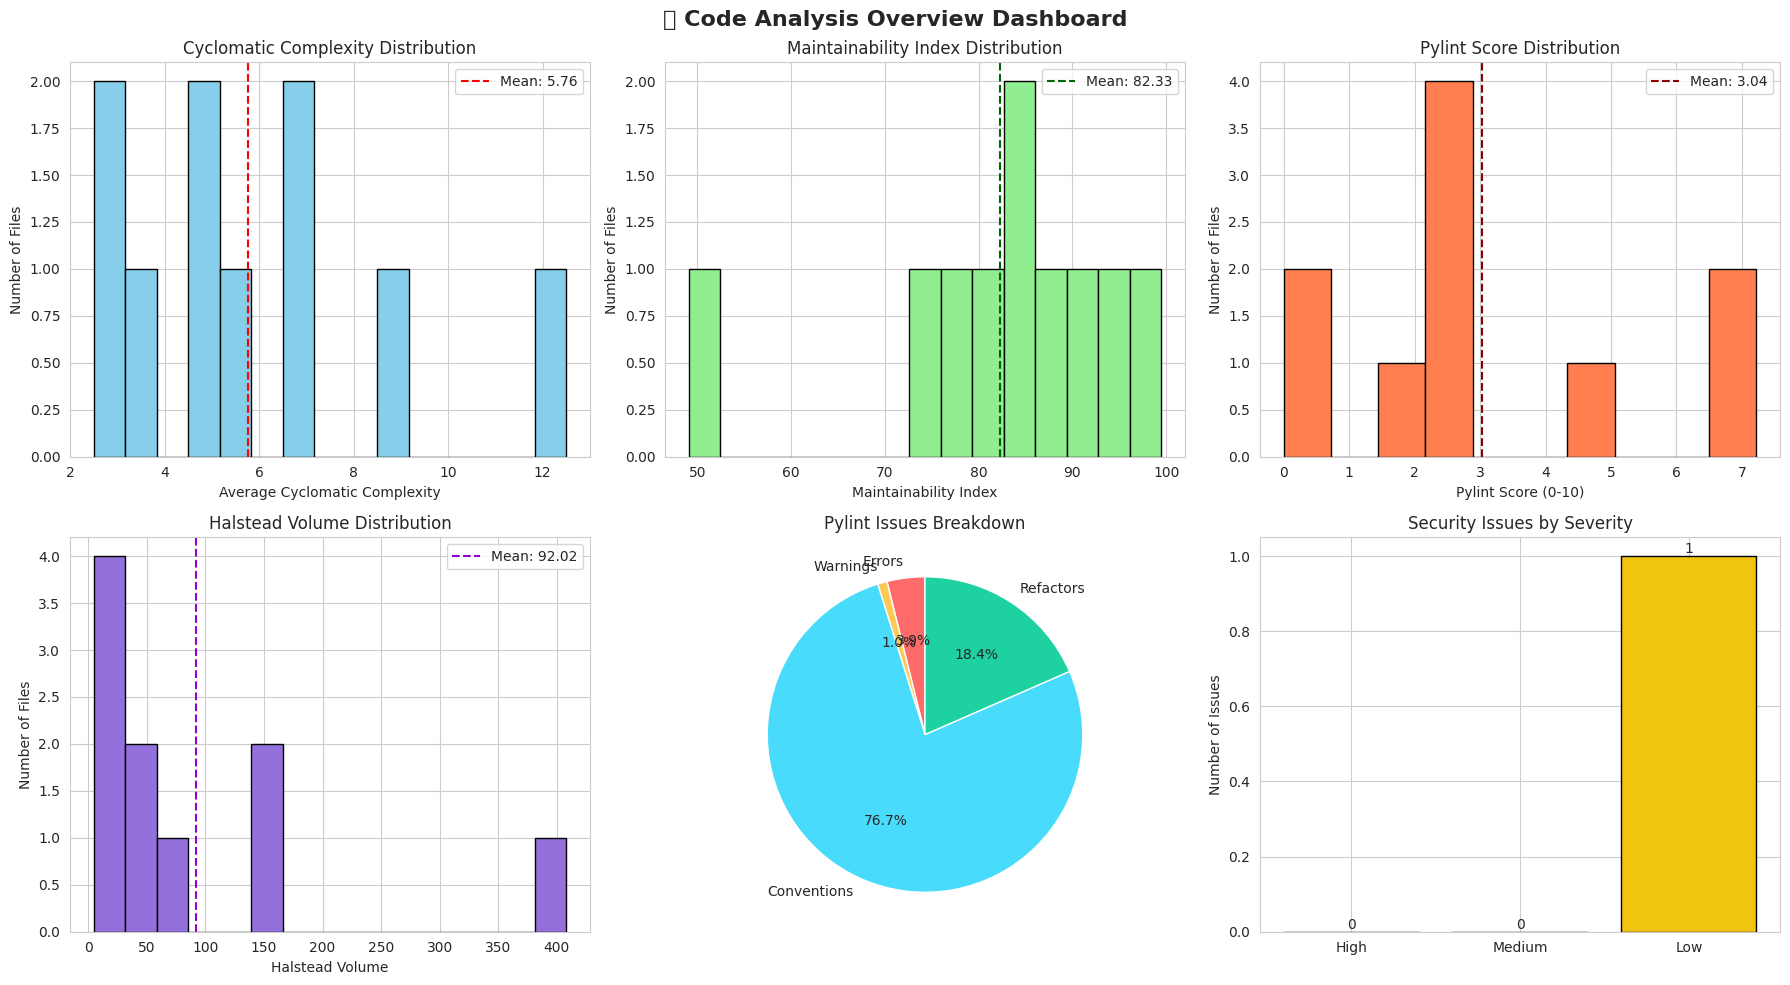



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



📐 2. Creating Halstead Analysis...


Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.


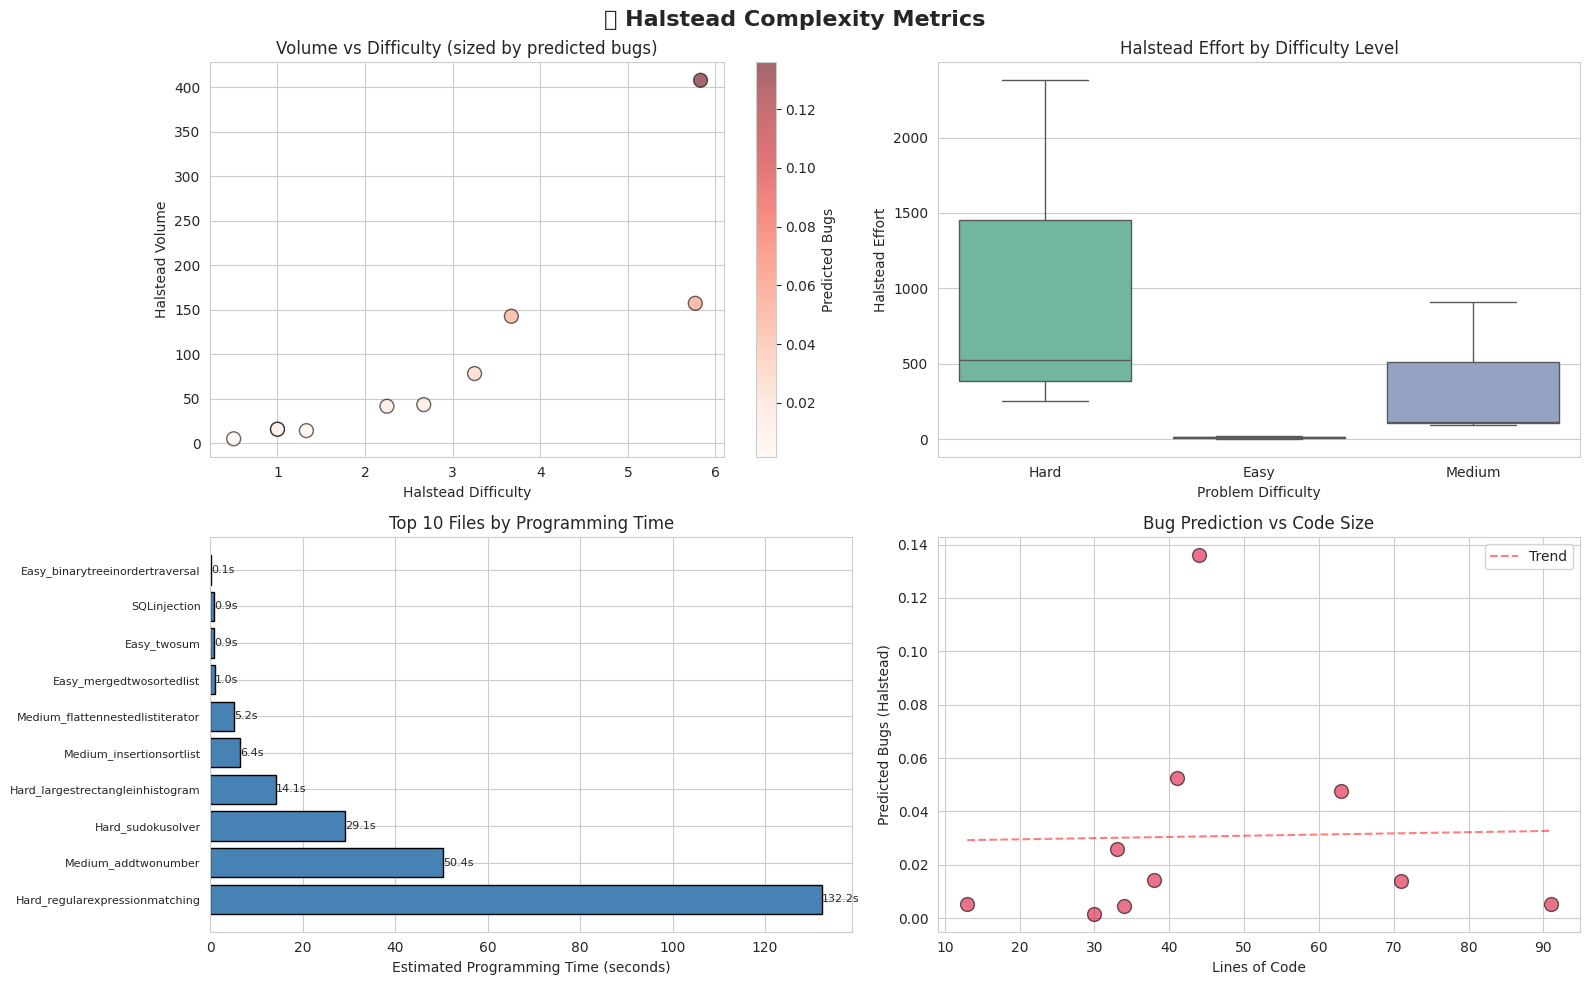



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



🔄 3. Creating Complexity Analysis...


Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.


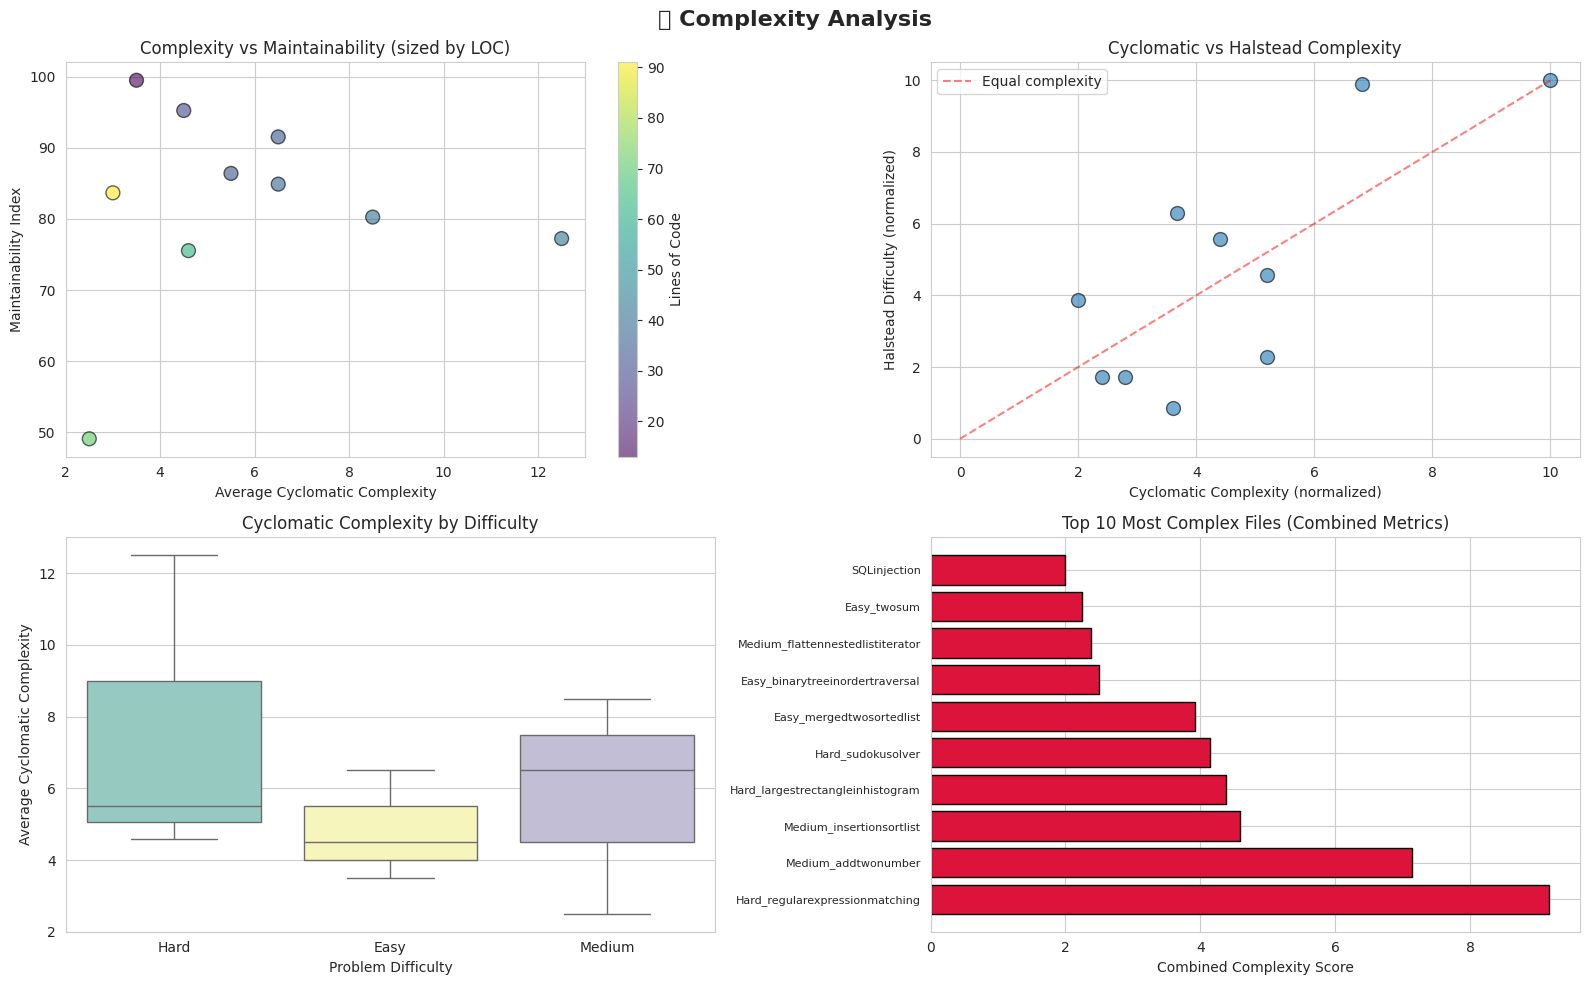

✨ 4. Creating Quality Metrics...


Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.


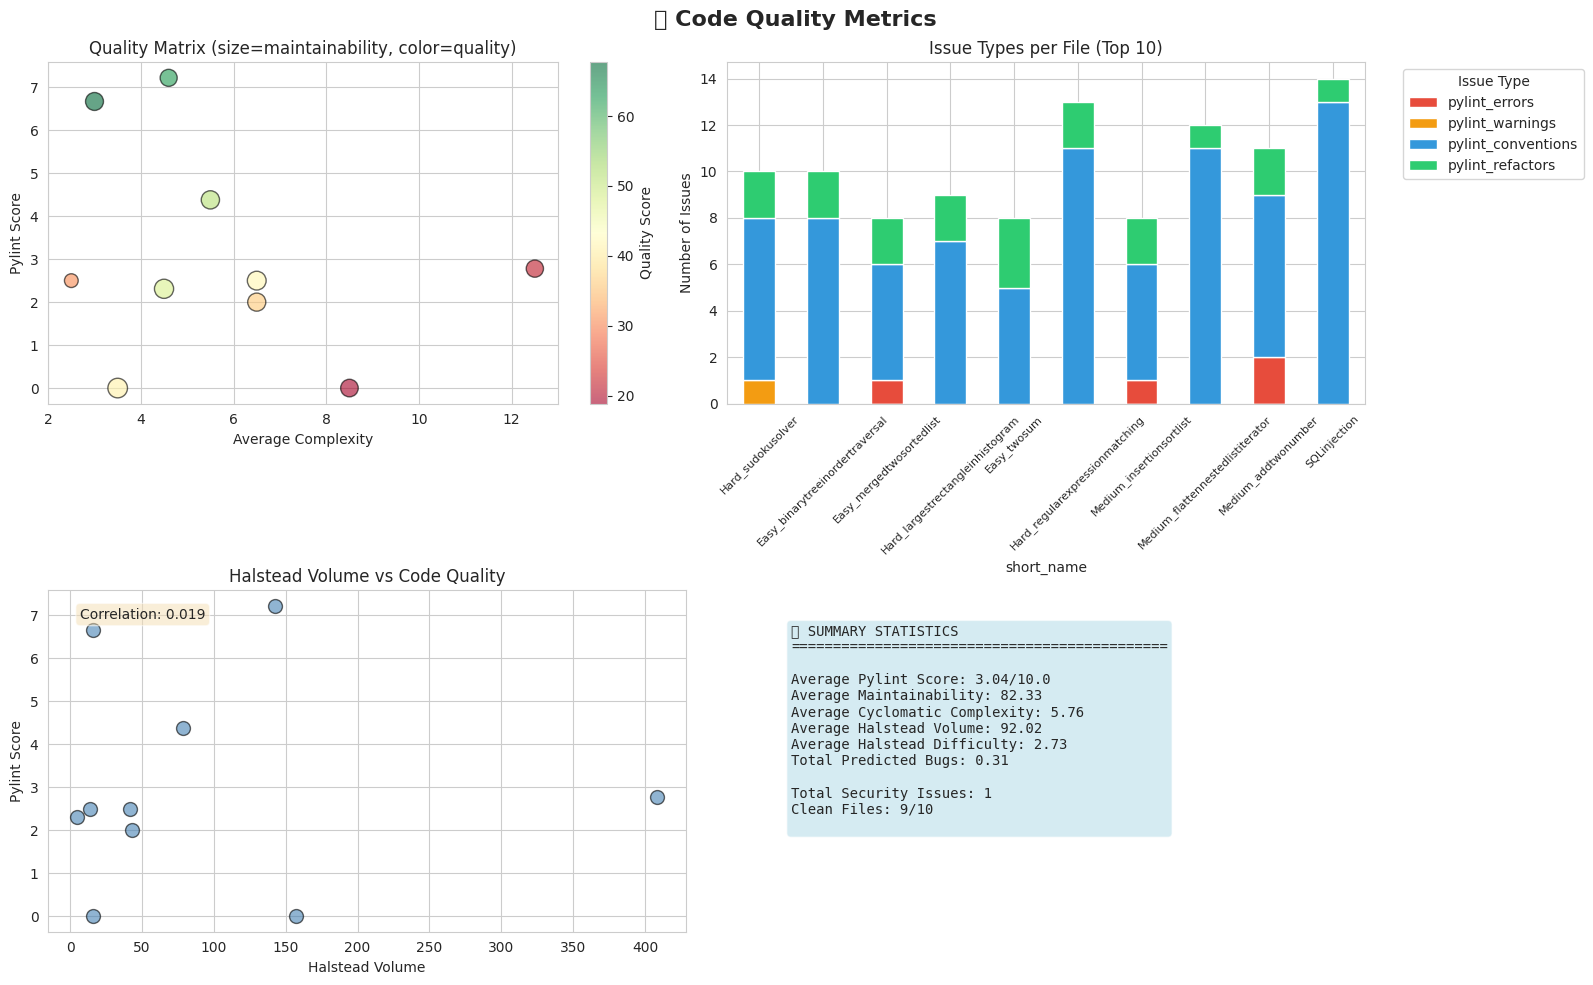

📁 5. Creating File Comparison...


Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.


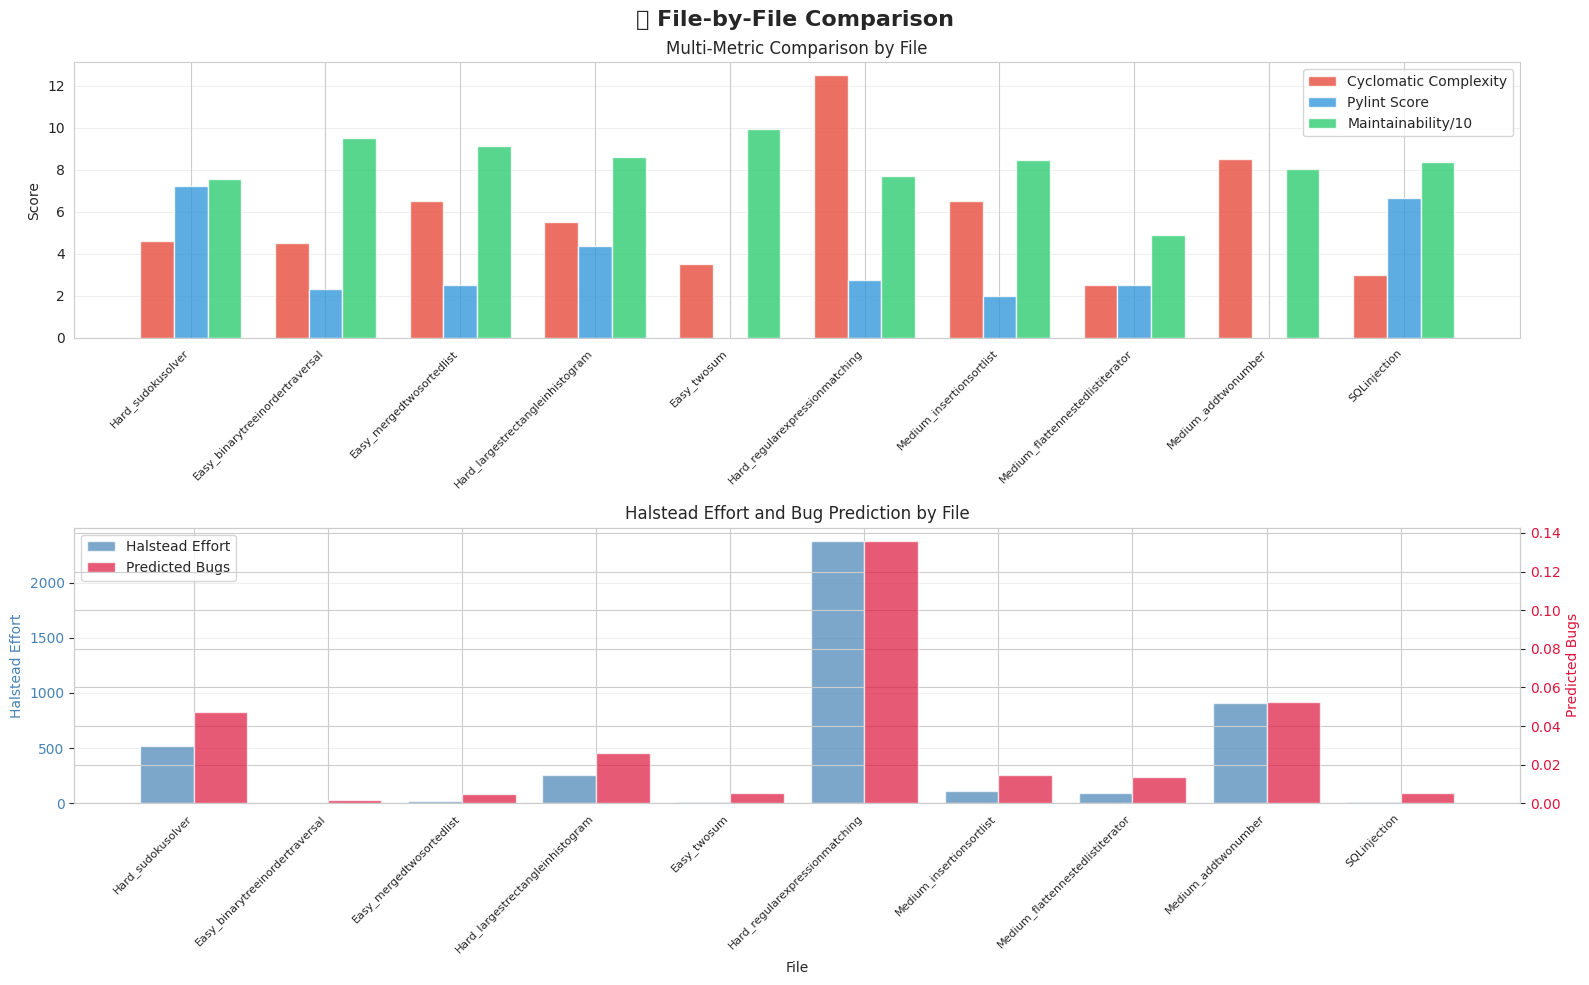

🔗 6. Creating Correlation Matrix...


Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.


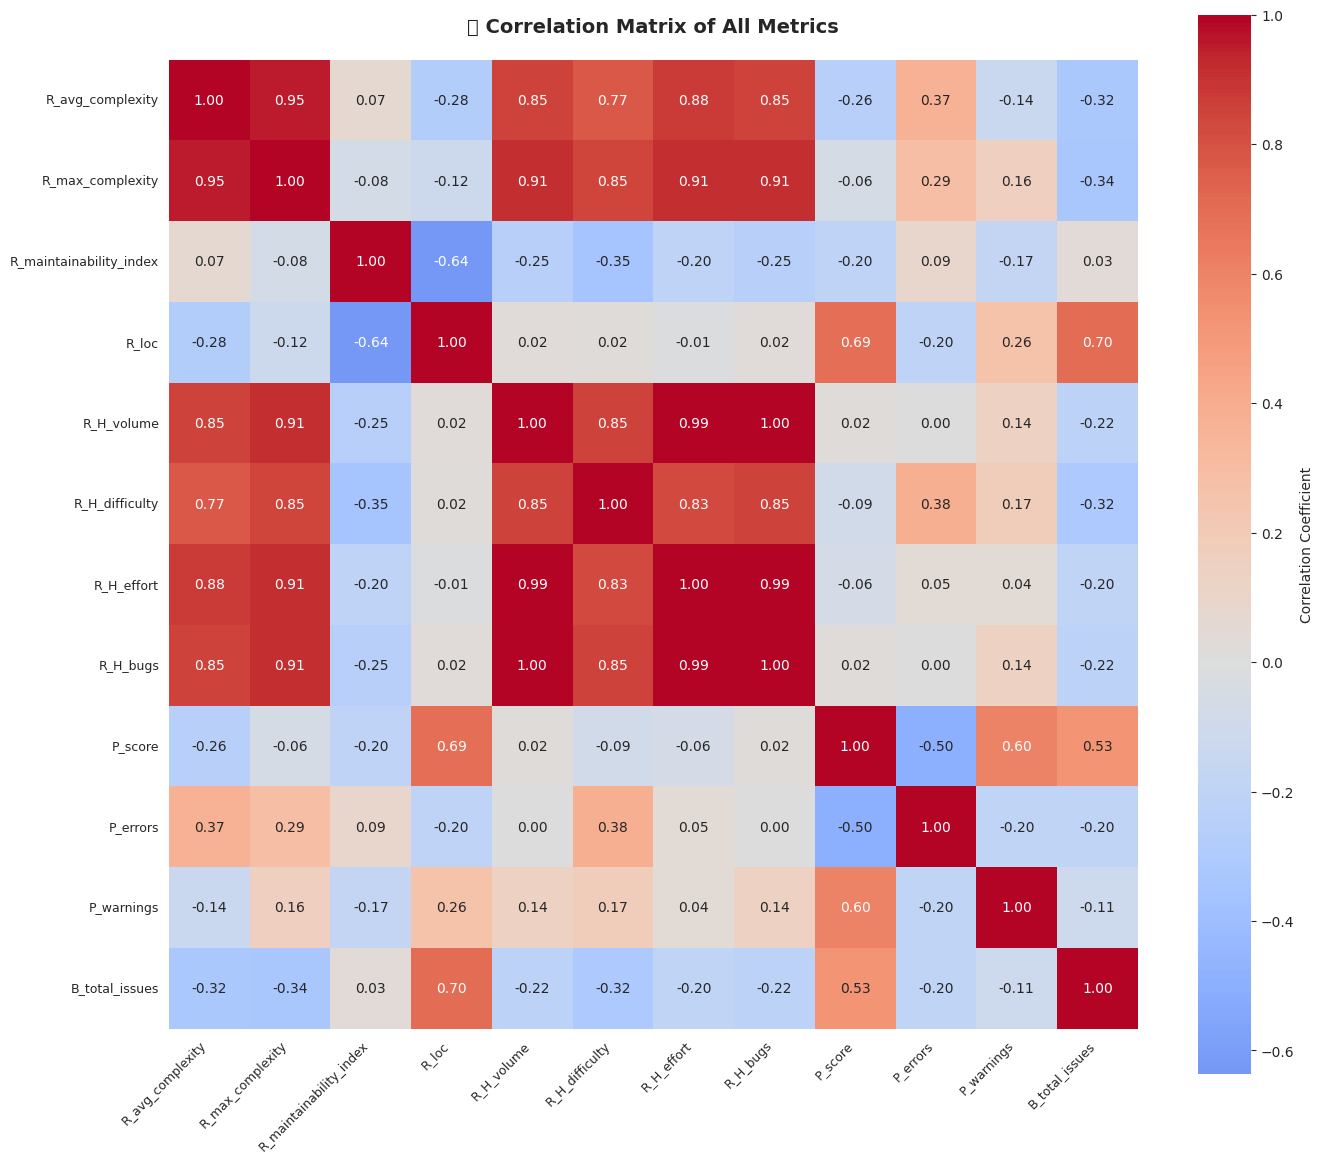


✅ All visualizations complete!

✓ Summary report exported to: analysis_summary.txt


In [ ]:
# @title
"""
Static Analysis Results Visualizer - Updated Version
Comprehensive visualization of Python code analysis results
Includes Halstead complexity metrics
Uses pandas, seaborn, and matplotlib
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Try to import Google Colab specific modules
try:
    from google.colab import files
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


class AnalysisVisualizer:
    """Visualize static analysis results from CSV"""

    def __init__(self, csv_file):
        """
        Initialize visualizer with CSV file

        Args:
            csv_file (str): Path to CSV file
        """
        self.csv_file = csv_file
        self.df = None
        self.load_data()

    def load_data(self):
        """Load and preprocess the CSV data"""
        try:
            self.df = pd.read_csv(self.csv_file)
            print(f"✓ Loaded {len(self.df)} files from {self.csv_file}")
            print(f"✓ Columns: {len(self.df.columns)} metrics tracked")

            # Convert numeric columns
            numeric_cols = [
                'radon_avg_complexity', 'radon_max_complexity',
                'radon_maintainability_index', 'radon_loc', 'radon_lloc',
                'radon_halstead_volume', 'radon_halstead_difficulty',
                'radon_halstead_effort', 'radon_halstead_time', 'radon_halstead_bugs',
                'radon_halstead_length', 'radon_halstead_vocabulary',
                'pylint_score', 'pylint_errors', 'pylint_warnings',
                'bandit_total_issues', 'bandit_high_severity'
            ]

            for col in numeric_cols:
                if col in self.df.columns:
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

            # Add difficulty category based on filename
            if 'filename' in self.df.columns:
                self.df['difficulty'] = self.df['filename'].str.extract(r'_(Easy|Medium|Hard)_')[0]
                self.df['difficulty'] = self.df['difficulty'].fillna('Other')

        except Exception as e:
            print(f"✗ Error loading CSV: {e}")
            raise

    def plot_overview_dashboard(self):
        """Create an overview dashboard with key metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('📊 Code Analysis Overview Dashboard', fontsize=16, fontweight='bold')

        # 1. Complexity Distribution
        ax = axes[0, 0]
        if 'radon_avg_complexity' in self.df.columns:
            self.df['radon_avg_complexity'].hist(bins=15, ax=ax, color='skyblue', edgecolor='black')
            ax.axvline(self.df['radon_avg_complexity'].mean(), color='red',
                      linestyle='--', label=f'Mean: {self.df["radon_avg_complexity"].mean():.2f}')
            ax.set_xlabel('Average Cyclomatic Complexity')
            ax.set_ylabel('Number of Files')
            ax.set_title('Cyclomatic Complexity Distribution')
            ax.legend()

        # 2. Maintainability Index
        ax = axes[0, 1]
        if 'radon_maintainability_index' in self.df.columns:
            colors = self.df['radon_maintainability_index'].apply(
                lambda x: 'green' if x >= 80 else ('orange' if x >= 60 else 'red')
            )
            self.df['radon_maintainability_index'].hist(bins=15, ax=ax,
                                                         color='lightgreen', edgecolor='black')
            ax.axvline(self.df['radon_maintainability_index'].mean(), color='darkgreen',
                      linestyle='--', label=f'Mean: {self.df["radon_maintainability_index"].mean():.2f}')
            ax.set_xlabel('Maintainability Index')
            ax.set_ylabel('Number of Files')
            ax.set_title('Maintainability Index Distribution')
            ax.legend()

        # 3. Pylint Score Distribution
        ax = axes[0, 2]
        if 'pylint_score' in self.df.columns:
            self.df['pylint_score'].hist(bins=10, ax=ax, color='coral', edgecolor='black')
            ax.axvline(self.df['pylint_score'].mean(), color='darkred',
                      linestyle='--', label=f'Mean: {self.df["pylint_score"].mean():.2f}')
            ax.set_xlabel('Pylint Score (0-10)')
            ax.set_ylabel('Number of Files')
            ax.set_title('Pylint Score Distribution')
            ax.legend()

        # 4. Halstead Volume Distribution
        ax = axes[1, 0]
        if 'radon_halstead_volume' in self.df.columns:
            self.df['radon_halstead_volume'].hist(bins=15, ax=ax, color='mediumpurple', edgecolor='black')
            ax.axvline(self.df['radon_halstead_volume'].mean(), color='darkviolet',
                      linestyle='--', label=f'Mean: {self.df["radon_halstead_volume"].mean():.2f}')
            ax.set_xlabel('Halstead Volume')
            ax.set_ylabel('Number of Files')
            ax.set_title('Halstead Volume Distribution')
            ax.legend()

        # 5. Issue Types Breakdown
        ax = axes[1, 1]
        if all(col in self.df.columns for col in ['pylint_errors', 'pylint_warnings',
                                                    'pylint_conventions', 'pylint_refactors']):
            issue_sums = {
                'Errors': self.df['pylint_errors'].sum(),
                'Warnings': self.df['pylint_warnings'].sum(),
                'Conventions': self.df['pylint_conventions'].sum(),
                'Refactors': self.df['pylint_refactors'].sum()
            }
            colors_pie = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1']
            ax.pie(issue_sums.values(), labels=issue_sums.keys(), autopct='%1.1f%%',
                  colors=colors_pie, startangle=90)
            ax.set_title('Pylint Issues Breakdown')

        # 6. Security Issues
        ax = axes[1, 2]
        if all(col in self.df.columns for col in ['bandit_high_severity',
                                                    'bandit_medium_severity', 'bandit_low_severity']):
            security_data = {
                'High': self.df['bandit_high_severity'].sum(),
                'Medium': self.df['bandit_medium_severity'].sum(),
                'Low': self.df['bandit_low_severity'].sum()
            }
            bars = ax.bar(security_data.keys(), security_data.values(),
                         color=['#e74c3c', '#f39c12', '#f1c40f'], edgecolor='black')
            ax.set_ylabel('Number of Issues')
            ax.set_title('Security Issues by Severity')

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_halstead_analysis(self):
        """Detailed Halstead complexity analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📐 Halstead Complexity Metrics', fontsize=16, fontweight='bold')

        # 1. Halstead Volume vs Difficulty
        ax = axes[0, 0]
        if all(col in self.df.columns for col in ['radon_halstead_volume', 'radon_halstead_difficulty']):
            scatter = ax.scatter(self.df['radon_halstead_difficulty'],
                               self.df['radon_halstead_volume'],
                               c=self.df['radon_halstead_bugs'], cmap='Reds',
                               s=100, alpha=0.6, edgecolors='black')
            ax.set_xlabel('Halstead Difficulty')
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Volume vs Difficulty (sized by predicted bugs)')
            plt.colorbar(scatter, ax=ax, label='Predicted Bugs')

        # 2. Halstead Effort by Difficulty Level
        ax = axes[0, 1]
        if 'difficulty' in self.df.columns and 'radon_halstead_effort' in self.df.columns:
            df_filtered = self.df[self.df['difficulty'] != 'Other']
            if not df_filtered.empty:
                sns.boxplot(data=df_filtered, x='difficulty', y='radon_halstead_effort',
                           ax=ax, palette='Set2')
                ax.set_xlabel('Problem Difficulty')
                ax.set_ylabel('Halstead Effort')
                ax.set_title('Halstead Effort by Difficulty Level')

        # 3. Programming Time Estimates
        ax = axes[1, 0]
        if 'radon_halstead_time' in self.df.columns:
            df_sorted = self.df.sort_values('radon_halstead_time', ascending=False).head(10)
            df_sorted['short_name'] = df_sorted['filename'].str.replace('AIS_', '').str.replace('.py', '')

            bars = ax.barh(df_sorted['short_name'], df_sorted['radon_halstead_time'],
                          color='steelblue', edgecolor='black')
            ax.set_xlabel('Estimated Programming Time (seconds)')
            ax.set_title('Top 10 Files by Programming Time')
            ax.tick_params(axis='y', labelsize=8)

            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, df_sorted['radon_halstead_time'])):
                width = bar.get_width()
                ax.text(width, bar.get_y() + bar.get_height()/2.,
                       f'{val:.1f}s', ha='left', va='center', fontsize=8)

        # 4. Predicted Bugs vs Actual LOC
        ax = axes[1, 1]
        if all(col in self.df.columns for col in ['radon_loc', 'radon_halstead_bugs']):
            scatter = ax.scatter(self.df['radon_loc'], self.df['radon_halstead_bugs'],
                               s=100, alpha=0.6, edgecolors='black', c='crimson')
            ax.set_xlabel('Lines of Code')
            ax.set_ylabel('Predicted Bugs (Halstead)')
            ax.set_title('Bug Prediction vs Code Size')

            # Add trend line
            z = np.polyfit(self.df['radon_loc'].dropna(),
                          self.df['radon_halstead_bugs'].dropna(), 1)
            p = np.poly1d(z)
            ax.plot(self.df['radon_loc'].sort_values(),
                   p(self.df['radon_loc'].sort_values()),
                   "r--", alpha=0.5, label='Trend')
            ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_complexity_analysis(self):
        """Detailed complexity analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('🔄 Complexity Analysis', fontsize=16, fontweight='bold')

        # 1. Cyclomatic Complexity vs Maintainability
        ax = axes[0, 0]
        if all(col in self.df.columns for col in ['radon_avg_complexity', 'radon_maintainability_index']):
            scatter = ax.scatter(self.df['radon_avg_complexity'],
                               self.df['radon_maintainability_index'],
                               c=self.df['radon_loc'], cmap='viridis',
                               s=100, alpha=0.6, edgecolors='black')
            ax.set_xlabel('Average Cyclomatic Complexity')
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Complexity vs Maintainability (sized by LOC)')
            plt.colorbar(scatter, ax=ax, label='Lines of Code')

        # 2. Multiple Complexity Metrics Comparison
        ax = axes[0, 1]
        if all(col in self.df.columns for col in ['radon_avg_complexity', 'radon_halstead_difficulty']):
            # Normalize both metrics to 0-10 scale for comparison
            max_cyclo = self.df['radon_avg_complexity'].max()
            max_halstead = self.df['radon_halstead_difficulty'].max()

            df_plot = self.df.copy()
            df_plot['cyclo_norm'] = (df_plot['radon_avg_complexity'] / max_cyclo) * 10
            df_plot['halstead_norm'] = (df_plot['radon_halstead_difficulty'] / max_halstead) * 10

            scatter = ax.scatter(df_plot['cyclo_norm'], df_plot['halstead_norm'],
                               alpha=0.6, s=100, edgecolors='black')

            # Add diagonal reference line
            ax.plot([0, 10], [0, 10], 'r--', alpha=0.5, label='Equal complexity')

            ax.set_xlabel('Cyclomatic Complexity (normalized)')
            ax.set_ylabel('Halstead Difficulty (normalized)')
            ax.set_title('Cyclomatic vs Halstead Complexity')
            ax.legend()

        # 3. Complexity by Difficulty Level
        ax = axes[1, 0]
        if 'difficulty' in self.df.columns and 'radon_avg_complexity' in self.df.columns:
            df_filtered = self.df[self.df['difficulty'] != 'Other']
            if not df_filtered.empty:
                sns.boxplot(data=df_filtered, x='difficulty', y='radon_avg_complexity',
                           ax=ax, palette='Set3')
                ax.set_xlabel('Problem Difficulty')
                ax.set_ylabel('Average Cyclomatic Complexity')
                ax.set_title('Cyclomatic Complexity by Difficulty')

        # 4. Top Complex Files (Multiple Metrics)
        ax = axes[1, 1]
        if all(col in self.df.columns for col in ['radon_avg_complexity', 'radon_halstead_difficulty']):
            # Calculate combined complexity score
            self.df['combined_complexity'] = (
                self.df['radon_avg_complexity'] * 0.5 +
                self.df['radon_halstead_difficulty'] * 0.5
            )

            top_complex = self.df.nlargest(10, 'combined_complexity')
            top_complex['short_name'] = top_complex['filename'].str.replace('AIS_', '').str.replace('.py', '')

            bars = ax.barh(top_complex['short_name'], top_complex['combined_complexity'],
                          color='crimson', edgecolor='black')
            ax.set_xlabel('Combined Complexity Score')
            ax.set_title('Top 10 Most Complex Files (Combined Metrics)')
            ax.tick_params(axis='y', labelsize=8)

        plt.tight_layout()
        plt.show()

    def plot_quality_metrics(self):
        """Analyze code quality metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('✨ Code Quality Metrics', fontsize=16, fontweight='bold')

        # 1. Quality Score Matrix
        ax = axes[0, 0]
        if all(col in self.df.columns for col in ['pylint_score', 'radon_maintainability_index',
                                                    'radon_avg_complexity']):
            # Create quality score
            self.df['quality_score'] = (
                self.df['pylint_score'] * 10 +  # Weight pylint score
                self.df['radon_maintainability_index'] -  # Add maintainability
                self.df['radon_avg_complexity'] * 5  # Subtract complexity penalty
            ) / 2

            scatter = ax.scatter(self.df['radon_avg_complexity'], self.df['pylint_score'],
                               s=self.df['radon_maintainability_index']*2,
                               alpha=0.6, c=self.df['quality_score'],
                               cmap='RdYlGn', edgecolors='black')
            ax.set_xlabel('Average Complexity')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Quality Matrix (size=maintainability, color=quality)')
            plt.colorbar(scatter, ax=ax, label='Quality Score')

        # 2. Issues per File
        ax = axes[0, 1]
        if all(col in self.df.columns for col in ['pylint_errors', 'pylint_warnings',
                                                    'pylint_conventions', 'pylint_refactors']):
            issues_df = self.df[['filename', 'pylint_errors', 'pylint_warnings',
                                'pylint_conventions', 'pylint_refactors']].copy()
            issues_df['short_name'] = issues_df['filename'].str.replace('AIS_', '').str.replace('.py', '')
            issues_df = issues_df.set_index('short_name')[['pylint_errors', 'pylint_warnings',
                                                            'pylint_conventions', 'pylint_refactors']]
            issues_df.head(10).plot(kind='bar', stacked=True, ax=ax,
                                   color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
            ax.set_ylabel('Number of Issues')
            ax.set_title('Issue Types per File (Top 10)')
            ax.legend(title='Issue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.tick_params(axis='x', rotation=45, labelsize=8)

        # 3. Halstead vs Pylint Correlation
        ax = axes[1, 0]
        if all(col in self.df.columns for col in ['radon_halstead_volume', 'pylint_score']):
            scatter = ax.scatter(self.df['radon_halstead_volume'], self.df['pylint_score'],
                               alpha=0.6, s=100, edgecolors='black', c='steelblue')
            ax.set_xlabel('Halstead Volume')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Halstead Volume vs Code Quality')

            # Calculate correlation
            corr = self.df[['radon_halstead_volume', 'pylint_score']].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # 4. Summary Statistics Card
        ax = axes[1, 1]
        ax.axis('off')

        # Calculate summary statistics
        stats_text = "📈 SUMMARY STATISTICS\n" + "="*45 + "\n\n"

        if 'pylint_score' in self.df.columns:
            avg_pylint = self.df['pylint_score'].mean()
            stats_text += f"Average Pylint Score: {avg_pylint:.2f}/10.0\n"

        if 'radon_maintainability_index' in self.df.columns:
            avg_mi = self.df['radon_maintainability_index'].mean()
            stats_text += f"Average Maintainability: {avg_mi:.2f}\n"

        if 'radon_avg_complexity' in self.df.columns:
            avg_complexity = self.df['radon_avg_complexity'].mean()
            stats_text += f"Average Cyclomatic Complexity: {avg_complexity:.2f}\n"

        if 'radon_halstead_volume' in self.df.columns:
            avg_halstead_vol = self.df['radon_halstead_volume'].mean()
            stats_text += f"Average Halstead Volume: {avg_halstead_vol:.2f}\n"

        if 'radon_halstead_difficulty' in self.df.columns:
            avg_halstead_diff = self.df['radon_halstead_difficulty'].mean()
            stats_text += f"Average Halstead Difficulty: {avg_halstead_diff:.2f}\n"

        if 'radon_halstead_bugs' in self.df.columns:
            total_bugs = self.df['radon_halstead_bugs'].sum()
            stats_text += f"Total Predicted Bugs: {total_bugs:.2f}\n\n"

        if 'bandit_total_issues' in self.df.columns:
            total_security = self.df['bandit_total_issues'].sum()
            stats_text += f"Total Security Issues: {int(total_security)}\n"
            clean_files = (self.df['bandit_total_issues'] == 0).sum()
            stats_text += f"Clean Files: {clean_files}/{len(self.df)}\n"

        ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_file_comparison(self):
        """Compare all files across multiple dimensions"""
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        fig.suptitle('📁 File-by-File Comparison', fontsize=16, fontweight='bold')

        # Prepare data
        df_plot = self.df.copy()
        df_plot['short_name'] = df_plot['filename'].str.replace('AIS_', '').str.replace('.py', '')

        # 1. Multi-metric comparison
        ax = axes[0]
        if all(col in df_plot.columns for col in ['radon_avg_complexity', 'pylint_score',
                                                    'radon_maintainability_index']):
            x = np.arange(len(df_plot))
            width = 0.25

            # Normalize scores for comparison
            complexity_norm = df_plot['radon_avg_complexity']
            pylint_norm = df_plot['pylint_score']
            maintainability_norm = df_plot['radon_maintainability_index'] / 10

            ax.bar(x - width, complexity_norm, width, label='Cyclomatic Complexity',
                  color='#e74c3c', alpha=0.8)
            ax.bar(x, pylint_norm, width, label='Pylint Score',
                  color='#3498db', alpha=0.8)
            ax.bar(x + width, maintainability_norm, width, label='Maintainability/10',
                  color='#2ecc71', alpha=0.8)

            ax.set_ylabel('Score')
            ax.set_title('Multi-Metric Comparison by File')
            ax.set_xticks(x)
            ax.set_xticklabels(df_plot['short_name'], rotation=45, ha='right', fontsize=8)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

        # 2. Halstead Effort vs Predicted Bugs
        ax = axes[1]
        if all(col in df_plot.columns for col in ['radon_halstead_effort', 'radon_halstead_bugs']):
            # Create dual axis
            ax2 = ax.twinx()

            x = np.arange(len(df_plot))

            bars1 = ax.bar(x - 0.2, df_plot['radon_halstead_effort'], 0.4,
                          label='Halstead Effort', color='steelblue', alpha=0.7)
            bars2 = ax2.bar(x + 0.2, df_plot['radon_halstead_bugs'], 0.4,
                           label='Predicted Bugs', color='crimson', alpha=0.7)

            ax.set_xlabel('File')
            ax.set_ylabel('Halstead Effort', color='steelblue')
            ax2.set_ylabel('Predicted Bugs', color='crimson')
            ax.set_title('Halstead Effort and Bug Prediction by File')
            ax.set_xticks(x)
            ax.set_xticklabels(df_plot['short_name'], rotation=45, ha='right', fontsize=8)

            # Combine legends
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

            ax.tick_params(axis='y', labelcolor='steelblue')
            ax2.tick_params(axis='y', labelcolor='crimson')
            ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self):
        """Plot correlation matrix of all numeric metrics"""
        fig, ax = plt.subplots(figsize=(14, 12))

        # Select numeric columns
        numeric_cols = [
            'radon_avg_complexity', 'radon_max_complexity', 'radon_maintainability_index',
            'radon_loc', 'radon_halstead_volume', 'radon_halstead_difficulty',
            'radon_halstead_effort', 'radon_halstead_bugs',
            'pylint_score', 'pylint_errors', 'pylint_warnings',
            'bandit_total_issues'
        ]

        # Filter to existing columns
        available_cols = [col for col in numeric_cols if col in self.df.columns]

        if len(available_cols) > 2:
            correlation_matrix = self.df[available_cols].corr()

            # Create custom labels (shorten column names)
            labels = [col.replace('radon_', 'R_').replace('pylint_', 'P_')
                     .replace('bandit_', 'B_').replace('halstead_', 'H_')
                     for col in available_cols]

            sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                       center=0, square=True, ax=ax, xticklabels=labels, yticklabels=labels,
                       cbar_kws={'label': 'Correlation Coefficient'})

            ax.set_title('🔗 Correlation Matrix of All Metrics', fontsize=14, fontweight='bold', pad=20)
            plt.xticks(rotation=45, ha='right', fontsize=9)
            plt.yticks(rotation=0, fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough numeric columns for correlation matrix")

    def generate_all_plots(self):
        """Generate all visualization plots"""
        print("\n" + "="*70)
        print("🎨 GENERATING VISUALIZATIONS")
        print("="*70 + "\n")

        print("📊 1. Creating Overview Dashboard...")
        self.plot_overview_dashboard()

        print("📐 2. Creating Halstead Analysis...")
        self.plot_halstead_analysis()

        print("🔄 3. Creating Complexity Analysis...")
        self.plot_complexity_analysis()

        print("✨ 4. Creating Quality Metrics...")
        self.plot_quality_metrics()

        print("📁 5. Creating File Comparison...")
        self.plot_file_comparison()

        print("🔗 6. Creating Correlation Matrix...")
        self.plot_correlation_matrix()

        print("\n" + "="*70)
        print("✅ All visualizations complete!")
        print("="*70)

    def export_summary_report(self, output_file='analysis_summary.txt'):
        """Export a text summary report"""
        with open(output_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("STATIC ANALYSIS SUMMARY REPORT\n")
            f.write("="*70 + "\n\n")

            f.write(f"Total Files Analyzed: {len(self.df)}\n\n")

            # Complexity metrics
            f.write("COMPLEXITY METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_avg_complexity' in self.df.columns:
                f.write(f"Average Cyclomatic Complexity: {self.df['radon_avg_complexity'].mean():.2f}\n")
                f.write(f"Max Complexity: {self.df['radon_max_complexity'].max():.2f}\n")

            if 'radon_maintainability_index' in self.df.columns:
                f.write(f"Average Maintainability Index: {self.df['radon_maintainability_index'].mean():.2f}\n\n")

            # Halstead metrics
            f.write("HALSTEAD METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_halstead_volume' in self.df.columns:
                f.write(f"Average Halstead Volume: {self.df['radon_halstead_volume'].mean():.2f}\n")
            if 'radon_halstead_difficulty' in self.df.columns:
                f.write(f"Average Halstead Difficulty: {self.df['radon_halstead_difficulty'].mean():.2f}\n")
            if 'radon_halstead_effort' in self.df.columns:
                f.write(f"Average Halstead Effort: {self.df['radon_halstead_effort'].mean():.2f}\n")
            if 'radon_halstead_bugs' in self.df.columns:
                f.write(f"Total Predicted Bugs: {self.df['radon_halstead_bugs'].sum():.4f}\n\n")

            # Code quality
            f.write("CODE QUALITY (PYLINT):\n")
            f.write("-" * 50 + "\n")
            if 'pylint_score' in self.df.columns:
                f.write(f"Average Pylint Score: {self.df['pylint_score'].mean():.2f}/10.0\n")
                f.write(f"Total Errors: {self.df['pylint_errors'].sum()}\n")
                f.write(f"Total Warnings: {self.df['pylint_warnings'].sum()}\n")
                f.write(f"Total Conventions: {self.df['pylint_conventions'].sum()}\n\n")

            # Security
            f.write("SECURITY (BANDIT):\n")
            f.write("-" * 50 + "\n")
            if 'bandit_total_issues' in self.df.columns:
                f.write(f"Total Security Issues: {self.df['bandit_total_issues'].sum()}\n")
                f.write(f"High Severity: {self.df['bandit_high_severity'].sum()}\n")
                f.write(f"Medium Severity: {self.df['bandit_medium_severity'].sum()}\n")
                f.write(f"Low Severity: {self.df['bandit_low_severity'].sum()}\n\n")

            # Top issues
            f.write("TOP 5 MOST COMPLEX FILES (CYCLOMATIC):\n")
            f.write("-" * 50 + "\n")
            if 'radon_avg_complexity' in self.df.columns:
                top_complex = self.df.nlargest(5, 'radon_avg_complexity')[['filename', 'radon_avg_complexity']]
                for idx, row in top_complex.iterrows():
                    f.write(f"{row['filename']}: {row['radon_avg_complexity']:.2f}\n")

            f.write("\n")
            f.write("TOP 5 FILES BY HALSTEAD EFFORT:\n")
            f.write("-" * 50 + "\n")
            if 'radon_halstead_effort' in self.df.columns:
                top_effort = self.df.nlargest(5, 'radon_halstead_effort')[['filename', 'radon_halstead_effort']]
                for idx, row in top_effort.iterrows():
                    f.write(f"{row['filename']}: {row['radon_halstead_effort']:.2f}\n")

            f.write("\n")
            f.write("TOP 5 FILES WITH MOST PREDICTED BUGS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_halstead_bugs' in self.df.columns:
                top_bugs = self.df.nlargest(5, 'radon_halstead_bugs')[['filename', 'radon_halstead_bugs']]
                for idx, row in top_bugs.iterrows():
                    f.write(f"{row['filename']}: {row['radon_halstead_bugs']:.4f}\n")

        print(f"\n✓ Summary report exported to: {output_file}")


def visualize_analysis(csv_file='analysis_results.csv'):
    """
    Main function to visualize analysis results

    Args:
        csv_file (str): Path to the CSV file from static analysis
    """
    # Handle file upload in Colab
    if COLAB_ENV and not Path(csv_file).exists():
        print("📤 Please upload your analysis CSV file")
        uploaded = files.upload()
        if uploaded:
            csv_file = list(uploaded.keys())[0]

    # Create visualizer and generate plots
    viz = AnalysisVisualizer(csv_file)
    viz.generate_all_plots()
    viz.export_summary_report()

    return viz


# Main execution
if __name__ == "__main__":
    # For Colab: will prompt for file upload
    # For local: uses default or command line argument
    import sys

    if len(sys.argv) > 1:
        csv_file = sys.argv[1]
    else:
        csv_file = 'analysis_results.csv'

    visualize_analysis(csv_file)

1.2

In [ ]:
# @title
# Load the CSV file
df = pd.read_csv("analysis_results.csv")

# Set a consistent style for the plots
sns.set_style("whitegrid")

# --- Visualization 1: Pylint Score per File ---

# Sort the DataFrame by pylint_score for a clearer chart
df_sorted_pylint = df.sort_values(by='pylint_score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='filename', y='pylint_score', data=df_sorted_pylint)
plt.title('Pylint Score per File (Higher is Better)')
plt.xlabel('Filename')
plt.ylabel('Pylint Score (out of 10)')
plt.xticks(rotation=90)
plt.ylim(0, 10) # Pylint score is max 10
plt.tight_layout()
plt.savefig('pylint_score_per_file.png')
plt.close()

# --- Visualization 2: Average Complexity per File ---

# Sort by average complexity
df_sorted_complexity = df.sort_values(by='radon_avg_complexity', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='filename', y='radon_avg_complexity', data=df_sorted_complexity)
plt.title('Average Code Complexity (Radon) per File')
plt.xlabel('Filename')
plt.ylabel('Average Complexity')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('average_complexity_per_file.png')
plt.close()

# --- Visualization 3: Code Size (SLOC) per File ---

# Sort by SLOC
df_sorted_sloc = df.sort_values(by='radon_sloc', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='filename', y='radon_sloc', data=df_sorted_sloc)
plt.title('Source Lines of Code (SLOC) per File')
plt.xlabel('Filename')
plt.ylabel('Source Lines of Code (SLOC)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('sloc_per_file.png')
plt.close()

# --- Visualization 4: Maintainability Index per File ---

# Sort by maintainability index
df_sorted_maintainability = df.sort_values(by='radon_maintainability_index', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='filename', y='radon_maintainability_index', data=df_sorted_maintainability)
plt.title('Maintainability Index per File (Higher is Better)')
plt.xlabel('Filename')
plt.ylabel('Maintainability Index (0-100)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('maintainability_index_per_file.png')
plt.close()

# --- Visualization 5: Total Security Issues per File ---

# Sort by total issues
df_sorted_bandit = df.sort_values(by='bandit_total_issues', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='filename', y='bandit_total_issues', data=df_sorted_bandit)
plt.title('Total Security Issues (Bandit) per File')
plt.xlabel('Filename')
plt.ylabel('Total Issues')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('bandit_issues_per_file.png')
plt.close()

print("Generated 5 plots:")
print("1. pylint_score_per_file.png")
print("2. average_complexity_per_file.png")
print("3. sloc_per_file.png")
print("4. maintainability_index_per_file.png")
print("5. bandit_issues_per_file.png")



# --- Data Prep ---
# Create a shorter, cleaner name for plotting
# Example: 'AIS_Hard_sudokusolver.py' -> 'Hard_sudokusolver'
df['short_name'] = df['filename'].str.replace('AIS_', '', regex=False).str.replace('.py', '', regex=False).str.replace(r'^[A-Za-z]*_', '', regex=True)
# Set the short_name as the index for easier plotting
df_plot = df.set_index('short_name')

# Set a consistent style
sns.set_style("whitegrid")

# --- RQ1: Code Quality Standards ---
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True) # Share X-axis
fig.suptitle('RQ1: Code Quality Standards', fontsize=16, y=1.02)

# Sort by Pylint score for a logical order
df_plot_rq1 = df_plot.sort_values(by='pylint_score', ascending=False)

# 1.1 Pylint Score
sns.barplot(data=df_plot_rq1, x=df_plot_rq1.index, y='pylint_score', ax=axes[0], color='C0')
axes[0].set_title('Pylint Score (Higher is Better)')
axes[0].set_ylabel('Score (out of 10)')
axes[0].set_ylim(0, 10) # Set Y-axis to 0-10

# 1.2 Maintainability Index
sns.barplot(data=df_plot_rq1, x=df_plot_rq1.index, y='radon_maintainability_index', ax=axes[1], color='C2')
axes[1].set_title('Maintainability Index (Higher is Better)')
axes[1].set_ylabel('Index (0-100)')

# 1.3 Cyclomatic Complexity
sns.barplot(data=df_plot_rq1, x=df_plot_rq1.index, y='radon_avg_complexity', ax=axes[2], color='C3')
axes[2].set_title('Average Cyclomatic Complexity (Lower is Better)')
axes[2].set_ylabel('Average Complexity')
axes[2].set_xlabel('Filename')

plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('rq1_code_quality.png')
plt.close()


# --- RQ3: Halstead Metrics ---
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True) # Share X-axis
fig.suptitle('RQ3: Halstead Efficiency Metrics', fontsize=16, y=1.02)

# Sort by Effort for a logical order
df_plot_rq3 = df_plot.sort_values(by='radon_halstead_effort', ascending=False)

# 3.1 Halstead Volume
sns.barplot(data=df_plot_rq3, x=df_plot_rq3.index, y='radon_halstead_volume', ax=axes[0], color='C1')
axes[0].set_title('Halstead Volume')
axes[0].set_ylabel('Volume')

# 3.2 Halstead Difficulty
sns.barplot(data=df_plot_rq3, x=df_plot_rq3.index, y='radon_halstead_difficulty', ax=axes[1], color='C4')
axes[1].set_title('Halstead Difficulty')
axes[1].set_ylabel('Difficulty')

# 3.3 Halstead Effort
sns.barplot(data=df_plot_rq3, x=df_plot_rq3.index, y='radon_halstead_effort', ax=axes[2], color='C5')
axes[2].set_title('Halstead Effort')
axes[2].set_ylabel('Effort')
axes[2].set_xlabel('Filename')

plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('rq3_halstead_metrics.png')
plt.close()


# --- RQ4: Security ---
plt.figure(figsize=(12, 7))
security_cols = ['bandit_high_severity', 'bandit_medium_severity', 'bandit_low_severity']
# Sort by total issues
df_plot_rq4 = df_plot.sort_values(by='bandit_total_issues', ascending=False)

# Melt the dataframe for stacked barplot with seaborn
df_security_melted = df_plot_rq4[security_cols].reset_index().melt('short_name', var_name='Severity', value_name='Count')

sns.barplot(data=df_security_melted, x='short_name', y='Count', hue='Severity', palette={'bandit_high_severity': 'red', 'bandit_medium_severity': 'orange', 'bandit_low_severity': 'grey'}, dodge=False) # dodge=False creates the stack
plt.title('RQ4: Bandit Security Analysis')
plt.ylabel('Count of Issues')
plt.xlabel('Filename')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Severity')
plt.tight_layout()
plt.savefig('rq4_security_analysis.png')
plt.close()

print("Generated 3 plot files based on the evaluation plan:")
print("1. rq1_code_quality.png")
print("2. rq3_halstead_metrics.png")
print("3. rq4_security_analysis.png")

1.3

In [ ]:
# @title
"""
Static Analysis Comparison Tool
Compares two CSV files using bar charts, line charts, and box plots
Optimized for Google Colab
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Try to import Google Colab specific modules
try:
    from google.colab import files
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


class ComparisonVisualizer:
    """Compare two static analysis CSV files"""

    def __init__(self, old_csv, new_csv, old_label="Old", new_label="New"):
        """
        Initialize comparison visualizer

        Args:
            old_csv (str): Path to first CSV file
            new_csv (str): Path to second CSV file
            old_label (str): Label for first dataset
            new_label (str): Label for second dataset
        """
        self.old_csv = old_csv
        self.new_csv = new_csv
        self.old_label = old_label
        self.new_label = new_label
        self.df_old = None
        self.df_new = None
        self.load_data()

    def load_data(self):
        """Load and preprocess both CSV files"""
        try:
            self.df_old = pd.read_csv(self.old_csv)
            self.df_new = pd.read_csv(self.new_csv)

            print(f"✓ Loaded {len(self.df_old)} files from {self.old_label}")
            print(f"✓ Loaded {len(self.df_new)} files from {self.new_label}")

            # Convert numeric columns for both dataframes
            numeric_cols = [
                'radon_avg_complexity', 'radon_max_complexity',
                'radon_maintainability_index', 'radon_loc', 'radon_lloc',
                'radon_halstead_volume', 'radon_halstead_difficulty',
                'radon_halstead_effort', 'radon_halstead_time', 'radon_halstead_bugs',
                'pylint_score', 'pylint_errors', 'pylint_warnings',
                'bandit_total_issues', 'bandit_high_severity'
            ]

            for col in numeric_cols:
                if col in self.df_old.columns:
                    self.df_old[col] = pd.to_numeric(self.df_old[col], errors='coerce')
                if col in self.df_new.columns:
                    self.df_new[col] = pd.to_numeric(self.df_new[col], errors='coerce')

            # Add dataset labels
            self.df_old['dataset'] = self.old_label
            self.df_new['dataset'] = self.new_label

            # Add difficulty categories
            for df in [self.df_old, self.df_new]:
                if 'filename' in df.columns:
                    df['difficulty'] = df['filename'].str.extract(r'_(Easy|Medium|Hard)_')[0]
                    df['difficulty'] = df['difficulty'].fillna('Other')

            print("✓ Data loaded and preprocessed successfully\n")

        except Exception as e:
            print(f"✗ Error loading CSV files: {e}")
            raise

    def plot_metric_comparison_bar(self):
        """Compare key metrics using grouped bar charts"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📊 Metric Comparison - Bar Charts', fontsize=16, fontweight='bold')

        # 1. Average Complexity Comparison
        ax = axes[0, 0]
        if 'radon_avg_complexity' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_avg_complexity'].mean(),
                self.new_label: self.df_new['radon_avg_complexity'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#3498db', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Average Complexity')
            ax.set_title('Average Cyclomatic Complexity')
            ax.grid(axis='y', alpha=0.3)

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 2. Maintainability Index Comparison
        ax = axes[0, 1]
        if 'radon_maintainability_index' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_maintainability_index'].mean(),
                self.new_label: self.df_new['radon_maintainability_index'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#f39c12'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Average Maintainability Index')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 3. Pylint Score Comparison
        ax = axes[1, 0]
        if 'pylint_score' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['pylint_score'].mean(),
                self.new_label: self.df_new['pylint_score'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#9b59b6', '#e67e22'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Pylint Score')
            ax.set_title('Average Pylint Score (0-10)')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 4. Security Issues Comparison
        ax = axes[1, 1]
        if 'bandit_total_issues' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['bandit_total_issues'].sum(),
                self.new_label: self.df_new['bandit_total_issues'].sum()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#1abc9c', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Total Issues')
            ax.set_title('Total Security Issues (Bandit)')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_halstead_comparison_bar(self):
        """Compare Halstead metrics using grouped bar charts"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📐 Halstead Metrics Comparison - Bar Charts', fontsize=16, fontweight='bold')

        # 1. Halstead Volume
        ax = axes[0, 0]
        if 'radon_halstead_volume' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_volume'].mean(),
                self.new_label: self.df_new['radon_halstead_volume'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#3498db', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Average Halstead Volume')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 2. Halstead Difficulty
        ax = axes[0, 1]
        if 'radon_halstead_difficulty' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_difficulty'].mean(),
                self.new_label: self.df_new['radon_halstead_difficulty'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#f39c12'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Halstead Difficulty')
            ax.set_title('Average Halstead Difficulty')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 3. Halstead Effort
        ax = axes[1, 0]
        if 'radon_halstead_effort' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_effort'].mean(),
                self.new_label: self.df_new['radon_halstead_effort'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#9b59b6', '#e67e22'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Halstead Effort')
            ax.set_title('Average Halstead Effort')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 4. Predicted Bugs
        ax = axes[1, 1]
        if 'radon_halstead_bugs' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_bugs'].sum(),
                self.new_label: self.df_new['radon_halstead_bugs'].sum()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#1abc9c', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Predicted Bugs')
            ax.set_title('Total Predicted Bugs (Halstead)')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_file_by_file_line(self):
        """Compare files using line charts"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📈 File-by-File Comparison - Line Charts', fontsize=16, fontweight='bold')

        # Match files by filename
        common_files = set(self.df_old['filename']) & set(self.df_new['filename'])

        if not common_files:
            print("⚠️ No common files found between datasets")
            return

        # Sort files for consistent ordering
        common_files = sorted(list(common_files))

        # 1. Complexity Trend
        ax = axes[0, 0]
        if 'radon_avg_complexity' in self.df_old.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['radon_avg_complexity'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['radon_avg_complexity'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Complexity')
            ax.set_title('Cyclomatic Complexity Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 2. Maintainability Trend
        ax = axes[0, 1]
        if 'radon_maintainability_index' in self.df_old.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['radon_maintainability_index'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['radon_maintainability_index'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Maintainability Index Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 3. Pylint Score Trend
        ax = axes[1, 0]
        if 'pylint_score' in self.df_old.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['pylint_score'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['pylint_score'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Pylint Score Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 4. Halstead Volume Trend
        ax = axes[1, 1]
        if 'radon_halstead_volume' in self.df_old.columns and 'radon_halstead_volume' in self.df_new.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['radon_halstead_volume'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['radon_halstead_volume'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Halstead Volume Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_distribution_boxplots(self):
        """Compare distributions using box plots"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('📦 Distribution Comparison - Box Plots', fontsize=16, fontweight='bold')

        # Combine datasets for box plots
        df_combined = pd.concat([self.df_old, self.df_new], ignore_index=True)

        # 1. Complexity Distribution
        ax = axes[0, 0]
        if 'radon_avg_complexity' in df_combined.columns:
            df_combined.boxplot(column='radon_avg_complexity', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Cyclomatic Complexity')
            ax.set_title('Complexity Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 2. Maintainability Distribution
        ax = axes[0, 1]
        if 'radon_maintainability_index' in df_combined.columns:
            df_combined.boxplot(column='radon_maintainability_index', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Maintainability Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 3. Pylint Score Distribution
        ax = axes[0, 2]
        if 'pylint_score' in df_combined.columns:
            df_combined.boxplot(column='pylint_score', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Pylint Score Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 4. Halstead Volume Distribution
        ax = axes[1, 0]
        if 'radon_halstead_volume' in df_combined.columns:
            df_combined.boxplot(column='radon_halstead_volume', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Halstead Volume Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 5. Halstead Difficulty Distribution
        ax = axes[1, 1]
        if 'radon_halstead_difficulty' in df_combined.columns:
            df_combined.boxplot(column='radon_halstead_difficulty', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Halstead Difficulty')
            ax.set_title('Halstead Difficulty Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 6. LOC Distribution
        ax = axes[1, 2]
        if 'radon_loc' in df_combined.columns:
            df_combined.boxplot(column='radon_loc', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Lines of Code')
            ax.set_title('LOC Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        plt.tight_layout()
        plt.show()

    def plot_issues_comparison_bar(self):
        """Compare issue counts using stacked bar charts"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('🔍 Issues Comparison - Bar Charts', fontsize=16, fontweight='bold')

        # 1. Pylint Issues Breakdown
        ax = axes[0]
        if all(col in self.df_old.columns for col in ['pylint_errors', 'pylint_warnings',
                                                        'pylint_conventions', 'pylint_refactors']):
            categories = ['Errors', 'Warnings', 'Conventions', 'Refactors']
            old_values = [
                self.df_old['pylint_errors'].sum(),
                self.df_old['pylint_warnings'].sum(),
                self.df_old['pylint_conventions'].sum(),
                self.df_old['pylint_refactors'].sum()
            ]
            new_values = [
                self.df_new['pylint_errors'].sum(),
                self.df_new['pylint_warnings'].sum(),
                self.df_new['pylint_conventions'].sum(),
                self.df_new['pylint_refactors'].sum()
            ]

            x = np.arange(len(categories))
            width = 0.35

            bars1 = ax.bar(x - width/2, old_values, width, label=self.old_label,
                          color='#3498db', edgecolor='black', alpha=0.7)
            bars2 = ax.bar(x + width/2, new_values, width, label=self.new_label,
                          color='#e74c3c', edgecolor='black', alpha=0.7)

            ax.set_xlabel('Issue Type')
            ax.set_ylabel('Count')
            ax.set_title('Pylint Issues Breakdown')
            ax.set_xticks(x)
            ax.set_xticklabels(categories)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}', ha='center', va='bottom', fontsize=9)

        # 2. Security Issues Breakdown
        ax = axes[1]
        if all(col in self.df_old.columns for col in ['bandit_high_severity',
                                                        'bandit_medium_severity', 'bandit_low_severity']):
            categories = ['High', 'Medium', 'Low']
            old_values = [
                self.df_old['bandit_high_severity'].sum(),
                self.df_old['bandit_medium_severity'].sum(),
                self.df_old['bandit_low_severity'].sum()
            ]
            new_values = [
                self.df_new['bandit_high_severity'].sum(),
                self.df_new['bandit_medium_severity'].sum(),
                self.df_new['bandit_low_severity'].sum()
            ]

            x = np.arange(len(categories))
            width = 0.35

            bars1 = ax.bar(x - width/2, old_values, width, label=self.old_label,
                          color='#2ecc71', edgecolor='black', alpha=0.7)
            bars2 = ax.bar(x + width/2, new_values, width, label=self.new_label,
                          color='#f39c12', edgecolor='black', alpha=0.7)

            ax.set_xlabel('Severity Level')
            ax.set_ylabel('Count')
            ax.set_title('Security Issues Breakdown (Bandit)')
            ax.set_xticks(x)
            ax.set_xticklabels(categories)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

    def plot_difficulty_comparison_boxplot(self):
        """Compare metrics by difficulty level using box plots"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('🎯 Complexity by Difficulty Level - Box Plots', fontsize=16, fontweight='bold')

        # Combine datasets
        df_combined = pd.concat([self.df_old, self.df_new], ignore_index=True)
        df_filtered = df_combined[df_combined['difficulty'] != 'Other']

        if df_filtered.empty:
            print("⚠️ No difficulty categorization found")
            return

        # 1. Cyclomatic Complexity by Difficulty
        ax = axes[0]
        if 'radon_avg_complexity' in df_filtered.columns:
            sns.boxplot(data=df_filtered, x='difficulty', y='radon_avg_complexity',
                       hue='dataset', ax=ax, palette='Set2')
            ax.set_xlabel('Difficulty Level')
            ax.set_ylabel('Cyclomatic Complexity')
            ax.set_title('Cyclomatic Complexity by Difficulty')
            ax.legend(title='Dataset')
            ax.grid(axis='y', alpha=0.3)

        # 2. Halstead Difficulty by Problem Difficulty
        ax = axes[1]
        if 'radon_halstead_difficulty' in df_filtered.columns:
            sns.boxplot(data=df_filtered, x='difficulty', y='radon_halstead_difficulty',
                       hue='dataset', ax=ax, palette='Set3')
            ax.set_xlabel('Difficulty Level')
            ax.set_ylabel('Halstead Difficulty')
            ax.set_title('Halstead Difficulty by Problem Difficulty')
            ax.legend(title='Dataset')
            ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_all_comparisons(self):
        """Generate all comparison visualizations"""
        print("\n" + "="*70)
        print("🎨 GENERATING COMPARISON VISUALIZATIONS")
        print("="*70 + "\n")

        print("📊 1. Creating Metric Comparison Bar Charts...")
        self.plot_metric_comparison_bar()

        print("📐 2. Creating Halstead Comparison Bar Charts...")
        self.plot_halstead_comparison_bar()

        print("📈 3. Creating File-by-File Line Charts...")
        self.plot_file_by_file_line()

        print("📦 4. Creating Distribution Box Plots...")
        self.plot_distribution_boxplots()

        print("🔍 5. Creating Issues Comparison Bar Charts...")
        self.plot_issues_comparison_bar()

        print("🎯 6. Creating Difficulty Comparison Box Plots...")
        self.plot_difficulty_comparison_boxplot()

        print("\n" + "="*70)
        print("✅ All comparison visualizations complete!")
        print("="*70)

    def generate_comparison_report(self, output_file='comparison_report.txt'):
        """Generate text comparison report"""
        with open(output_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("COMPARISON REPORT\n")
            f.write("="*70 + "\n\n")

            f.write(f"{self.old_label} Files: {len(self.df_old)}\n")
            f.write(f"{self.new_label} Files: {len(self.df_new)}\n\n")

            # Complexity comparison
            f.write("COMPLEXITY METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_avg_complexity' in self.df_old.columns:
                old_avg = self.df_old['radon_avg_complexity'].mean()
                new_avg = self.df_new['radon_avg_complexity'].mean()
                diff = new_avg - old_avg
                f.write(f"Average Cyclomatic Complexity:\n")
                f.write(f"  {self.old_label}: {old_avg:.2f}\n")
                f.write(f"  {self.new_label}: {new_avg:.2f}\n")
                f.write(f"  Difference: {diff:+.2f} ({(diff/old_avg*100):+.1f}%)\n\n")

            # Halstead comparison
            f.write("HALSTEAD METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_halstead_volume' in self.df_old.columns:
                old_vol = self.df_old['radon_halstead_volume'].mean()
                new_vol = self.df_new['radon_halstead_volume'].mean()
                diff = new_vol - old_vol
                f.write(f"Average Halstead Volume:\n")
                f.write(f"  {self.old_label}: {old_vol:.2f}\n")
                f.write(f"  {self.new_label}: {new_vol:.2f}\n")
                f.write(f"  Difference: {diff:+.2f} ({(diff/old_vol*100):+.1f}%)\n\n")

            # Quality comparison
            f.write("QUALITY METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'pylint_score' in self.df_old.columns:
                old_score = self.df_old['pylint_score'].mean()
                new_score = self.df_new['pylint_score'].mean()
                diff = new_score - old_score
                f.write(f"Average Pylint Score:\n")
                f.write(f"  {self.old_label}: {old_score:.2f}\n")
                f.write(f"  {self.new_label}: {new_score:.2f}\n")
                f.write(f"  Difference: {diff:+.2f} ({(diff/old_score*100):+.1f}%)\n\n")

            # Security comparison
            f.write("SECURITY ISSUES:\n")
            f.write("-" * 50 + "\n")
            if 'bandit_total_issues' in self.df_old.columns:
                old_issues = self.df_old['bandit_total_issues'].sum()
                new_issues = self.df_new['bandit_total_issues'].sum()
                diff = new_issues - old_issues
                f.write(f"Total Security Issues:\n")
                f.write(f"  {self.old_label}: {int(old_issues)}\n")
                f.write(f"  {self.new_label}: {int(new_issues)}\n")
                f.write(f"  Difference: {diff:+.0f}\n\n")

        print(f"✓ Comparison report saved to: {output_file}")


def compare_analysis(old_csv, new_csv, old_label="Old", new_label="New"):
    """
    Main function to compare two analysis CSV files

    Args:
        old_csv (str): Path to first CSV file
        new_csv (str): Path to second CSV file
        old_label (str): Label for first dataset
        new_label (str): Label for second dataset
    """
    # Handle file upload in Colab
    if COLAB_ENV:
        if not Path(old_csv).exists() or not Path(new_csv).exists():
            print("📤 Please upload your CSV files")
            print("First, upload the OLD/baseline CSV:")
            uploaded1 = files.upload()
            if uploaded1:
                old_csv = list(uploaded1.keys())[0]

            print("\nNow upload the NEW/comparison CSV:")
            uploaded2 = files.upload()
            if uploaded2:
                new_csv = list(uploaded2.keys())[0]

    # Create visualizer and generate comparisons
    viz = ComparisonVisualizer(old_csv, new_csv, old_label, new_label)
    viz.generate_all_comparisons()
    viz.generate_comparison_report()

    return viz


# Main execution
if __name__ == "__main__":
    import sys

    if len(sys.argv) > 2:
        old_csv = sys.argv[1]
        new_csv = sys.argv[2]
        old_label = sys.argv[3] if len(sys.argv) > 3 else "Old"
        new_label = sys.argv[4] if len(sys.argv) > 4 else "New"
    else:
        old_csv = 'old_AI_analysis_results.csv'
        new_csv = 'new_analysis_results.csv'
        old_label = "Without Halstead"
        new_label = "With Halstead"

    compare_analysis(old_csv, new_csv, old_label, new_label)

1.4

📤 Please upload your CSV files
First, upload the AI-generated code analysis CSV:


Saving AI_analysis_results.csv to AI_analysis_results.csv

Now upload the Human-written code analysis CSV:


Saving human_analysis_results.csv to human_analysis_results.csv
✓ Loaded 13 files from AI
✓ Loaded 14 files from Human
✓ Data loaded and preprocessed successfully


🎨 GENERATING COMPARISON VISUALIZATIONS

📊 1. Creating Metric Comparison Bar Charts...


Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.


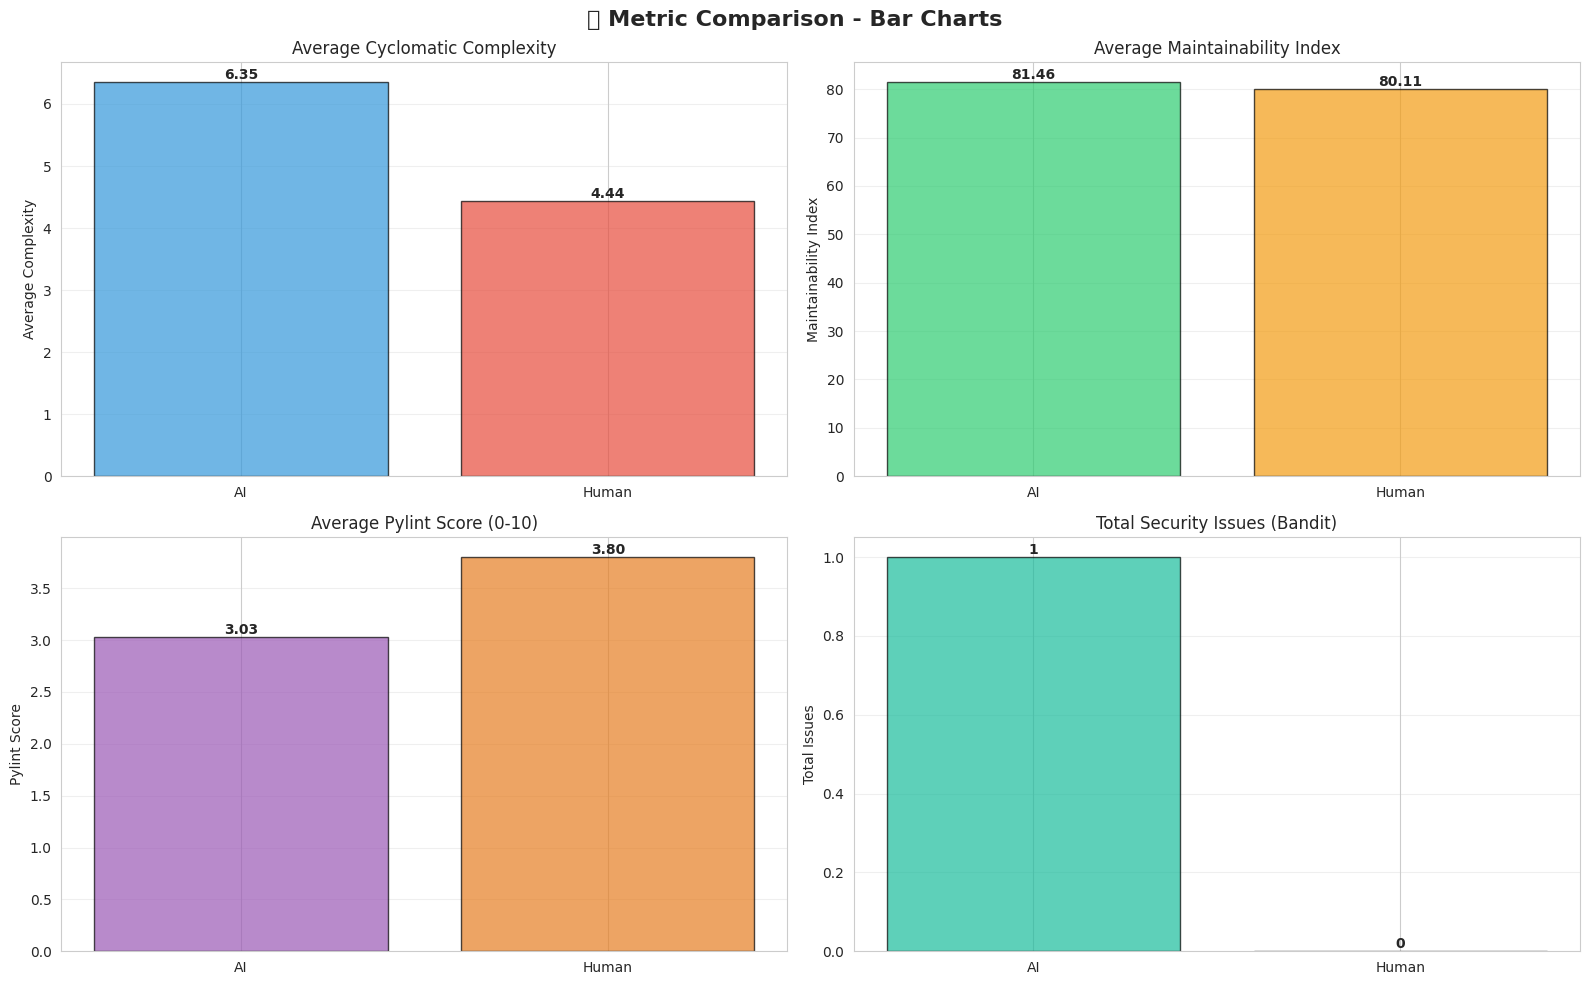

📐 2. Creating Halstead Comparison Bar Charts...


Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.


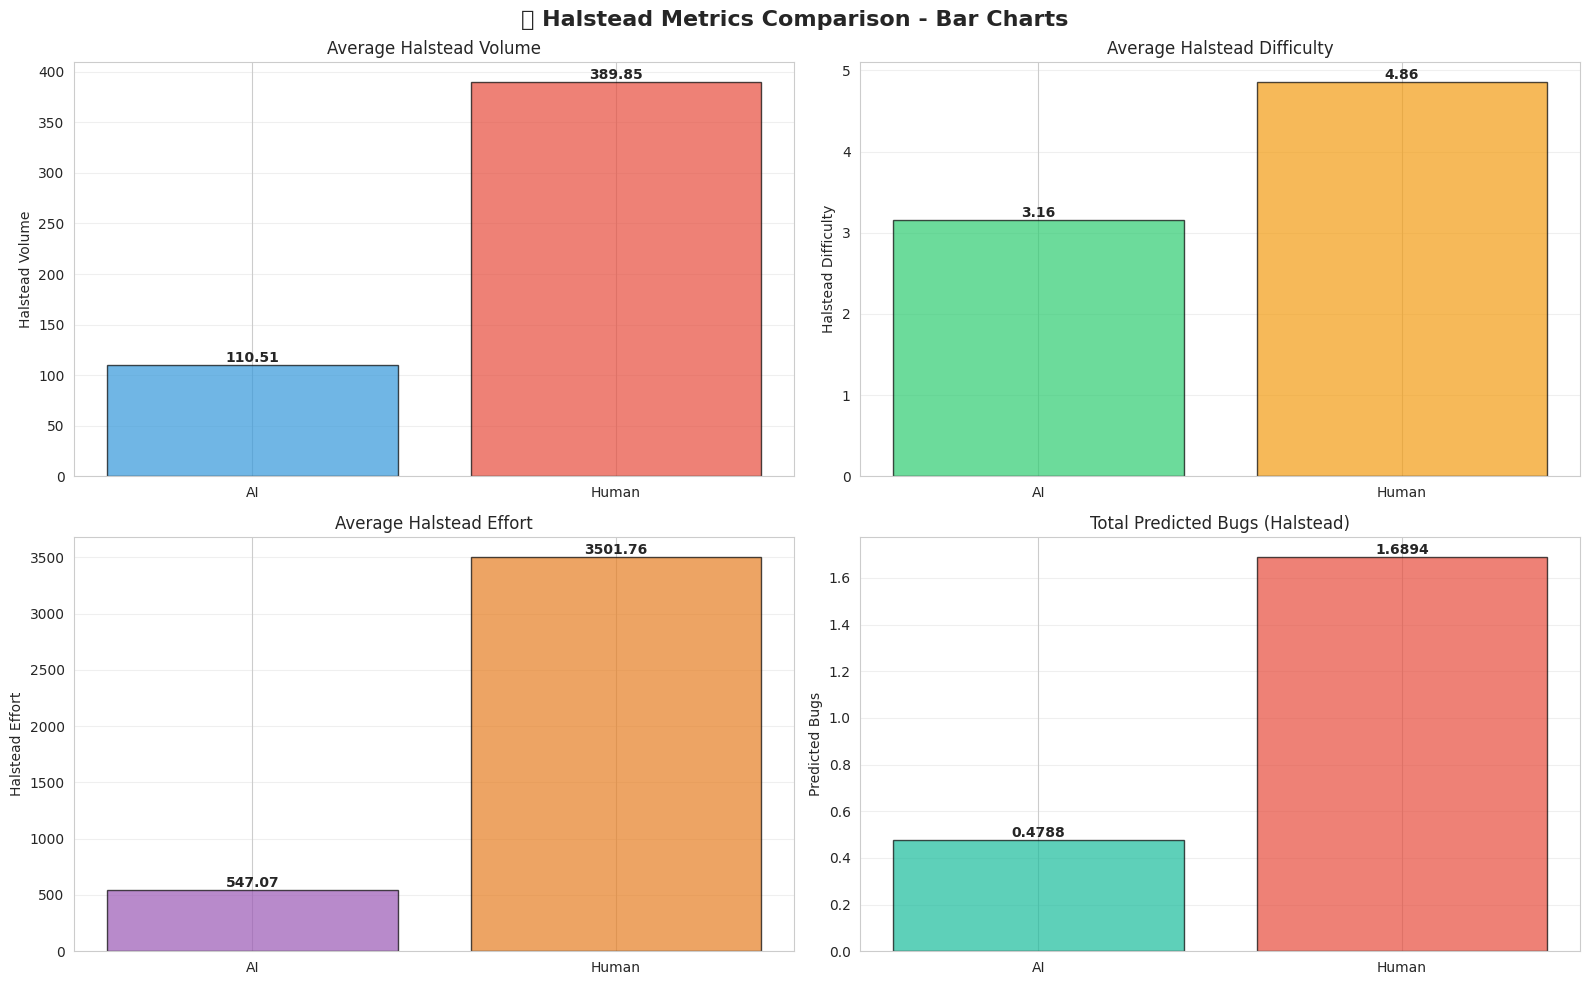

📈 3. Creating File-by-File Line Charts...
⚠️ No common files found between datasets
📦 4. Creating Distribution Box Plots...


Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.


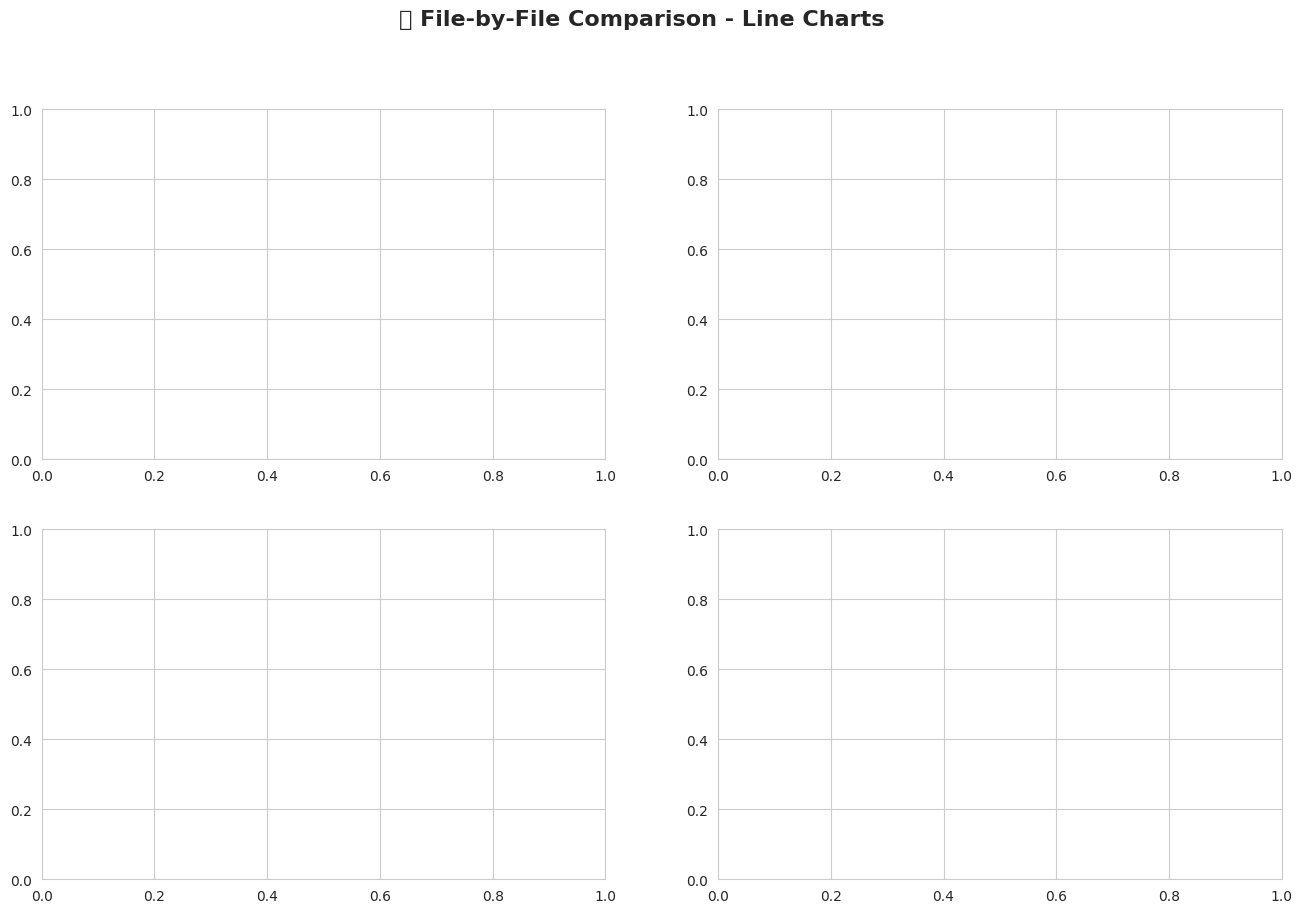

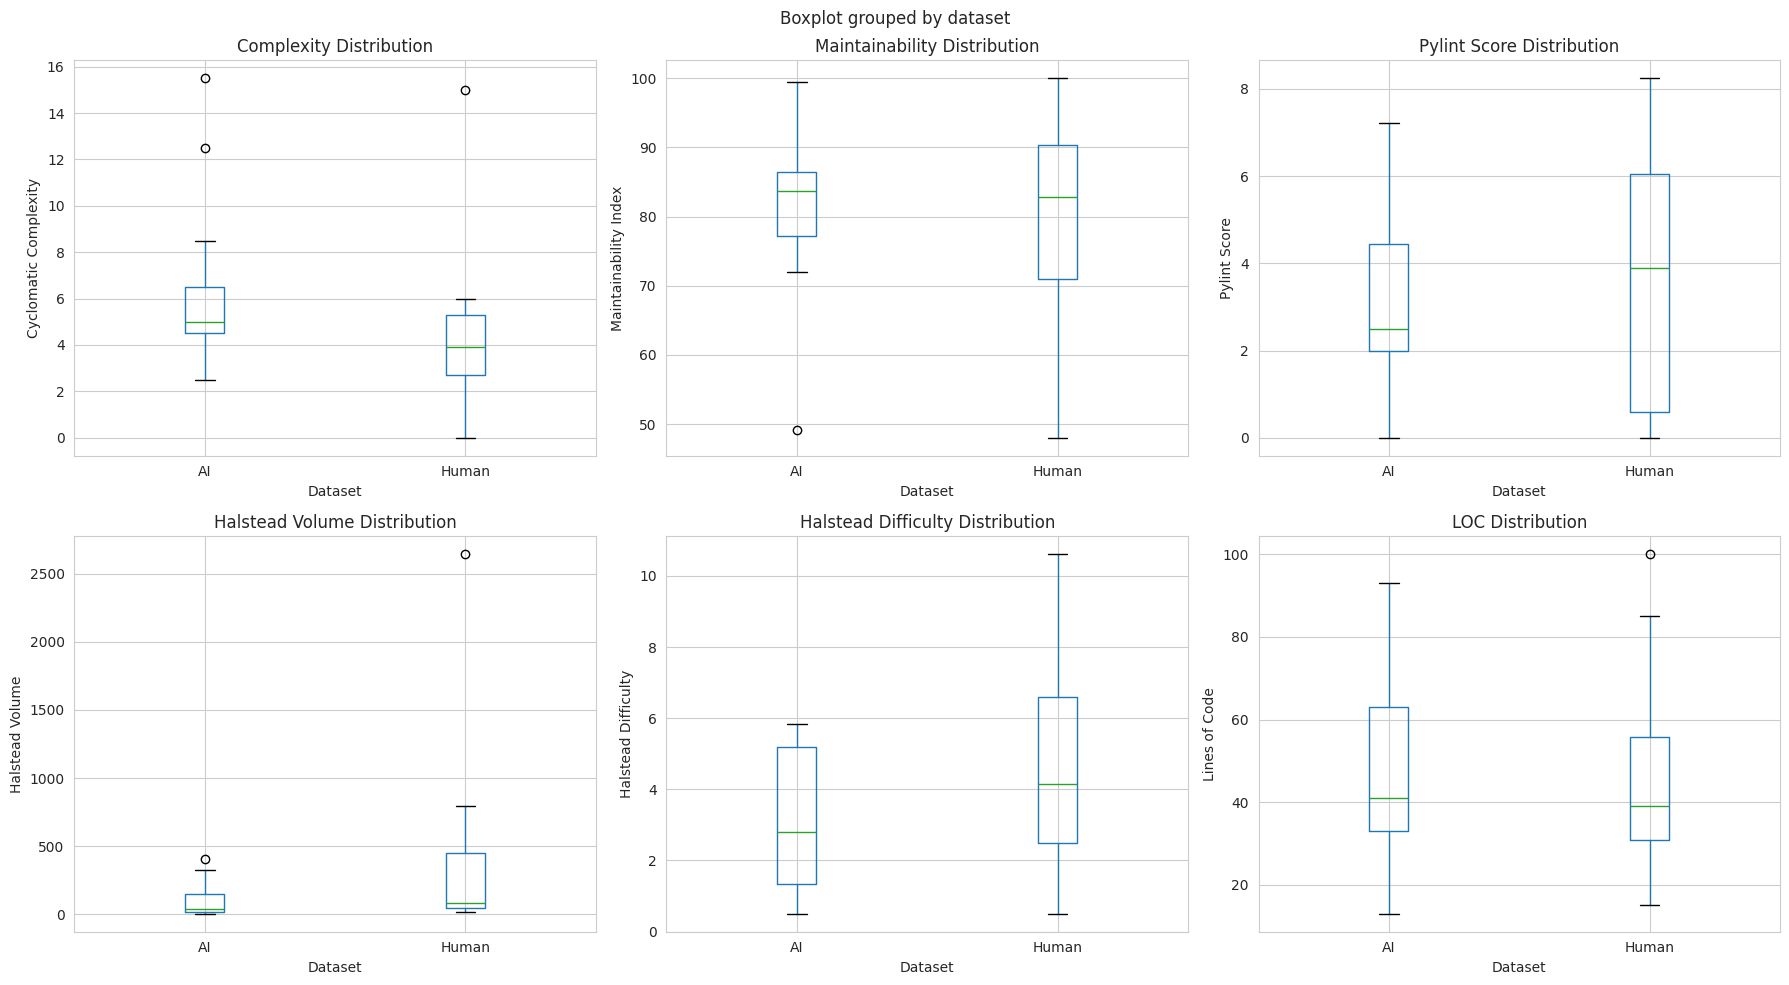

🔍 5. Creating Issues Comparison Bar Charts...


Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.


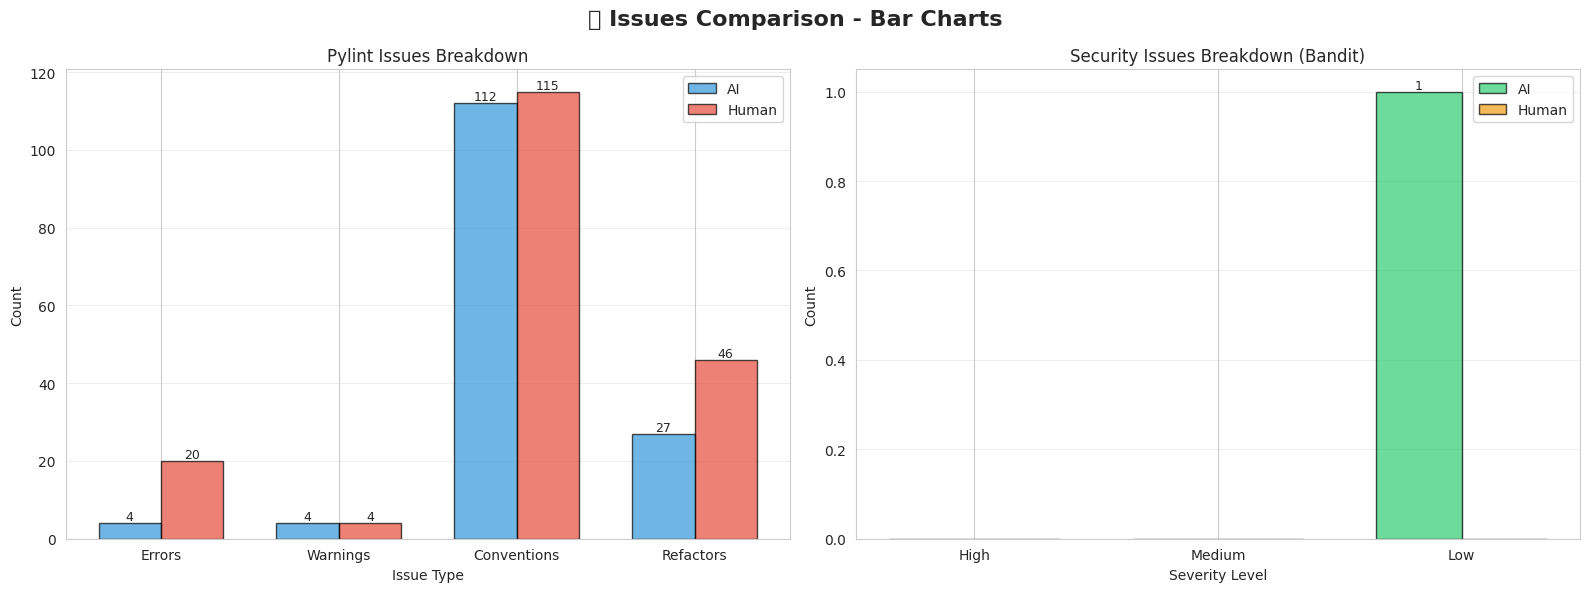

🎯 6. Creating Difficulty Comparison Box Plots...


Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.


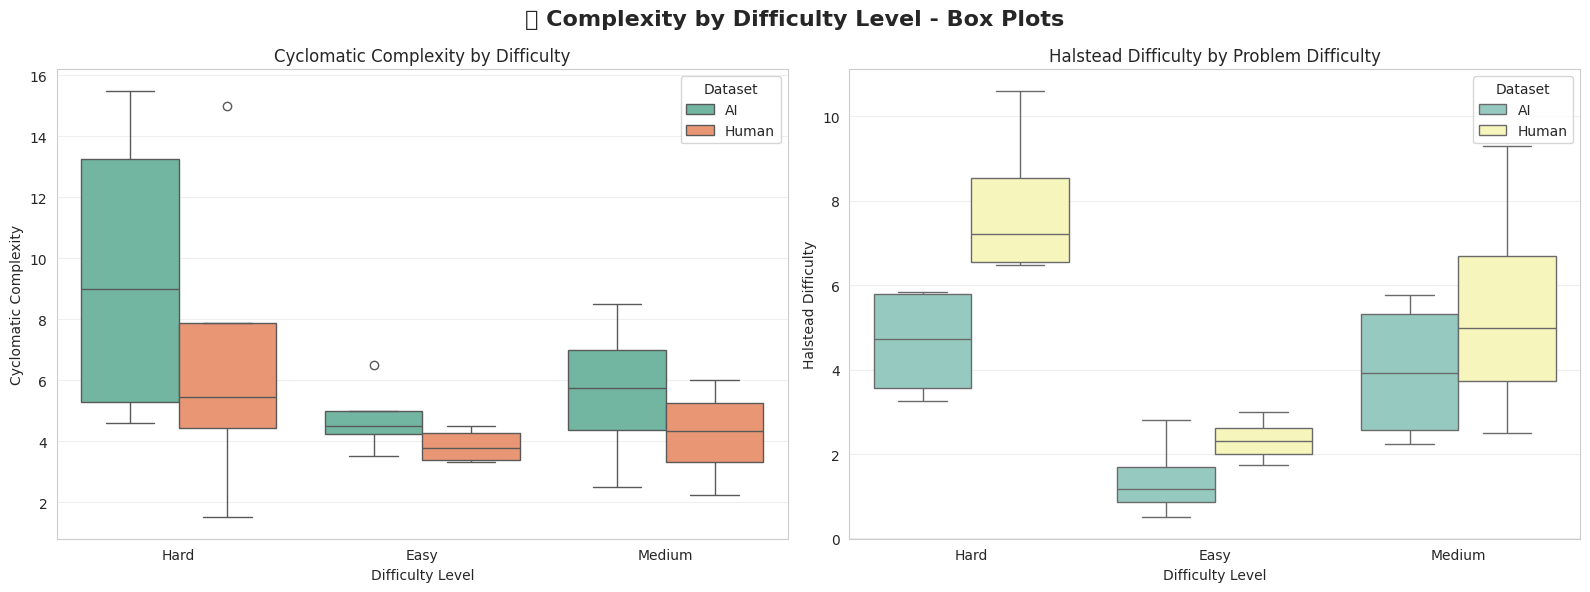


✅ All comparison visualizations complete!
✓ Comparison report saved to: comparison_report.txt


In [ ]:
"""
Static Analysis Comparison Tool
Compares two CSV files using bar charts, line charts, and box plots
Optimized for Google Colab
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Try to import Google Colab specific modules
try:
    from google.colab import files
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


class ComparisonVisualizer:
    """Compare two static analysis CSV files"""

    def __init__(self, old_csv, new_csv, old_label="AI", new_label="Human"):
        """
        Initialize comparison visualizer

        Args:
            old_csv (str): Path to first CSV file (AI-generated code)
            new_csv (str): Path to second CSV file (Human-written code)
            old_label (str): Label for first dataset (default: "AI")
            new_label (str): Label for second dataset (default: "Human")
        """
        self.old_csv = old_csv
        self.new_csv = new_csv
        self.old_label = old_label
        self.new_label = new_label
        self.df_old = None
        self.df_new = None
        self.load_data()

    def load_data(self):
        """Load and preprocess both CSV files"""
        try:
            self.df_old = pd.read_csv(self.old_csv)
            self.df_new = pd.read_csv(self.new_csv)

            print(f"✓ Loaded {len(self.df_old)} files from {self.old_label}")
            print(f"✓ Loaded {len(self.df_new)} files from {self.new_label}")

            # Convert numeric columns for both dataframes
            numeric_cols = [
                'radon_avg_complexity', 'radon_max_complexity',
                'radon_maintainability_index', 'radon_loc', 'radon_lloc',
                'radon_halstead_volume', 'radon_halstead_difficulty',
                'radon_halstead_effort', 'radon_halstead_time', 'radon_halstead_bugs',
                'pylint_score', 'pylint_errors', 'pylint_warnings',
                'bandit_total_issues', 'bandit_high_severity'
            ]

            for col in numeric_cols:
                if col in self.df_old.columns:
                    self.df_old[col] = pd.to_numeric(self.df_old[col], errors='coerce')
                if col in self.df_new.columns:
                    self.df_new[col] = pd.to_numeric(self.df_new[col], errors='coerce')

            # Add dataset labels
            self.df_old['dataset'] = self.old_label
            self.df_new['dataset'] = self.new_label

            # Add difficulty categories
            for df in [self.df_old, self.df_new]:
                if 'filename' in df.columns:
                    df['difficulty'] = df['filename'].str.extract(r'_(Easy|Medium|Hard)_')[0]
                    df['difficulty'] = df['difficulty'].fillna('Other')

            print("✓ Data loaded and preprocessed successfully\n")

        except Exception as e:
            print(f"✗ Error loading CSV files: {e}")
            raise

    def plot_metric_comparison_bar(self):
        """Compare key metrics using grouped bar charts"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📊 Metric Comparison - Bar Charts', fontsize=16, fontweight='bold')

        # 1. Average Complexity Comparison
        ax = axes[0, 0]
        if 'radon_avg_complexity' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_avg_complexity'].mean(),
                self.new_label: self.df_new['radon_avg_complexity'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#3498db', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Average Complexity')
            ax.set_title('Average Cyclomatic Complexity')
            ax.grid(axis='y', alpha=0.3)

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 2. Maintainability Index Comparison
        ax = axes[0, 1]
        if 'radon_maintainability_index' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_maintainability_index'].mean(),
                self.new_label: self.df_new['radon_maintainability_index'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#f39c12'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Average Maintainability Index')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 3. Pylint Score Comparison
        ax = axes[1, 0]
        if 'pylint_score' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['pylint_score'].mean(),
                self.new_label: self.df_new['pylint_score'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#9b59b6', '#e67e22'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Pylint Score')
            ax.set_title('Average Pylint Score (0-10)')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 4. Security Issues Comparison
        ax = axes[1, 1]
        if 'bandit_total_issues' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['bandit_total_issues'].sum(),
                self.new_label: self.df_new['bandit_total_issues'].sum()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#1abc9c', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Total Issues')
            ax.set_title('Total Security Issues (Bandit)')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_halstead_comparison_bar(self):
        """Compare Halstead metrics using grouped bar charts"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📐 Halstead Metrics Comparison - Bar Charts', fontsize=16, fontweight='bold')

        # 1. Halstead Volume
        ax = axes[0, 0]
        if 'radon_halstead_volume' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_volume'].mean(),
                self.new_label: self.df_new['radon_halstead_volume'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#3498db', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Average Halstead Volume')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 2. Halstead Difficulty
        ax = axes[0, 1]
        if 'radon_halstead_difficulty' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_difficulty'].mean(),
                self.new_label: self.df_new['radon_halstead_difficulty'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#f39c12'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Halstead Difficulty')
            ax.set_title('Average Halstead Difficulty')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 3. Halstead Effort
        ax = axes[1, 0]
        if 'radon_halstead_effort' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_effort'].mean(),
                self.new_label: self.df_new['radon_halstead_effort'].mean()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#9b59b6', '#e67e22'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Halstead Effort')
            ax.set_title('Average Halstead Effort')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

        # 4. Predicted Bugs
        ax = axes[1, 1]
        if 'radon_halstead_bugs' in self.df_old.columns:
            metrics = {
                self.old_label: self.df_old['radon_halstead_bugs'].sum(),
                self.new_label: self.df_new['radon_halstead_bugs'].sum()
            }
            bars = ax.bar(metrics.keys(), metrics.values(), color=['#1abc9c', '#e74c3c'],
                         edgecolor='black', alpha=0.7)
            ax.set_ylabel('Predicted Bugs')
            ax.set_title('Total Predicted Bugs (Halstead)')
            ax.grid(axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_file_by_file_line(self):
        """Compare files using line charts"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('📈 File-by-File Comparison - Line Charts', fontsize=16, fontweight='bold')

        # Match files by filename
        common_files = set(self.df_old['filename']) & set(self.df_new['filename'])

        if not common_files:
            print("⚠️ No common files found between datasets")
            return

        # Sort files for consistent ordering
        common_files = sorted(list(common_files))

        # 1. Complexity Trend
        ax = axes[0, 0]
        if 'radon_avg_complexity' in self.df_old.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['radon_avg_complexity'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['radon_avg_complexity'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Complexity')
            ax.set_title('Cyclomatic Complexity Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 2. Maintainability Trend
        ax = axes[0, 1]
        if 'radon_maintainability_index' in self.df_old.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['radon_maintainability_index'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['radon_maintainability_index'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Maintainability Index Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 3. Pylint Score Trend
        ax = axes[1, 0]
        if 'pylint_score' in self.df_old.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['pylint_score'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['pylint_score'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Pylint Score Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 4. Halstead Volume Trend
        ax = axes[1, 1]
        if 'radon_halstead_volume' in self.df_old.columns and 'radon_halstead_volume' in self.df_new.columns:
            old_vals = [self.df_old[self.df_old['filename']==f]['radon_halstead_volume'].values[0]
                       for f in common_files]
            new_vals = [self.df_new[self.df_new['filename']==f]['radon_halstead_volume'].values[0]
                       for f in common_files]

            x = range(len(common_files))
            ax.plot(x, old_vals, marker='o', label=self.old_label, linewidth=2, markersize=6)
            ax.plot(x, new_vals, marker='s', label=self.new_label, linewidth=2, markersize=6)
            ax.set_xlabel('File Index')
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Halstead Volume Trend')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_distribution_boxplots(self):
        """Compare distributions using box plots"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('📦 Distribution Comparison - Box Plots', fontsize=16, fontweight='bold')

        # Combine datasets for box plots
        df_combined = pd.concat([self.df_old, self.df_new], ignore_index=True)

        # 1. Complexity Distribution
        ax = axes[0, 0]
        if 'radon_avg_complexity' in df_combined.columns:
            df_combined.boxplot(column='radon_avg_complexity', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Cyclomatic Complexity')
            ax.set_title('Complexity Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 2. Maintainability Distribution
        ax = axes[0, 1]
        if 'radon_maintainability_index' in df_combined.columns:
            df_combined.boxplot(column='radon_maintainability_index', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Maintainability Index')
            ax.set_title('Maintainability Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 3. Pylint Score Distribution
        ax = axes[0, 2]
        if 'pylint_score' in df_combined.columns:
            df_combined.boxplot(column='pylint_score', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Pylint Score')
            ax.set_title('Pylint Score Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 4. Halstead Volume Distribution
        ax = axes[1, 0]
        if 'radon_halstead_volume' in df_combined.columns:
            df_combined.boxplot(column='radon_halstead_volume', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Halstead Volume')
            ax.set_title('Halstead Volume Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 5. Halstead Difficulty Distribution
        ax = axes[1, 1]
        if 'radon_halstead_difficulty' in df_combined.columns:
            df_combined.boxplot(column='radon_halstead_difficulty', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Halstead Difficulty')
            ax.set_title('Halstead Difficulty Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 6. LOC Distribution
        ax = axes[1, 2]
        if 'radon_loc' in df_combined.columns:
            df_combined.boxplot(column='radon_loc', by='dataset', ax=ax)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Lines of Code')
            ax.set_title('LOC Distribution')
            plt.sca(ax)
            plt.xticks(rotation=0)

        plt.tight_layout()
        plt.show()

    def plot_issues_comparison_bar(self):
        """Compare issue counts using stacked bar charts"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('🔍 Issues Comparison - Bar Charts', fontsize=16, fontweight='bold')

        # 1. Pylint Issues Breakdown
        ax = axes[0]
        if all(col in self.df_old.columns for col in ['pylint_errors', 'pylint_warnings',
                                                        'pylint_conventions', 'pylint_refactors']):
            categories = ['Errors', 'Warnings', 'Conventions', 'Refactors']
            old_values = [
                self.df_old['pylint_errors'].sum(),
                self.df_old['pylint_warnings'].sum(),
                self.df_old['pylint_conventions'].sum(),
                self.df_old['pylint_refactors'].sum()
            ]
            new_values = [
                self.df_new['pylint_errors'].sum(),
                self.df_new['pylint_warnings'].sum(),
                self.df_new['pylint_conventions'].sum(),
                self.df_new['pylint_refactors'].sum()
            ]

            x = np.arange(len(categories))
            width = 0.35

            bars1 = ax.bar(x - width/2, old_values, width, label=self.old_label,
                          color='#3498db', edgecolor='black', alpha=0.7)
            bars2 = ax.bar(x + width/2, new_values, width, label=self.new_label,
                          color='#e74c3c', edgecolor='black', alpha=0.7)

            ax.set_xlabel('Issue Type')
            ax.set_ylabel('Count')
            ax.set_title('Pylint Issues Breakdown')
            ax.set_xticks(x)
            ax.set_xticklabels(categories)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}', ha='center', va='bottom', fontsize=9)

        # 2. Security Issues Breakdown
        ax = axes[1]
        if all(col in self.df_old.columns for col in ['bandit_high_severity',
                                                        'bandit_medium_severity', 'bandit_low_severity']):
            categories = ['High', 'Medium', 'Low']
            old_values = [
                self.df_old['bandit_high_severity'].sum(),
                self.df_old['bandit_medium_severity'].sum(),
                self.df_old['bandit_low_severity'].sum()
            ]
            new_values = [
                self.df_new['bandit_high_severity'].sum(),
                self.df_new['bandit_medium_severity'].sum(),
                self.df_new['bandit_low_severity'].sum()
            ]

            x = np.arange(len(categories))
            width = 0.35

            bars1 = ax.bar(x - width/2, old_values, width, label=self.old_label,
                          color='#2ecc71', edgecolor='black', alpha=0.7)
            bars2 = ax.bar(x + width/2, new_values, width, label=self.new_label,
                          color='#f39c12', edgecolor='black', alpha=0.7)

            ax.set_xlabel('Severity Level')
            ax.set_ylabel('Count')
            ax.set_title('Security Issues Breakdown (Bandit)')
            ax.set_xticks(x)
            ax.set_xticklabels(categories)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

    def plot_difficulty_comparison_boxplot(self):
        """Compare metrics by difficulty level using box plots"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('🎯 Complexity by Difficulty Level - Box Plots', fontsize=16, fontweight='bold')

        # Combine datasets
        df_combined = pd.concat([self.df_old, self.df_new], ignore_index=True)
        df_filtered = df_combined[df_combined['difficulty'] != 'Other']

        if df_filtered.empty:
            print("⚠️ No difficulty categorization found")
            return

        # 1. Cyclomatic Complexity by Difficulty
        ax = axes[0]
        if 'radon_avg_complexity' in df_filtered.columns:
            sns.boxplot(data=df_filtered, x='difficulty', y='radon_avg_complexity',
                       hue='dataset', ax=ax, palette='Set2')
            ax.set_xlabel('Difficulty Level')
            ax.set_ylabel('Cyclomatic Complexity')
            ax.set_title('Cyclomatic Complexity by Difficulty')
            ax.legend(title='Dataset')
            ax.grid(axis='y', alpha=0.3)

        # 2. Halstead Difficulty by Problem Difficulty
        ax = axes[1]
        if 'radon_halstead_difficulty' in df_filtered.columns:
            sns.boxplot(data=df_filtered, x='difficulty', y='radon_halstead_difficulty',
                       hue='dataset', ax=ax, palette='Set3')
            ax.set_xlabel('Difficulty Level')
            ax.set_ylabel('Halstead Difficulty')
            ax.set_title('Halstead Difficulty by Problem Difficulty')
            ax.legend(title='Dataset')
            ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_all_comparisons(self):
        """Generate all comparison visualizations"""
        print("\n" + "="*70)
        print("🎨 GENERATING COMPARISON VISUALIZATIONS")
        print("="*70 + "\n")

        print("📊 1. Creating Metric Comparison Bar Charts...")
        self.plot_metric_comparison_bar()

        print("📐 2. Creating Halstead Comparison Bar Charts...")
        self.plot_halstead_comparison_bar()

        print("📈 3. Creating File-by-File Line Charts...")
        self.plot_file_by_file_line()

        print("📦 4. Creating Distribution Box Plots...")
        self.plot_distribution_boxplots()

        print("🔍 5. Creating Issues Comparison Bar Charts...")
        self.plot_issues_comparison_bar()

        print("🎯 6. Creating Difficulty Comparison Box Plots...")
        self.plot_difficulty_comparison_boxplot()

        print("\n" + "="*70)
        print("✅ All comparison visualizations complete!")
        print("="*70)

    def generate_comparison_report(self, output_file='comparison_report.txt'):
        """Generate text comparison report"""
        with open(output_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("COMPARISON REPORT\n")
            f.write("="*70 + "\n\n")

            f.write(f"{self.old_label} Files: {len(self.df_old)}\n")
            f.write(f"{self.new_label} Files: {len(self.df_new)}\n\n")

            # Complexity comparison
            f.write("COMPLEXITY METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_avg_complexity' in self.df_old.columns:
                old_avg = self.df_old['radon_avg_complexity'].mean()
                new_avg = self.df_new['radon_avg_complexity'].mean()
                diff = new_avg - old_avg
                f.write(f"Average Cyclomatic Complexity:\n")
                f.write(f"  {self.old_label}: {old_avg:.2f}\n")
                f.write(f"  {self.new_label}: {new_avg:.2f}\n")
                f.write(f"  Difference: {diff:+.2f} ({(diff/old_avg*100):+.1f}%)\n\n")

            # Halstead comparison
            f.write("HALSTEAD METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'radon_halstead_volume' in self.df_old.columns:
                old_vol = self.df_old['radon_halstead_volume'].mean()
                new_vol = self.df_new['radon_halstead_volume'].mean()
                diff = new_vol - old_vol
                f.write(f"Average Halstead Volume:\n")
                f.write(f"  {self.old_label}: {old_vol:.2f}\n")
                f.write(f"  {self.new_label}: {new_vol:.2f}\n")
                f.write(f"  Difference: {diff:+.2f} ({(diff/old_vol*100):+.1f}%)\n\n")

            # Quality comparison
            f.write("QUALITY METRICS:\n")
            f.write("-" * 50 + "\n")
            if 'pylint_score' in self.df_old.columns:
                old_score = self.df_old['pylint_score'].mean()
                new_score = self.df_new['pylint_score'].mean()
                diff = new_score - old_score
                f.write(f"Average Pylint Score:\n")
                f.write(f"  {self.old_label}: {old_score:.2f}\n")
                f.write(f"  {self.new_label}: {new_score:.2f}\n")
                f.write(f"  Difference: {diff:+.2f} ({(diff/old_score*100):+.1f}%)\n\n")

            # Security comparison
            f.write("SECURITY ISSUES:\n")
            f.write("-" * 50 + "\n")
            if 'bandit_total_issues' in self.df_old.columns:
                old_issues = self.df_old['bandit_total_issues'].sum()
                new_issues = self.df_new['bandit_total_issues'].sum()
                diff = new_issues - old_issues
                f.write(f"Total Security Issues:\n")
                f.write(f"  {self.old_label}: {int(old_issues)}\n")
                f.write(f"  {self.new_label}: {int(new_issues)}\n")
                f.write(f"  Difference: {diff:+.0f}\n\n")

        print(f"✓ Comparison report saved to: {output_file}")


def compare_analysis(old_csv, new_csv, old_label="AI", new_label="Human"):
    """
    Main function to compare two analysis CSV files

    Args:
        old_csv (str): Path to first CSV file (AI-generated code)
        new_csv (str): Path to second CSV file (Human-written code)
        old_label (str): Label for first dataset (default: "AI")
        new_label (str): Label for second dataset (default: "Human")

    Usage:
        # Default labels (AI vs Human)
        compare_analysis('AI_analysis_results.csv', 'human_analysis_results.csv')

        # Custom labels
        compare_analysis('file1.csv', 'file2.csv',
                        old_label="ChatGPT", new_label="Developer")
    """
    # Handle file upload in Colab
    if COLAB_ENV:
        if not Path(old_csv).exists() or not Path(new_csv).exists():
            print("📤 Please upload your CSV files")
            print("First, upload the AI-generated code analysis CSV:")
            uploaded1 = files.upload()
            if uploaded1:
                old_csv = list(uploaded1.keys())[0]

            print("\nNow upload the Human-written code analysis CSV:")
            uploaded2 = files.upload()
            if uploaded2:
                new_csv = list(uploaded2.keys())[0]

    # Create visualizer and generate comparisons
    viz = ComparisonVisualizer(old_csv, new_csv, old_label, new_label)
    viz.generate_all_comparisons()
    viz.generate_comparison_report()

    return viz


# Main execution
if __name__ == "__main__":
    import sys

    if len(sys.argv) > 2:
        old_csv = sys.argv[1]
        new_csv = sys.argv[2]
        old_label = sys.argv[3] if len(sys.argv) > 3 else "AI"
        new_label = sys.argv[4] if len(sys.argv) > 4 else "Human"
    else:
        # Default file names for AI vs Human comparison
        old_csv = 'AI_analysis_results.csv'
        new_csv = 'human_analysis_results.csv'
        old_label = "AI-Generated"
        new_label = "Human-Written"

    compare_analysis(old_csv, new_csv, old_label, new_label)

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


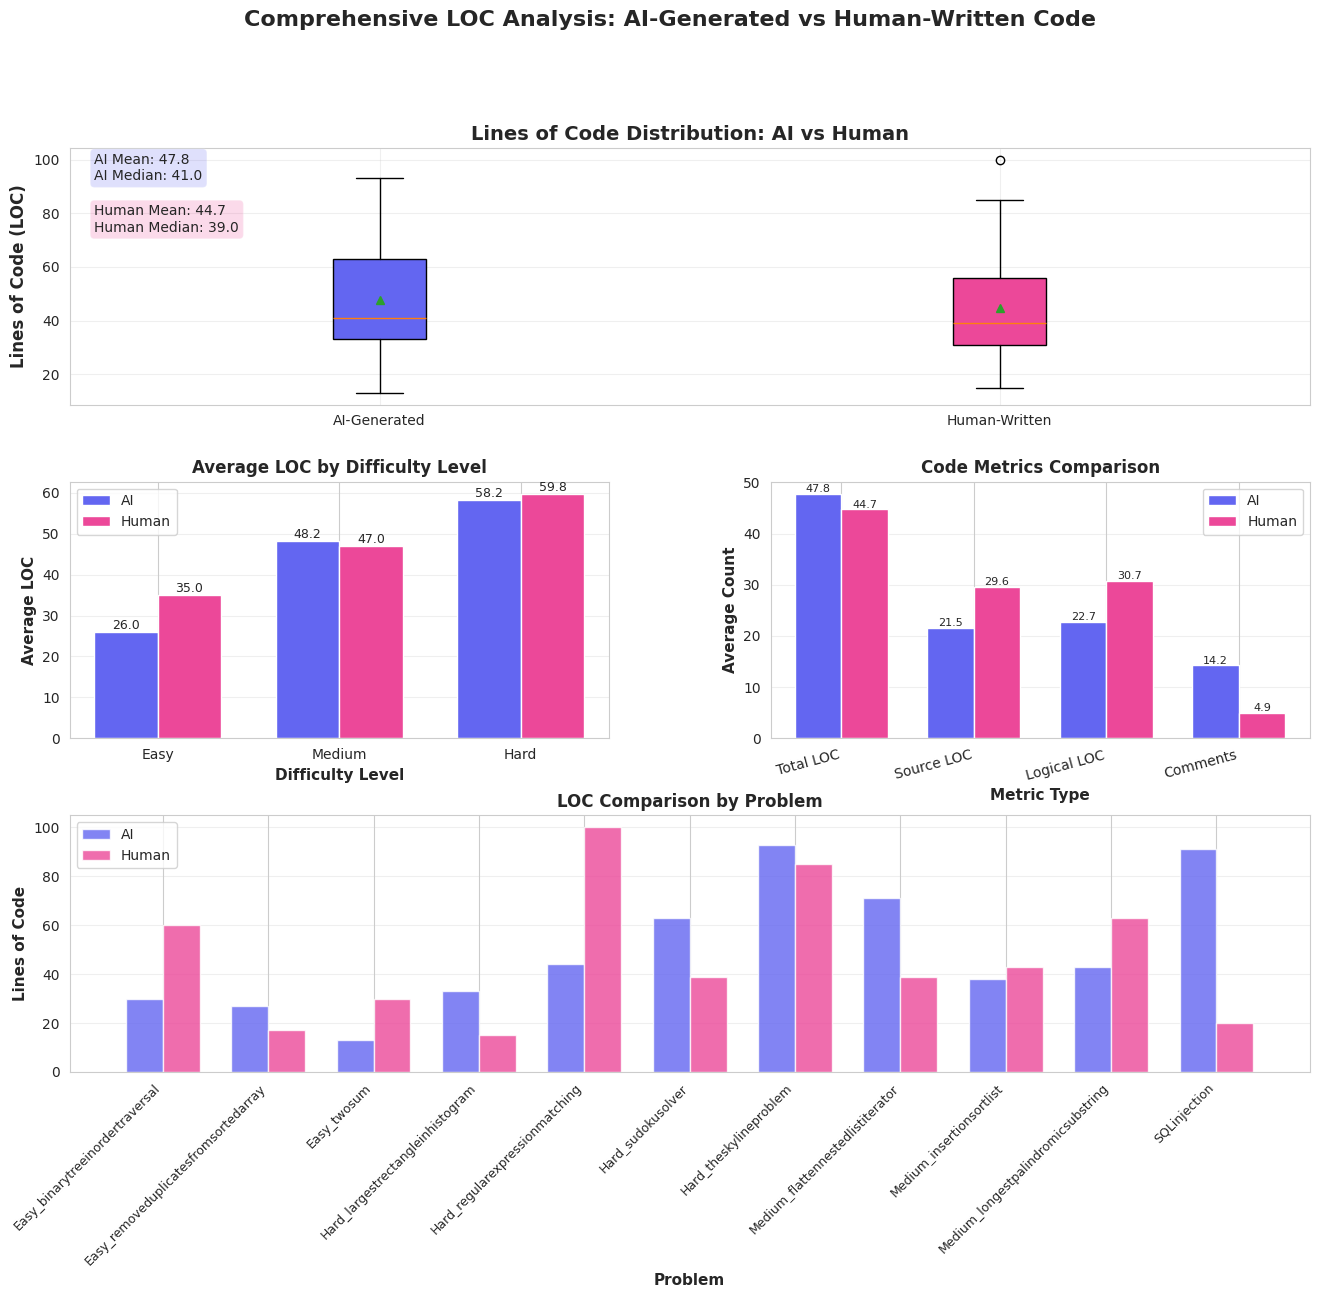

LOC COMPARISON SUMMARY

AI-Generated Code:
  Mean LOC: 47.77
  Median LOC: 41.00
  Std Dev: 24.54
  Min: 13
  Max: 93

Human-Written Code:
  Mean LOC: 44.71
  Median LOC: 39.00
  Std Dev: 24.76
  Min: 15
  Max: 100

Difference:
  Mean Difference: -3.05 LOC (-6.4%)
  Human code is on average 6.4% shorter than AI code



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
# Specify encoding='utf-8' to handle potential encoding issues
ai_data = pd.read_csv('AI_analysis_results.csv', encoding='utf-8')
human_data = pd.read_csv('human_analysis_results.csv', encoding='utf-8')

# Add source labels
ai_data['source'] = 'AI'
human_data['source'] = 'Human'

# Extract problem names from filenames (removing prefixes and extensions)
# Ensure the regex is correctly applied to handle different file naming conventions
ai_data['problem'] = ai_data['filename'].str.replace('AIS_', '', regex=False).str.replace('.py', '', regex=False)
human_data['problem'] = human_data['filename'].str.replace('HS_', '', regex=False).str.replace('HS1_', '', regex=False).str.replace('HS2_', '', regex=False).str.replace('.py', '', regex=False)


# Combine datasets
combined_data = pd.concat([ai_data, human_data], ignore_index=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Overall LOC Comparison (Box Plot)
ax1 = fig.add_subplot(gs[0, :])
box_data = [ai_data['radon_loc'], human_data['radon_loc']]
bp = ax1.boxplot(box_data, labels=['AI-Generated', 'Human-Written'],
                 patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('#6366f1')
bp['boxes'][1].set_facecolor('#ec4899')
ax1.set_ylabel('Lines of Code (LOC)', fontsize=12, fontweight='bold')
ax1.set_title('Lines of Code Distribution: AI vs Human', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add statistics
ai_mean = ai_data['radon_loc'].mean()
human_mean = human_data['radon_loc'].mean()
ai_median = ai_data['radon_loc'].median()
human_median = human_data['radon_loc'].median()
ax1.text(0.02, 0.98, f'AI Mean: {ai_mean:.1f}\nAI Median: {ai_median:.1f}',
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='#6366f1', alpha=0.2))
ax1.text(0.02, 0.78, f'Human Mean: {human_mean:.1f}\nHuman Median: {human_median:.1f}',
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='#ec4899', alpha=0.2))

# 2. LOC by Difficulty Level
ax2 = fig.add_subplot(gs[1, 0])
# Extract difficulty from problem names
ai_data['difficulty'] = ai_data['problem'].str.extract(r'(Easy|Medium|Hard)')[0]
human_data['difficulty'] = human_data['problem'].str.extract(r'(Easy|Medium|Hard)')[0]

# Filter out rows where difficulty is NaN before grouping
difficulty_data_ai = ai_data.dropna(subset=['difficulty']).groupby('difficulty')['radon_loc'].mean().rename('AI')
difficulty_data_human = human_data.dropna(subset=['difficulty']).groupby('difficulty')['radon_loc'].mean().rename('Human')

difficulty_data = pd.concat([
    difficulty_data_ai,
    difficulty_data_human
], axis=1).reindex(['Easy', 'Medium', 'Hard']) # Ensure consistent order

x = np.arange(len(difficulty_data.index))
width = 0.35
bars1 = ax2.bar(x - width/2, difficulty_data['AI'], width, label='AI', color='#6366f1')
bars2 = ax2.bar(x + width/2, difficulty_data['Human'], width, label='Human', color='#ec4899')

ax2.set_xlabel('Difficulty Level', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average LOC', fontsize=11, fontweight='bold')
ax2.set_title('Average LOC by Difficulty Level', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(difficulty_data.index)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 3. LOC Metrics Comparison (SLOC, LLOC, Comments)
ax3 = fig.add_subplot(gs[1, 1])
metrics = ['radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments']
metric_names = ['Total LOC', 'Source LOC', 'Logical LOC', 'Comments']

ai_metrics = [ai_data[m].mean() for m in metrics]
human_metrics = [human_data[m].mean() for m in metrics]

x = np.arange(len(metric_names))
width = 0.35
bars1 = ax3.bar(x - width/2, ai_metrics, width, label='AI', color='#6366f1')
bars2 = ax3.bar(x + width/2, human_metrics, width, label='Human', color='#ec4899')

ax3.set_xlabel('Metric Type', fontsize=11, fontweight='bold')
ax3.set_ylabel('Average Count', fontsize=11, fontweight='bold')
ax3.set_title('Code Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metric_names, rotation=15, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# 4. Individual File Comparison
ax4 = fig.add_subplot(gs[2, :])
# Match problems that exist in both datasets based on the base problem name
ai_data['base_problem'] = ai_data['problem'].str.replace(r'_(Easy|Medium|Hard)', '', regex=True)
human_data['base_problem'] = human_data['problem'].str.replace(r'_(Easy|Medium|Hard)', '', regex=True)

# Find common base problems
common_base_problems = set(ai_data['base_problem']) & set(human_data['base_problem'])

comparison_list = []
for base_prob in sorted(list(common_base_problems)):
    ai_row = ai_data[ai_data['base_problem'] == base_prob].iloc[0] # Assuming one match per base problem
    human_row = human_data[human_data['base_problem'] == base_prob].iloc[0] # Assuming one match per base problem

    comparison_list.append({
        'Problem': base_prob,
        'AI_LOC': ai_row['radon_loc'],
        'Human_LOC': human_row['radon_loc']
    })

comparison_df = pd.DataFrame(comparison_list)


if not comparison_df.empty:
    x = np.arange(len(comparison_df))
    width = 0.35
    bars1 = ax4.bar(x - width/2, comparison_df['AI_LOC'], width, label='AI', color='#6366f1', alpha=0.8)
    bars2 = ax4.bar(x + width/2, comparison_df['Human_LOC'], width, label='Human', color='#ec4899', alpha=0.8)

    ax4.set_xlabel('Problem', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Lines of Code', fontsize=11, fontweight='bold')
    ax4.set_title('LOC Comparison by Problem', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(comparison_df['Problem'], rotation=45, ha='right', fontsize=9)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive LOC Analysis: AI-Generated vs Human-Written Code',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('loc_comparison_ai_vs_human.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("=" * 60)
print("LOC COMPARISON SUMMARY")
print("=" * 60)
print(f"\nAI-Generated Code:")
print(f"  Mean LOC: {ai_mean:.2f}")
print(f"  Median LOC: {ai_median:.2f}")
print(f"  Std Dev: {ai_data['radon_loc'].std():.2f}")
print(f"  Min: {ai_data['radon_loc'].min()}")
print(f"  Max: {ai_data['radon_loc'].max()}")

print(f"\nHuman-Written Code:")
print(f"  Mean LOC: {human_mean:.2f}")
print(f"  Median LOC: {human_median:.2f}")
print(f"  Std Dev: {human_data['radon_loc'].std():.2f}")
print(f"  Min: {human_data['radon_loc'].min()}")
print(f"  Max: {human_data['radon_loc'].max()}")

print(f"\nDifference:")
print(f"  Mean Difference: {human_mean - ai_mean:.2f} LOC ({((human_mean - ai_mean) / ai_mean * 100):.1f}%)")
print(f"  Human code is on average {abs((human_mean - ai_mean) / ai_mean * 100):.1f}% {'longer' if human_mean > ai_mean else 'shorter'} than AI code")

print("\n" + "=" * 60)